# Project Overview

The purpose of this project is to create a model to predict the outcome of UFC (Ultimate Fighting Championship) events. The UFC was created in 1993 with the expressed purpose of identifying the most effective martial art(s). This project is an extension of my curiosity into the original purpose of the UFC; what makes an effective martial artist, relative to an opponent?

# Data Overview

### Data Description

The majority of the data I used for this project I scraped from UFCStats.com. This website contains more statistics than any other website, but does not have some key metrics such as fighter sizes, bios, and odds. 

Thus, the odds were scraped from bestfightodds.com, while the fighter sizes and bios were scraped from ufc.com. 

Further, individual events and fights, and much from the final streamlit application, are scraped from ufc.com.

The data itself is fight-by-fight based data, originally from over 8,000 fights (which, after dropping for lack of data, decreased to around 5,000 by the final testing dataframe).

There are 350 final tested features in this dataset, and over 450 features in the non-tested version of the dataset, as many of the features are in-match statistics that are unknowable before a fight, so they had to be removed from the testing section. 

#### Data Limitations

I would really like to be able to categorize these martial artists based on their initial skillset and studies, but this is not possible with any dataset that I have seen. For instance, if a martial artist is a blackbelt in Jiujitsu since he was 6, I would like to know! Ideally, in further iterations of this project, I would be able to add historical, contextual data such as this. 


### Define Target Variable

The target variable in this project is if a fighter won an individual fight or not. 

### Define Scoring Metric

Because our data is evenly split between wins and losses, and there is no relative advantage between false negatives and false positives, accuracy is my chosen scoring metric. For this product, there is no tradeoff between the consequences of error types.

## Project Structure

As there was no up-to-date database available, a good portion of this notebook is scraping and saving data using various methods with beautiful soup and selenium. 


## Part 1: Scraping


### Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     
import shutil       
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
import requests
import json
import xgboost
from xgboost import XGBClassifier
from random import randint
import  random
import os
os.chdir('C:/Users/tmcro/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction')
from cmath import nan
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
import pickle
from sklearn.metrics import fbeta_score
import winsound
from sklearn.linear_model import LinearRegression
from sklearn import tree, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, f1_score, make_scorer, recall_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [5]:
def get_next_event_ufcstats():
    # This function scrapes the UFCStats website for the next event
    url = 'http://www.ufcstats.com/statistics/events/upcoming'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    # get events
    event1 = soup.find('td', class_='b-statistics__table-col')
    event1_txt = soup.find('td', class_='b-statistics__table-col').text
    event_txt = event1_txt.replace('   ', '').replace('\n', '').strip()
    event_title = event_txt.split('  ')[0]
    event_date = event_txt.split('  ')[1]
    event1_url = event1.find('a')['href']
    data = pd.DataFrame({'event_title': [event_title], 'event_url': [event1_url], 'event_date': [event_date]})
    return data

In [6]:
next_event = get_next_event_ufcstats()
next_event

,event_title,event_url,event_date
0,UFC Fight Night: Rodriguez vs. Lemos,http://www.ufcstats.com/event-details/756f4590...,"November 05, 2022"


### Grab all data from all fighters fighting in next event

In [7]:
def get_fighter_urls(event_details_url):
    # This function scrapes the UFCStats website for the fighter urls for a given event
    page = requests.get(event_details_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    # get events
    events = soup.find_all('tr', class_='b-fight-details__table-row b-fight-details__table-row__hover js-fight-details-click')
    n = 0
    next_event_data = pd.DataFrame()

    for event in events:
        fighters = events[n].find_all('p', class_='b-fight-details__table-text')
        fighter1 = fighters[0].text
        fighter1 = fighter1.replace('  ', '').replace('\n', '').strip()
        fighter2 = fighters[1].text
        fighter2 = fighter2.replace('  ', '').replace('\n', '').strip()
        fighter1_url = fighters[0].find('a')['href']
        fighter2_url = fighters[1].find('a')['href']
        next_event_data = next_event_data.append({'fighter1' :fighter1, 'fighter2:' : fighter2, 'fighter1_url': fighter1_url, 
                                                    'fighter2_url':fighter2_url, 'fight#' : n+1}, ignore_index = True)
        n += 1

    return next_event_data


In [8]:
fighter_urls = get_fighter_urls(next_event['event_url'].values[0])
fighter_urls

,fighter1,fighter2:,fighter1_url,fighter2_url,fight#
0,Marina Rodriguez,Amanda Lemos,http://www.ufcstats.com/fighter-details/cd2c4d...,http://www.ufcstats.com/fighter-details/3df549...,1
1,Neil Magny,Daniel Rodriguez,http://www.ufcstats.com/fighter-details/84b3e7...,http://www.ufcstats.com/fighter-details/8a1f3b...,2
2,Chase Sherman,Josh Parisian,http://www.ufcstats.com/fighter-details/01b352...,http://www.ufcstats.com/fighter-details/b5da8f...,3
3,Tagir Ulanbekov,Nate Maness,http://www.ufcstats.com/fighter-details/f00ac0...,http://www.ufcstats.com/fighter-details/6e9f40...,4
4,Grant Dawson,Mark Madsen,http://www.ufcstats.com/fighter-details/99bd51...,http://www.ufcstats.com/fighter-details/da0995...,5
5,Jailton Almeida,Maxim Grishin,http://www.ufcstats.com/fighter-details/41e83a...,http://www.ufcstats.com/fighter-details/950d0e...,6
6,Darrick Minner,Shayilan Nuerdanbieke,http://www.ufcstats.com/fighter-details/34e516...,http://www.ufcstats.com/fighter-details/0a73ac...,7
7,Miranda Maverick,Shanna Young,http://www.ufcstats.com/fighter-details/f29a63...,http://www.ufcstats.com/fighter-details/568bba...,8
8,Mario Bautista,Benito Lopez,http://www.ufcstats.com/fighter-details/bc711b...,http://www.ufcstats.com/fighter-details/773f7f...,9
9,Polyana Viana,Jinh Yu Frey,http://www.ufcstats.com/fighter-details/9673a4...,http://www.ufcstats.com/fighter-details/d05cb1...,10


In [9]:
def get_fighter_previous_fights(fighter_details_url):
    # This function scrapes the UFCStats website for the previous fights for a given fighter

    page = requests.get(fighter_details_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # get fighter name from top of fighter details page
    fighter_name = soup.find('span', class_='b-content__title-highlight').text
    fighter_name = fighter_name.replace('\n', '').replace('  ', '').strip()

    #get fighter last fights data
    fighter_last_fights = soup.find_all('tr', class_='b-fight-details__table-row b-fight-details__table-row__hover js-fight-details-click')
    n = 0
    fighter_last_fights_data = pd.DataFrame()

    for fight in fighter_last_fights:
        urls = fighter_last_fights[n].find_all('a')
        fight_url = urls[0]['href']
        fighter_last_fights_data = fighter_last_fights_data.append({'fight_url' :fight_url}, ignore_index = True)
        n += 1

    return fighter_last_fights_data


In [10]:
fighter_prevFights_urls = get_fighter_previous_fights(fighter_urls['fighter1_url'].values[0])
fighter_prevFights_urls

,fight_url
0,http://www.ufcstats.com/fight-details/9321b3c9...
1,http://www.ufcstats.com/fight-details/149d6b90...
2,http://www.ufcstats.com/fight-details/b948102c...
3,http://www.ufcstats.com/fight-details/cd08b68f...
4,http://www.ufcstats.com/fight-details/5632f236...
5,http://www.ufcstats.com/fight-details/3b8cac99...
6,http://www.ufcstats.com/fight-details/d93b589b...
7,http://www.ufcstats.com/fight-details/f5a038c1...
8,http://www.ufcstats.com/fight-details/a7492cbf...
9,http://www.ufcstats.com/fight-details/c545843a...


In [11]:
fighter_previous_fight_urls = list(fighter_prevFights_urls['fight_url'].values)

In [12]:
def get_winner_from_ufcstats(url):
    # This function scrapes the UFCStats website for the winner of a given fight
    try:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        both = soup.find_all('div', class_='b-fight-details__person')
        first = both[0].text.replace('   ', '').replace('\n', '').strip()
        second = both[1].text.replace('   ', '').replace('\n', '').strip()
        if(first.startswith('W')):
            winner = first[3:]
        else:
            winner = second[3:]
        return winner
    except:
        return nan

In [10]:
def get_details_from_ufcstats(url):
    # This function scrapes the UFCStats website for the details of a given fight,
    # which typically includes the method of victory
    try:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        details = soup.find('div', class_='b-fight-details__content').text
        details = details.replace('\n', '')
        deet = details.find('Details:')
        details = details[deet+8:].strip()
        return details

    except:
        return nan

In [11]:
def get_event_title_from_ufcstats(url):
    # This function scrapes the UFCStats website for the event title of a given fight
    try:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        title = soup.find('h2', class_='b-content__title').text
        title = title.replace('\n', '').strip()
        return title
    except:
        return nan

In [12]:
def get_event_url_from_ufcstats(url):
    # This function scrapes the UFCStats website for the event url of a given fight
    try:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        title = soup.find('h2', class_='b-content__title')
        title = title.find('a')
        title = title['href']
        return title
    except:
        return nan



In [13]:
def get_event_date_from_ufcstats(url):
    # This function scrapes the UFCStats website for the event date of a given fight
    try:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        date = soup.find('li', class_='b-list__box-list-item').text
        date = date.replace('\n', '')
        ed = date.find(':')
        date = date[ed+2:].strip()
        return date
    except:
        return nan

In [14]:
def get_fight_totals(url):
    # function returns the fight totals for a given fightid
    da_url = url
    fightid = da_url[da_url.find('fight-details/')+14:]
    df = pd.read_html(da_url)
    # Part 1: Total Fight Stats
    totals = df[0]
    # replace '---' with 0
    for col in totals.columns:
        totals[col] = totals[col].astype(str).replace({'---': 0})
        totals[col] = totals[col].astype(str).replace({'--': 0})


    totals['Fighter_A'] = totals['Fighter'].str.split(' ').str[0] + ' ' + totals['Fighter'].str.split(' ').str[1]
    totals['Fighter_B'] = totals['Fighter'].str.split(' ').str[2] + ' ' + totals['Fighter'].str.split(' ').str[3]
    totals['A_Kd'] = totals['KD'].str.split('  ').str[0]
    totals['B_Kd'] = totals['KD'].str.split('  ').str[1]
    totals['A_Sig_strike'] = totals['Sig. str.'].str.split('  ').str[0]
    totals['B_Sig_strike'] = totals['Sig. str.'].str.split('  ').str[1]
    # split sig strikes into landed and attempted
    totals['A_Sig_strike_land'] = totals['A_Sig_strike'].str.split(' of ').str[0]
    totals['A_Sig_strike_att'] = totals['A_Sig_strike'].str.split(' of ').str[1]
    totals['B_Sig_strike_land'] = totals['B_Sig_strike'].str.split(' of ').str[0]
    totals['B_Sig_strike_att'] = totals['B_Sig_strike'].str.split(' of ').str[1]
    # change to numeric
    totals['A_Sig_strike_land'].replace({'---', 0}, inplace=True)
    totals['A_Sig_strike_att'].replace({'---', 0}, inplace=True)
    totals['B_Sig_strike_land'].replace({'---', 0}, inplace=True)
    totals['B_Sig_strike_att'].replace({'---', 0}, inplace=True)

    totals['A_Sig_strike_land'] = pd.to_numeric(totals['A_Sig_strike_land'])
    totals['A_Sig_strike_att'] = pd.to_numeric(totals['A_Sig_strike_att'])
    totals['B_Sig_strike_land'] = pd.to_numeric(totals['B_Sig_strike_land'])
    totals['B_Sig_strike_att'] = pd.to_numeric(totals['B_Sig_strike_att'])

    totals['A_Sig_strike_percent'] = totals['Sig. str. %'].str.split('  ').str[0]
    totals['B_Sig_strike_percent'] = totals['Sig. str. %'].str.split('  ').str[1]
    # get rid of % sign
    totals['A_Sig_strike_percent'] = totals['A_Sig_strike_percent'].str.replace('%', '')
    totals['B_Sig_strike_percent'] = totals['B_Sig_strike_percent'].str.replace('%', '')

    totals['A_Sig_strike_percent'] = totals['A_Sig_strike_percent'].astype(str).replace({'---': 0})
    totals['B_Sig_strike_percent'] = totals['B_Sig_strike_percent'].astype(str).replace({'---': 0})
    # change to numeric
    totals['A_Sig_strike_percent'] = pd.to_numeric(totals['A_Sig_strike_percent'])/100
    totals['B_Sig_strike_percent'] = pd.to_numeric(totals['B_Sig_strike_percent'])/100
    # total strikes
    totals['A_Total_Strikes'] = totals['Total str.'].str.split('  ').str[0]
    totals['B_Total_Strikes'] = totals['Total str.'].str.split('  ').str[1]
    # split total strikes into landed and attempted
    totals['A_Total_Strikes_land'] = totals['A_Total_Strikes'].str.split(' of ').str[0]
    totals['A_Total_Strikes_att'] = totals['A_Total_Strikes'].str.split(' of ').str[1]
    totals['B_Total_Strikes_land'] = totals['B_Total_Strikes'].str.split(' of ').str[0]
    totals['B_Total_Strikes_att'] = totals['B_Total_Strikes'].str.split(' of ').str[1]

    totals['A_Total_Strikes_land'].replace({'---',0}, inplace=True)
    totals['A_Total_Strikes_att'].replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_land'].replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_att'].replace({'---',0}, inplace=True)
    # change to numeric
    totals['A_Total_Strikes_land'] = pd.to_numeric(totals['A_Total_Strikes_land'])
    totals['A_Total_Strikes_att'] = pd.to_numeric(totals['A_Total_Strikes_att'])
    totals['B_Total_Strikes_land'] = pd.to_numeric(totals['B_Total_Strikes_land'])
    totals['B_Total_Strikes_att'] = pd.to_numeric(totals['B_Total_Strikes_att'])

    totals['A_Total_Strikes_land'].astype(str).replace({'---',0}, inplace=True)
    totals['A_Total_Strikes_att'].astype(str).replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_land'].astype(str).replace({'---',0}, inplace=True)
    totals['B_Total_Strikes_att'].astype(str).replace({'---',0}, inplace=True) 

    # calculate total strike percentage
    totals['A_Total_Strikes_percent'] = totals['A_Total_Strikes_land'] / totals['A_Total_Strikes_att']
    totals['B_Total_Strikes_percent'] = totals['B_Total_Strikes_land'] / totals['B_Total_Strikes_att']
    # takedown stats
    totals['A_Takedowns'] = totals['Td'].str.split('  ').str[0]
    totals['B_Takedowns'] = totals['Td'].str.split('  ').str[1]
    # split takedowns into landed and attempted
    totals['A_Takedowns_land'] = totals['A_Takedowns'].str.split(' of ').str[0]
    totals['A_Takedowns_att'] = totals['A_Takedowns'].str.split(' of ').str[1]
    totals['B_Takedowns_land'] = totals['B_Takedowns'].str.split(' of ').str[0]
    totals['B_Takedowns_att'] = totals['B_Takedowns'].str.split(' of ').str[1]
    # change to numeric
    totals['A_Takedowns_land'] = pd.to_numeric(totals['A_Takedowns_land'])
    totals['A_Takedowns_att'] = pd.to_numeric(totals['A_Takedowns_att'])
    totals['B_Takedowns_land'] = pd.to_numeric(totals['B_Takedowns_land'])
    totals['B_Takedowns_att'] = pd.to_numeric(totals['B_Takedowns_att'])
    # fix %
    totals['Td %'].replace({'---': 0}, inplace=True)
    # get rid of ---
    totals['A_Takedowns_land'].replace({'---': 0}, inplace=True)
    totals['A_Takedowns_att'].replace({'---': 0}, inplace=True)
    totals['B_Takedowns_land'].replace({'---': 0}, inplace=True)
    totals['B_Takedowns_att'].replace({'---': 0}, inplace=True)
    totals['A_Takedown_percent'] = totals['A_Takedowns_land'] / totals['A_Takedowns_att']
    totals['B_Takedown_percent'] = totals['B_Takedowns_land'] / totals['B_Takedowns_att']
    # submission attempts
    totals['A_Sub_Attempts'] = totals['Sub. att'].str.split('  ').str[0]
    totals['B_Sub_Attempts'] = totals['Sub. att'].str.split('  ').str[1]
    # split submission attempts into landed and attempted
    totals['A_Sub_Attempts_land'] = totals['A_Sub_Attempts'].str.split(' of ').str[0]
    totals['A_Sub_Attempts_att'] = totals['A_Sub_Attempts'].str.split(' of ').str[1]
    totals['B_Sub_Attempts_land'] = totals['B_Sub_Attempts'].str.split(' of ').str[0]
    totals['B_Sub_Attempts_att'] = totals['B_Sub_Attempts'].str.split(' of ').str[1]
    # change to numeric
    totals['A_Sub_Attempts_land'] = pd.to_numeric(totals['A_Sub_Attempts_land'])
    totals['A_Sub_Attempts_att'] = pd.to_numeric(totals['A_Sub_Attempts_att'])
    totals['B_Sub_Attempts_land'] = pd.to_numeric(totals['B_Sub_Attempts_land'])
    totals['B_Sub_Attempts_att'] = pd.to_numeric(totals['B_Sub_Attempts_att'])
    # Rev
    totals['A_Rev'] = totals['Rev.'].str.split('  ').str[0]
    totals['B_Rev'] = totals['Rev.'].str.split('  ').str[1]
    # change to numeric
    totals['A_Rev'] = pd.to_numeric(totals['A_Rev'])
    totals['B_Rev'] = pd.to_numeric(totals['B_Rev'])
    # control time
    totals['A_Ctrl_time'] = totals['Ctrl'].str.split('  ').str[0]
    totals['B_Ctrl_time'] = totals['Ctrl'].str.split('  ').str[1]
    

    # split control time into minutes and seconds, and then convert to seconds
    totals['A_Ctrl_time_min'] = totals['A_Ctrl_time'].str.split(':').str[0]
    totals['A_Ctrl_time_sec'] = totals['A_Ctrl_time'].str.split(':').str[1]
    totals['B_Ctrl_time_min'] = totals['B_Ctrl_time'].str.split(':').str[0]
    totals['B_Ctrl_time_sec'] = totals['B_Ctrl_time'].str.split(':').str[1]

    totals['A_Ctrl_time_min'] = totals['A_Ctrl_time_min'].replace({'--': 0})
    totals['A_Ctrl_time_sec'] = totals['A_Ctrl_time_sec'].replace({'--': 0})
    totals['B_Ctrl_time_min'] = totals['B_Ctrl_time_min'].replace({'--': 0})
    totals['B_Ctrl_time_sec'] = totals['B_Ctrl_time_sec'].replace({'--': 0})

    # convert to seconds
    totals['A_Ctrl_time_tot'] = pd.to_numeric(totals['A_Ctrl_time_min']) * 60 + pd.to_numeric(totals['A_Ctrl_time_sec'])
    totals['B_Ctrl_time_tot'] = pd.to_numeric(totals['B_Ctrl_time_min']) * 60 + pd.to_numeric(totals['B_Ctrl_time_sec'])


    # add date with beatufil soup
    totals['details'] = get_details_from_ufcstats(da_url)
    totals['event_title'] = get_event_title_from_ufcstats(da_url)
    event_url = get_event_url_from_ufcstats(da_url)
    totals['event_url'] = event_url
    totals['date'] = get_event_date_from_ufcstats(event_url)

    try:
        totals['Winner']= get_winner_from_ufcstats(da_url)
    except:
        totals['Winner']= nan

    bad_cols = ['Fighter', 'KD', 'Sig. str.', 'Sig. str. %', 'Total str.', 'Td', 'Td %', 'Sub. att', 
                'Rev.', 'Ctrl', 'A_Sig_strike', 'B_Sig_strike', 'A_Takedowns', 'B_Takedowns',
                'A_Sub_Attempts', 'B_Sub_Attempts', 'A_Ctrl_time', 'B_Ctrl_time']
    totals.drop(columns=bad_cols, inplace=True)
    totals.to_csv('data/ufc_stats/fight_totals2/' + fightid + '_totals.csv')
    return totals


In [15]:
def get_significant_strikes(url):
    df = pd.read_html(url)
    # Part 2: Significant Strikes
    ss = df[2]
     
    ss['Fighter_A'] = ss['Fighter'].str.split(' ').str[0] + ' ' + ss['Fighter'].str.split(' ').str[1]
    ss['Fighter_B'] = ss['Fighter'].str.split(' ').str[2] + ' ' + ss['Fighter'].str.split(' ').str[3]
    ss['A_Head_Strikes'] = ss['Head'].str.split('  ').str[0]
    ss['B_Head_Strikes'] = ss['Head'].str.split('  ').str[1]
    # split head strikes into landed and attempted
    ss['A_Head_Strikes_land'] = ss['A_Head_Strikes'].str.split(' of ').str[0]
    ss['A_Head_Strikes_att'] = ss['A_Head_Strikes'].str.split(' of ').str[1]
    ss['B_Head_Strikes_land'] = ss['B_Head_Strikes'].str.split(' of ').str[0]
    ss['B_Head_Strikes_att'] = ss['B_Head_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Head_Strikes_land'] = pd.to_numeric(ss['A_Head_Strikes_land'])
    ss['A_Head_Strikes_att'] = pd.to_numeric(ss['A_Head_Strikes_att'])
    ss['B_Head_Strikes_land'] = pd.to_numeric(ss['B_Head_Strikes_land'])
    ss['B_Head_Strikes_att'] = pd.to_numeric(ss['B_Head_Strikes_att'])
    # Head Strikes Percentage
    ss['A_Head_Strikes_percent'] = ss['A_Head_Strikes_land'] / ss['A_Head_Strikes_att']
    ss['B_Head_Strikes_percent'] = ss['B_Head_Strikes_land'] / ss['B_Head_Strikes_att']
    # Body Strikes
    ss['A_Body_Strikes'] = ss['Body'].str.split('  ').str[0]
    ss['B_Body_Strikes'] = ss['Body'].str.split('  ').str[1]
    # split body strikes into landed and attempted
    ss['A_Body_Strikes_land'] = ss['A_Body_Strikes'].str.split(' of ').str[0]
    ss['A_Body_Strikes_att'] = ss['A_Body_Strikes'].str.split(' of ').str[1]
    ss['B_Body_Strikes_land'] = ss['B_Body_Strikes'].str.split(' of ').str[0]
    ss['B_Body_Strikes_att'] = ss['B_Body_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Body_Strikes_land'] = pd.to_numeric(ss['A_Body_Strikes_land'])
    ss['A_Body_Strikes_att'] = pd.to_numeric(ss['A_Body_Strikes_att'])
    ss['B_Body_Strikes_land'] = pd.to_numeric(ss['B_Body_Strikes_land'])
    ss['B_Body_Strikes_att'] = pd.to_numeric(ss['B_Body_Strikes_att'])
    # Body Strikes Percentage
    ss['A_Body_Strikes_percent'] = ss['A_Body_Strikes_land'] / ss['A_Body_Strikes_att']
    ss['B_Body_Strikes_percent'] = ss['B_Body_Strikes_land'] / ss['B_Body_Strikes_att']
    # Leg Strikes
    ss['A_Leg_Strikes'] = ss['Leg'].str.split('  ').str[0]
    ss['B_Leg_Strikes'] = ss['Leg'].str.split('  ').str[1]
    # split leg strikes into landed and attempted
    ss['A_Leg_Strikes_land'] = ss['A_Leg_Strikes'].str.split(' of ').str[0]
    ss['A_Leg_Strikes_att'] = ss['A_Leg_Strikes'].str.split(' of ').str[1]
    ss['B_Leg_Strikes_land'] = ss['B_Leg_Strikes'].str.split(' of ').str[0]
    ss['B_Leg_Strikes_att'] = ss['B_Leg_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Leg_Strikes_land'] = pd.to_numeric(ss['A_Leg_Strikes_land'])
    ss['A_Leg_Strikes_att'] = pd.to_numeric(ss['A_Leg_Strikes_att'])
    ss['B_Leg_Strikes_land'] = pd.to_numeric(ss['B_Leg_Strikes_land'])
    ss['B_Leg_Strikes_att'] = pd.to_numeric(ss['B_Leg_Strikes_att'])
    # Leg Strikes Percentage
    ss['A_Leg_Strikes_percent'] = ss['A_Leg_Strikes_land'] / ss['A_Leg_Strikes_att']
    ss['B_Leg_Strikes_percent'] = ss['B_Leg_Strikes_land'] / ss['B_Leg_Strikes_att']
    # Distance Strikes
    ss['A_Distance_Strikes'] = ss['Distance'].str.split('  ').str[0]
    ss['B_Distance_Strikes'] = ss['Distance'].str.split('  ').str[1]
    # split distance strikes into landed and attempted
    ss['A_Distance_Strikes_land'] = ss['A_Distance_Strikes'].str.split(' of ').str[0]
    ss['A_Distance_Strikes_att'] = ss['A_Distance_Strikes'].str.split(' of ').str[1]
    ss['B_Distance_Strikes_land'] = ss['B_Distance_Strikes'].str.split(' of ').str[0]
    ss['B_Distance_Strikes_att'] = ss['B_Distance_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Distance_Strikes_land'] = pd.to_numeric(ss['A_Distance_Strikes_land'])
    ss['A_Distance_Strikes_att'] = pd.to_numeric(ss['A_Distance_Strikes_att'])
    ss['B_Distance_Strikes_land'] = pd.to_numeric(ss['B_Distance_Strikes_land'])
    ss['B_Distance_Strikes_att'] = pd.to_numeric(ss['B_Distance_Strikes_att'])
    # distance strikes percentage
    ss['A_Distance_Strikes_percent'] = ss['A_Distance_Strikes_land'] / ss['A_Distance_Strikes_att']
    ss['B_Distance_Strikes_percent'] = ss['B_Distance_Strikes_land'] / ss['B_Distance_Strikes_att']

    # Clinch Strikes
    ss['A_Clintch_Strikes'] = ss['Clinch'].str.split('  ').str[0]
    ss['B_Clintch_Strikes'] = ss['Clinch'].str.split('  ').str[1]
    # split clinch strikes into landed and attempted
    ss['A_Clinch_Strikes_land'] = ss['A_Clintch_Strikes'].str.split(' of ').str[0]
    ss['A_Clinch_Strikes_att'] = ss['A_Clintch_Strikes'].str.split(' of ').str[1]
    ss['B_Clinch_Strikes_land'] = ss['B_Clintch_Strikes'].str.split(' of ').str[0]
    ss['B_Clinch_Strikes_att'] = ss['B_Clintch_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Clinch_Strikes_land'] = pd.to_numeric(ss['A_Clinch_Strikes_land'])
    ss['A_Clinch_Strikes_att'] = pd.to_numeric(ss['A_Clinch_Strikes_att'])
    ss['B_Clinch_Strikes_land'] = pd.to_numeric(ss['B_Clinch_Strikes_land'])
    ss['B_Clinch_Strikes_att'] = pd.to_numeric(ss['B_Clinch_Strikes_att'])
    # clinch strikes percentage
    ss['A_Clinch_Strikes_percent'] = ss['A_Clinch_Strikes_land'] / ss['A_Clinch_Strikes_att']
    ss['B_Clinch_Strikes_percent'] = ss['B_Clinch_Strikes_land'] / ss['B_Clinch_Strikes_att']

    # Ground Strikes
    ss['A_Ground_Strikes'] = ss['Ground'].str.split('  ').str[0]
    ss['B_Ground_Strikes'] = ss['Ground'].str.split('  ').str[1]
    # split ground strikes into landed and attempted
    ss['A_Ground_Strikes_land'] = ss['A_Ground_Strikes'].str.split(' of ').str[0]
    ss['A_Ground_Strikes_att'] = ss['A_Ground_Strikes'].str.split(' of ').str[1]
    ss['B_Ground_Strikes_land'] = ss['B_Ground_Strikes'].str.split(' of ').str[0]
    ss['B_Ground_Strikes_att'] = ss['B_Ground_Strikes'].str.split(' of ').str[1]
    # change to numeric
    ss['A_Ground_Strikes_land'] = pd.to_numeric(ss['A_Ground_Strikes_land'])
    ss['A_Ground_Strikes_att'] = pd.to_numeric(ss['A_Ground_Strikes_att'])
    ss['B_Ground_Strikes_land'] = pd.to_numeric(ss['B_Ground_Strikes_land'])
    ss['B_Ground_Strikes_att'] = pd.to_numeric(ss['B_Ground_Strikes_att'])
    # ground strikes percentage
    ss['A_Ground_Strikes_percent'] = ss['A_Ground_Strikes_land'] / ss['A_Ground_Strikes_att']
    ss['B_Ground_Strikes_percent'] = ss['B_Ground_Strikes_land'] / ss['B_Ground_Strikes_att']
    # add stuff with beautiful soup
    ss['details'] = get_details_from_ufcstats(url)
    ss['event_title'] = get_event_title_from_ufcstats(url)
    event_url = get_event_url_from_ufcstats(url)
    ss['event_url'] = event_url

    fightid = url[url.find('fight-details/')+14:]

    bad_cols = ['Fighter', 'Sig. str', 'Sig. str. %', 'Head', 'Body', 'Leg', 'Distance', 'Clinch', 'Ground',
                'A_Head_Strikes', 'B_Head_Strikes', 'A_Body_Strikes', 'B_Body_Strikes', 'A_Leg_Strikes', 'B_Leg_Strikes',
                'A_Distance_Strikes', 'B_Distance_Strikes', 'A_Clintch_Strikes', 'B_Clintch_Strikes', 'A_Ground_Strikes', 
                'B_Ground_Strikes']
    ss.drop(columns=bad_cols, inplace=True)
    ss.to_csv('data/ufc_stats/sig_strikes2/' + fightid + '_sigstrikes.csv')

    return ss

In [13]:
def get_all_fightdata(url):
    # This function gets all the data from a fight page on ufcstats.com.
    tot = get_fight_totals(url)
    ss = get_significant_strikes(url)
    # get columns in both df
    cols = list(set(tot.columns).intersection(ss.columns))

    # merge
    df = pd.merge(tot, ss, on=cols, how='left')
    df_2 = df.copy()
    
    df_2['Fighter_A'] = df['Fighter_B']
    df_2['Fighter_B'] = df['Fighter_A']
    fighter_cols = [n for n in df.columns if 'A' in n] + [n for n in df.columns if 'B' in n]
    fighter_cols.remove('Fighter_A')
    fighter_cols.remove('Fighter_B')

    for col in fighter_cols:
        if 'A_' in col:
            df_2[col] = df[col.replace('A_', 'B_')]
        elif 'B_' in col:
            df_2[col] = df[col.replace('B_', 'A_')]
        else:
            pass

    difs = [n for n in df_2.columns if 'diff' in n]

    for col in difs:
        df_2[col] = df_2[col] * -1

    df = df.append(df_2, ignore_index=True)
    # change all nan to 0
    df.fillna(0, inplace=True)

    return df

In [14]:
def get_all_fighter_data(url_list, fighter):
    #fighter-based function
    all_fighter_fight_data = []

    for url in url_list:
        data = get_all_fightdata(url)
        all_fighter_fight_data.append(data)

    all_fighter_fight_data = pd.concat(all_fighter_fight_data, ignore_index=True)
    final = all_fighter_fight_data[all_fighter_fight_data['Fighter_A']== fighter]
    return final


### Scrape All Events from UFCStats.Com

In [34]:
events = pd.read_csv('data/general/UfcStats_Events.csv')
print(f'event num: {len(events)}')
event_urls = list(events['Event_url'])
event_urls

event num: 620


['http://www.ufcstats.com/event-details/8d477c3fbe001f9d',
 'http://www.ufcstats.com/event-details/93bf96be327fcd98',
 'http://www.ufcstats.com/event-details/00a905a4a4a2b071',
 'http://www.ufcstats.com/event-details/4f853e98886283cf',
 'http://www.ufcstats.com/event-details/a23e63184c65f5b8',
 'http://www.ufcstats.com/event-details/8f6a18831a120817',
 'http://www.ufcstats.com/event-details/b0a6124751a56bc4',
 'http://www.ufcstats.com/event-details/319c15b8aac5bfde',
 'http://www.ufcstats.com/event-details/8fd76e1b49c00ae2',
 'http://www.ufcstats.com/event-details/31da66df48c0c1a0',
 'http://www.ufcstats.com/event-details/4a9e305633f3ef47',
 'http://www.ufcstats.com/event-details/eb42d4febfafefd1',
 'http://www.ufcstats.com/event-details/a0a680fe2f6cc8e6',
 'http://www.ufcstats.com/event-details/3a24769a4855040a',
 'http://www.ufcstats.com/event-details/57591bbf1623574e',
 'http://www.ufcstats.com/event-details/a6c32678efd4f434',
 'http://www.ufcstats.com/event-details/60ba33c3f555a7a3

### For each Event, get Fight Urls

In [35]:
# get links to all fights on each event
def get_fight_urls(urls):
    links = pd.DataFrame()
    for u in urls:
        try:
            reqs = requests.get(u)
            soup = BeautifulSoup(reqs.text, 'html.parser')
            title = soup.find('h2', class_='b-content__title').text
            title = title.replace('\n', '')
            date = soup.find('li', class_='b-list__box-list-item').text
            d = date.find('Date:')
            date = date[d+6:].replace('\n', '')
            for link in soup.find_all('a'):
                # append url and event title to df
                if 'fight-details' in link.get('href'):
                    links = links.append({'Fight_url': link.get('href'), 'Event_title': title, 'Date' : date}, ignore_index=True)

        except:
            return 'No Fighties'
            
    return links

In [36]:
event_fight_urls = pd.read_csv('data/ufc_stats/aggregates/event_fight_urls.csv')
event_fight_urls.head()

,Unnamed: 0,Fight_url,Event_title,Date
0,0,http://www.ufcstats.com/fight-details/df370b97...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022"
1,1,http://www.ufcstats.com/fight-details/bd06f1c2...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022"
2,2,http://www.ufcstats.com/fight-details/adb78db5...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022"
3,3,http://www.ufcstats.com/fight-details/160c17b8...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022"
4,4,http://www.ufcstats.com/fight-details/3cbd3565...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022"


In [1]:
def get_fighters(fight_url, to_get):
    # get fighter names from fight page
    try:
        reqs = requests.get(fight_url)
        soup = BeautifulSoup(reqs.text, 'html.parser')
        fighter1 = soup.find('div', class_='b-fight-details__person').text
        fighter1 = fighter1.replace('\n', '').replace('   ','').strip().replace('  ', ' ')
        fighter1 = fighter1.split(' ')[1] + ' ' + fighter1.split(' ')[2]
        # get fighter1 Url
        fighter1_url = soup.find('div', class_='b-fight-details__person').find('a').get('href')

        fighter2 = soup.find('div', class_='b-fight-details__person').find_next('div', class_='b-fight-details__person').text
        fighter2 = fighter2.replace('\n', '').replace('   ','').strip().replace('  ', ' ')
        fighter2 = fighter2.split(' ')[1] + ' ' + fighter2.split(' ')[2]
        # get fighter2 Url
        fighter2_url = soup.find('div', class_='b-fight-details__person').find_next('div', class_='b-fight-details__person').find('a').get('href')

        if to_get == 'fighter1':
            return fighter1
        elif to_get == 'fighter2':
            return fighter2
        elif to_get == 'fighter1_url':
            return fighter1_url
        elif to_get == 'fighter2_url':
            return fighter2_url
    except:
        return nan


In [ ]:
# Note: Takes 87 Minutes to run. 
event_fight_urls['fighter_1'] = event_fight_urls.apply(lambda row: get_fighters(row['Fight_url'], 'fighter1'), axis=1)

In [ ]:
# Save to csv
event_fight_urls.to_csv('data/ufc_stats/aggregates/event_fight_urls_plus_f1.csv')

In [ ]:
# Also takes around 90 minutes to run
event_fight_urls['fighter_2'] = event_fight_urls.apply(lambda row: get_fighters(row['Fight_url'], 'fighter2'), axis=1)

In [ ]:
# Save to csv for safety, as re-running takes a long time
event_fight_urls.to_csv('data/ufc_stats/aggregates/event_fight_urls_plus_f1_and_f2.csv')

In [ ]:
# Add fighter urls to df    
event_fight_urls['fighter1_url'] = event_fight_urls.apply(lambda row: get_fighters(row['Fight_url'], 'fighter1_url'), axis=1)
event_fight_urls['fighter2_url'] = event_fight_urls.apply(lambda row: get_fighters(row['Fight_url'], 'fighter2_url'), axis=1)

In [ ]:
# save to csv
event_fight_urls.to_csv('data/ufc_stats/aggregates/event_fight_urls_plus_fighters_and_fighterURLs.csv')

### Get fighter URL for each fighter

In [38]:
event_fight_urls = pd.read_csv('data/ufc_stats/aggregates/event_fight_urls_plus_fighters_and_fighterURLs.csv')
print(event_fight_urls.shape)
event_fight_urls.head()

(6938, 9)


,Unnamed: 0.1,Unnamed: 0,Fight_url,Event_title,Date,fighter_1,fighter_2,fighter1_url,fighter2_url
0,0,0,http://www.ufcstats.com/fight-details/df370b97...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022",Cory Sandhagen,Song Yadong,http://www.ufcstats.com/fighter-details/65f09b...,http://www.ufcstats.com/fighter-details/efb96b...
1,1,1,http://www.ufcstats.com/fight-details/bd06f1c2...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022",Chidi Njokuani,Gregory Rodrigues,http://www.ufcstats.com/fighter-details/c68c68...,http://www.ufcstats.com/fighter-details/d1c65d...
2,2,2,http://www.ufcstats.com/fight-details/adb78db5...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022",Andre Fili,Bill Algeo,http://www.ufcstats.com/fighter-details/8fd808...,http://www.ufcstats.com/fighter-details/9abc64...
3,3,3,http://www.ufcstats.com/fight-details/160c17b8...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022",Joe Pyfer,Alen Amedovski,http://www.ufcstats.com/fighter-details/c1085e...,http://www.ufcstats.com/fighter-details/70fa1c...
4,4,4,http://www.ufcstats.com/fight-details/3cbd3565...,UFC Fight Night: Sandhagen vs. S...,"September 17, 2022",Tanner Boser,Rodrigo Nascimento,http://www.ufcstats.com/fighter-details/04c8b0...,http://www.ufcstats.com/fighter-details/d31a55...


In [39]:
# get just the fighters and their urls
fighter1 = event_fight_urls[['fighter_1', 'fighter1_url']]
fighter2 = event_fight_urls[['fighter_2', 'fighter2_url']]
print(fighter1.shape)
print(fighter2.shape)

(6938, 2)
(6938, 2)


In [40]:
fighter1.rename(columns={'fighter_1': 'Fighter', 'fighter1_url': 'Fighter_url'}, inplace=True)
fighter2.rename(columns={'fighter_2': 'Fighter', 'fighter2_url': 'Fighter_url'}, inplace=True)

In [41]:
#append - get all fighters and their urls
fighters_and_urls = fighter1.append(fighter2)
fighters_and_urls

,Fighter,Fighter_url
0,Cory Sandhagen,http://www.ufcstats.com/fighter-details/65f09b...
1,Chidi Njokuani,http://www.ufcstats.com/fighter-details/c68c68...
2,Andre Fili,http://www.ufcstats.com/fighter-details/8fd808...
3,Joe Pyfer,http://www.ufcstats.com/fighter-details/c1085e...
4,Tanner Boser,http://www.ufcstats.com/fighter-details/04c8b0...
...,...,...
6933,Robert Lucarelli,http://www.ufcstats.com/fighter-details/96087e...
6934,Thaddeus Luster,http://www.ufcstats.com/fighter-details/505934...
6935,David Levicki,http://www.ufcstats.com/fighter-details/49590e...
6936,Ray Wizard,http://www.ufcstats.com/fighter-details/ea0ad1...


In [46]:
# delete duplicates
fighters_and_urls.drop_duplicates(inplace = True)
# drop na
fighters_and_urls.dropna(inplace = True)
fighters_and_urls

,Fighter,Fighter_url
0,Cory Sandhagen,http://www.ufcstats.com/fighter-details/65f09b...
1,Chidi Njokuani,http://www.ufcstats.com/fighter-details/c68c68...
2,Andre Fili,http://www.ufcstats.com/fighter-details/8fd808...
3,Joe Pyfer,http://www.ufcstats.com/fighter-details/c1085e...
4,Tanner Boser,http://www.ufcstats.com/fighter-details/04c8b0...
...,...,...
6933,Robert Lucarelli,http://www.ufcstats.com/fighter-details/96087e...
6934,Thaddeus Luster,http://www.ufcstats.com/fighter-details/505934...
6935,David Levicki,http://www.ufcstats.com/fighter-details/49590e...
6936,Ray Wizard,http://www.ufcstats.com/fighter-details/ea0ad1...


In [48]:
# save point for safety
fighters_and_urls.to_csv('data/ufc_stats/aggregates/fighters_and_urls.csv')

In [47]:
def get_everything(fighter, fighter_details_url):
    try:
        prev = get_fighter_previous_fights(fighter_details_url)
        all_fighter_fights = list(prev['fight_url'].unique())
        fin = pd.DataFrame(get_all_fighter_data(all_fighter_fights, fighter))
        return fin
    except:
        return nan

### Download all fighters fights using 'Get_Everything'
... As well as sig_strikes2 and fight_totals2.


Save to individual fighter files.

These are to be used as a secondary source of data.

In [50]:
fighter_urls = pd.read_csv('data/ufc_stats/aggregates/fighters_and_urls.csv')
fighter_urls.head(5)

,Unnamed: 0,Fighter,Fighter_url
0,0,Cory Sandhagen,http://www.ufcstats.com/fighter-details/65f09b...
1,1,Chidi Njokuani,http://www.ufcstats.com/fighter-details/c68c68...
2,2,Andre Fili,http://www.ufcstats.com/fighter-details/8fd808...
3,3,Joe Pyfer,http://www.ufcstats.com/fighter-details/c1085e...
4,4,Tanner Boser,http://www.ufcstats.com/fighter-details/04c8b0...


In [51]:
files = os.listdir('data/ufc_stats/fighters/')
len(files)

2157

In [54]:
fighter_urls.shape

(2306, 3)

In [46]:
# check the fighter names against the file names
for file in files:
    if file.replace('.csv', '') not in list(fighter_urls['Fighter']):
        print(file)

In [58]:
fighter_urls.head()

,Unnamed: 0,Fighter,Fighter_url
0,0,Cory Sandhagen,http://www.ufcstats.com/fighter-details/65f09b...
1,1,Chidi Njokuani,http://www.ufcstats.com/fighter-details/c68c68...
2,2,Andre Fili,http://www.ufcstats.com/fighter-details/8fd808...
3,3,Joe Pyfer,http://www.ufcstats.com/fighter-details/c1085e...
4,4,Tanner Boser,http://www.ufcstats.com/fighter-details/04c8b0...


In [59]:
# Takes around 8 hours
# Download all fighter data

i = 0
errors = []

for url in fighter_urls['Fighter_url']:
    fighter_name = fighter_urls['Fighter'].values[i]
    fighter_url = fighter_urls['Fighter_url'].values[i]
    try:
        data = get_everything(fighter_name, fighter_url)
        data.to_csv('data/ufc_stats/fighters2/' + fighter_name + '.csv')
        i += 1
        print(f' {i} of {len(fighter_urls)} Complete!')
    except:
        i += 1
        print(f' Error w {fighter_name}. {i} of {len(fighter_urls)} Complete!')
        errors.append(fighter_name)
        continue

 1 of 2306 Complete!
 2 of 2306 Complete!
 3 of 2306 Complete!
 4 of 2306 Complete!
 5 of 2306 Complete!
 6 of 2306 Complete!
 7 of 2306 Complete!
 8 of 2306 Complete!
 9 of 2306 Complete!
 10 of 2306 Complete!
 11 of 2306 Complete!
 12 of 2306 Complete!
 13 of 2306 Complete!
 14 of 2306 Complete!
 15 of 2306 Complete!
 16 of 2306 Complete!
 17 of 2306 Complete!
 18 of 2306 Complete!
 19 of 2306 Complete!
 20 of 2306 Complete!
 21 of 2306 Complete!
 22 of 2306 Complete!
 23 of 2306 Complete!
 24 of 2306 Complete!
 25 of 2306 Complete!
 26 of 2306 Complete!
 27 of 2306 Complete!
 28 of 2306 Complete!
 29 of 2306 Complete!
 30 of 2306 Complete!
 31 of 2306 Complete!
 32 of 2306 Complete!
 33 of 2306 Complete!
 34 of 2306 Complete!
 35 of 2306 Complete!
 36 of 2306 Complete!
 37 of 2306 Complete!
 38 of 2306 Complete!
 39 of 2306 Complete!
 40 of 2306 Complete!
 41 of 2306 Complete!
 42 of 2306 Complete!
 43 of 2306 Complete!
 44 of 2306 Complete!
 45 of 2306 Complete!
 46 of 2306 Complet

In [20]:
fighters = os.listdir('data/ufc_stats/fighters2/')
len(fighters)                        

2157

### Merge Fighter Stats (UfcStats.Com) with Fighter Bios (UFC.Com)

In [ ]:
fighter_bios_folder = 'data/fighters/ufc_fighter_data/'
len(os.listdir(fighter_bios_folder))

In [ ]:
all_fighter_bios = pd.read_csv('data/fighters/ufc_fighter_data/0_all_ufc_data.csv')

In [ ]:
all_fighter_bios.head(3)

#### Add ufc.com fighter urls by guestimating (using names)
- Add probable ufc fighter url to fighter_urls

In [ ]:
fighter_urls.head()

In [ ]:
fighter_urls['ufc_url'] = 'https://www.ufc.com/athlete/' + fighter_urls['Fighter'].str.lower().str.replace(' ', '-')
fighter_urls.head()

In [ ]:
# check for nan
fighter_urls['ufc_url'].isna().sum()

In [ ]:
na = fighter_urls[fighter_urls['ufc_url'].isna()]
na

In [ ]:
fighter_urls.dropna(inplace=True)

In [ ]:
all_ufc_fighters = list(fighter_urls['ufc_url'].unique())

In [ ]:
from cmath import nan
from unittest import skip

def get_ufc_bio(url):
    # This function takes a url and returns a dictionary of the fighter's biography
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        
        if soup.find('h1', class_='hero-profile__name') is None:
            return nan
            
        else:       
            fighter = soup.find('h1', class_='hero-profile__name').text
            if fighter is None:
                return nan
            else:
                try:
                    sigstrike_by_position= soup.find('div', class_='c-stat-3bar__legend').text
                    ssbp = sigstrike_by_position.replace('\n', '')  
                    st = ssbp.find('Standing')
                    standing = ssbp[st+9:st+17]
                    # find parentheses
                    find_par_start = standing.find('(')
                    find_par_end = standing.find(')')
                    standing_percent = standing[find_par_start+1 : find_par_end]
                    standing_nom = standing[:find_par_start].strip()

                    cl = ssbp.find('Clinch')
                    clinch = ssbp[cl+7:cl+15]
                    # find parentheses
                    find_par_start = clinch.find('(')
                    find_par_end = clinch.find(')')
                    clinch_percent = clinch[find_par_start+1 : find_par_end-1]
                    clinch_nom = clinch[:find_par_start].strip()

                    gr = ssbp.find('Ground')
                    ground = ssbp[gr+7:gr+15]
                    # find parentheses
                    find_par_start = ground.find('(')
                    find_par_end = ground.find(')')
                    ground_percent = ground[find_par_start+1 : find_par_end-1]
                    ground_nom = ground[:find_par_start].strip()
                except:
                    sigstrike_by_position = nan
                    standing_percent = nan
                    standing_nom = nan
                    clinch_percent = nan
                    clinch_nom = nan
                    ground_percent = nan
                    ground_nom = nan
                

                # bio section scrape
                bio = soup.find('div', class_='c-bio__info-details').text
                bio = bio.replace('\n', '')

                if 'Fighting style' not in bio:
                    fighting_style = nan
                if 'Age' not in bio:
                    age = nan
                if 'Height' not in bio:
                    height = nan
                if 'Weight' not in bio:
                    weight = nan
                if 'Reach' not in bio:
                    reach = nan
                if 'Stance' not in bio:
                    stance = nan
                if 'DOB' not in bio:
                    dob = nan
                if 'Leg reach' not in bio:
                    leg_reach = nan
                if 'Octagon debut' not in bio:
                    octagon_debut = nan

                if 'Fighting style' in bio and 'Age' in bio and 'Trains at' in bio:
                    ta = bio.find('Trains at')
                    fs = bio.find('Fighting style')
                    trains_at = bio[ta+9:fs]
                    ag = bio.find('Age')
                    fighting_style = bio[fs+14:ag]
                else:
                    fighting_style = nan
                    
                # Height
                if 'Height' in bio and 'Weight' in bio:
                    ht = bio.find('Height')
                    wt = bio.find('Weight')
                    height = bio[ht+6:wt]

                if 'Weight' and 'Octagon Debut' in bio:
                    wt = bio.find('Weight')
                    oct = bio.find('Octagon Debut')
                    weight = bio[wt+6:oct]

                if 'Octagon Debut' and 'Reach' in bio:
                # Octagon Debut
                    oct = bio.find('Octagon Debut')
                    rch = bio.find('Reach')
                    octagon_debut = bio[oct+13:rch]

                if 'Reach' in bio:
                    rch = bio.find('Reach')
                    reach = bio[rch+5:rch+10]
    
                if 'Reach' and 'Leg reach' in bio:
                    # Reach
                    rch = bio.find('Reach')
                    lg = bio.find('Leg reach')
                    reach = bio[rch+5:lg]
                if 'Leg reach' in bio:
                    # Leg Reach
                    lg = bio.find('Leg reach')
                    leg_reach = bio[lg+9:]
                


                data = pd.DataFrame({'Fighter_Name': fighter,'SigStrike_Standing': standing_nom, 'SigStrike_Standing_Percent': standing_percent, 
                                        'SigStrike_Clinch': clinch_nom, 'SigStrike_Clinch_Percent': clinch_percent, 'SigStrike_Ground': ground_nom, 
                                        'SigStrike_Ground_Percent': ground_percent, 'Fighting_Style': fighting_style, 
                                        'Height': height, 'Weight': weight, 'Octagon_Debut': octagon_debut, 'Reach': reach, 'Leg_Reach': leg_reach}, index=[0])

                data.to_csv('data/fighters/ufc_fighter_data/' + fighter + '.csv')
                return data

In [ ]:
all_ufc_bio_urls = list(fighter_urls['ufc_url'].unique())

In [ ]:

i = 0
tot = len(all_ufc_bio_urls)
errors= []

for url in all_ufc_bio_urls:
    d = get_ufc_bio(url)
    if d is nan:
        i += 1
        print(f' {i} of {tot} Complete! Error with {url}')
        errors.append(url)
        continue
    else:
        fighter = d['Fighter_Name'][0]
        i += 1
        print(str(fighter) + ' done, ' + str(i) + ' of ' + str(tot) + ' done')

In [ ]:
files = os.listdir('data/fighters/ufc_fighter_data/')
files = [f for f in files if '0' not in f]

In [ ]:
# append all files
all_files = []
for f in files:
    df = pd.read_csv('data/fighters/ufc_fighter_data/' + f)
    all_files.append(df)

# concat all files
ufc_fighter_data = pd.concat(all_files, ignore_index=True)
ufc_fighter_data

In [ ]:
ufc_fighter_data.to_csv('data/final/all_ufc_bios.csv')

## Summarize and Vectorize Data from UfcStats

In [18]:
# sample of data
nate_diaz = pd.read_csv('data/ufc_stats/fighters2/nate diaz.csv')
nate_diaz.head(3)

,Unnamed: 0.1,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,...,Dif_Leg_Strikes_percent,Dif_Distance_Strikes_land,Dif_Distance_Strikes_att,Dif_Distance_Strikes_percent,Dif_Clinch_Strikes_land,Dif_Clinch_Strikes_att,Dif_Clinch_Strikes_percent,Dif_Ground_Strikes_land,Dif_Ground_Strikes_att,Dif_Ground_Strikes_percent
0,0,0,Nate Diaz,Tony Ferguson,0,0,101,217,80,172,...,0.128205,19,42,-0.002499,2,3,0.666667,0,0,0.000000
1,1,3,Nate Diaz,Leon Edwards,0,0,76,162,77,132,...,-0.333333,-2,34,-0.142061,6,4,0.333333,-5,-8,-0.625000
2,2,5,Nate Diaz,Jorge Masvidal,0,2,43,104,112,179,...,0.013889,-19,-1,-0.202580,-10,-12,-0.030769,-40,-62,-0.645161


In [19]:
A_cols = [n for n in nate_diaz.columns if 'A_' in n]
A_cols

['A_Kd',
 'A_Sig_strike_land',
 'A_Sig_strike_att',
 'A_Sig_strike_percent',
 'A_Total_Strikes_land',
 'A_Total_Strikes_att',
 'A_Total_Strikes_percent',
 'A_Takedowns_land',
 'A_Takedowns_att',
 'A_Takedown_percent',
 'A_Sub_Attempts_land',
 'A_Sub_Attempts_att',
 'A_Rev',
 'A_Ctrl_time_min',
 'A_Ctrl_time_sec',
 'A_Ctrl_time_tot',
 'A_Head_Strikes_land',
 'A_Head_Strikes_att',
 'A_Head_Strikes_percent',
 'A_Body_Strikes_land',
 'A_Body_Strikes_att',
 'A_Body_Strikes_percent',
 'A_Leg_Strikes_land',
 'A_Leg_Strikes_att',
 'A_Leg_Strikes_percent',
 'A_Distance_Strikes_land',
 'A_Distance_Strikes_att',
 'A_Distance_Strikes_percent',
 'A_Clinch_Strikes_land',
 'A_Clinch_Strikes_att',
 'A_Clinch_Strikes_percent',
 'A_Ground_Strikes_land',
 'A_Ground_Strikes_att',
 'A_Ground_Strikes_percent']

# Fight-by-Fight Data (Merge Initial Fights DF)

Merging Fight Totals and Significant Strikes, both of which came from ufcstats fight-by-fight data.




In [7]:
# If you want to skip the creation of the csv and just load it in
sig_strikes = os.listdir('data/ufc_stats/sig_strikes2/')
fight_totals = os.listdir('data/ufc_stats/fight_totals2/')

In [8]:
# If you want to do it all again
# append fight totals
all_totals = []
for f in fight_totals:
    df = pd.read_csv('data/ufc_stats/fight_totals/' + f)
    df['Winner'] = df['Winner'].str.split('"').str[0].str.strip()
    all_totals.append(df)

all_fight_totals = pd.concat(all_totals, ignore_index=True)
all_fight_totals

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,A_Ctrl_time_sec,B_Ctrl_time_min,B_Ctrl_time_sec,A_Ctrl_time_tot,B_Ctrl_time_tot,details,event_title,event_url,date,Winner
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,16.0,0,3.0,316.0,3.0,Mike Bell ...,UFC Fight Night: Holm vs. Aldana,http://www.ufcstats.com/event-details/805ad180...,"October 03, 2020",Holly Holm
1,0,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,...,45.0,3,10.0,405.0,190.0,Abe Belardo ...,UFC 61: Bitter Rivals,http://www.ufcstats.com/event-details/f70144ca...,"July 08, 2006",Joshua Burkman
2,0,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,...,53.0,2,43.0,53.0,163.0,Rear Naked Choke,UFC Fight Night: Volkov vs. Aspinall,http://www.ufcstats.com/event-details/1d007568...,"March 19, 2022",Paddy Pimblett
3,0,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,0.0,0,0.0,0.0,0.0,Illegal Inhaler Use by Hardy La...,UFC Fight Night: Reyes vs. Weidman,http://www.ufcstats.com/event-details/3ae10ac4...,"October 18, 2019",Ben Sosoli
4,0,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,19.0,0,0.0,319.0,0.0,Punches to Head From Side Control,UFC 185: Pettis vs Dos Anjos,http://www.ufcstats.com/event-details/f54200f1...,"March 14, 2015",Jared Rosholt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8299,0,Rodrigo Gracie,Daiju Takase,0,0,39,65,10,27,0.60,...,NaN,0,NaN,NaN,NaN,NaN,PRIDE Bushido 1,http://www.ufcstats.com/event-details/cb46dfac...,"October 05, 2003",Rodrigo Gracie
8300,0,Tim Sylvia,Wesley Correira,0,0,138,214,26,65,0.64,...,3.0,0,0.0,3.0,0.0,to Corner Stoppage,UFC 39: The Warriors Return,http://www.ufcstats.com/event-details/0cf93551...,"September 27, 2002",Tim Sylvia
8301,0,Kimo Leopoldo,David Abbott,0,0,1,1,0,0,1.00,...,52.0,0,1.0,112.0,1.0,Arm Triangle From Mount,UFC 43: Meltdown,http://www.ufcstats.com/event-details/108afe61...,"June 06, 2003",Kimo Leopoldo
8302,0,Tony Ferguson,Gleison Tibau,0,0,11,38,2,20,0.28,...,45.0,0,0.0,45.0,0.0,Rear Naked Choke,UFC 184: Rousey vs Zingano,http://www.ufcstats.com/event-details/ad4e9055...,"February 28, 2015",Tony Ferguson


<AxesSubplot:xlabel='Count', ylabel='variable'>

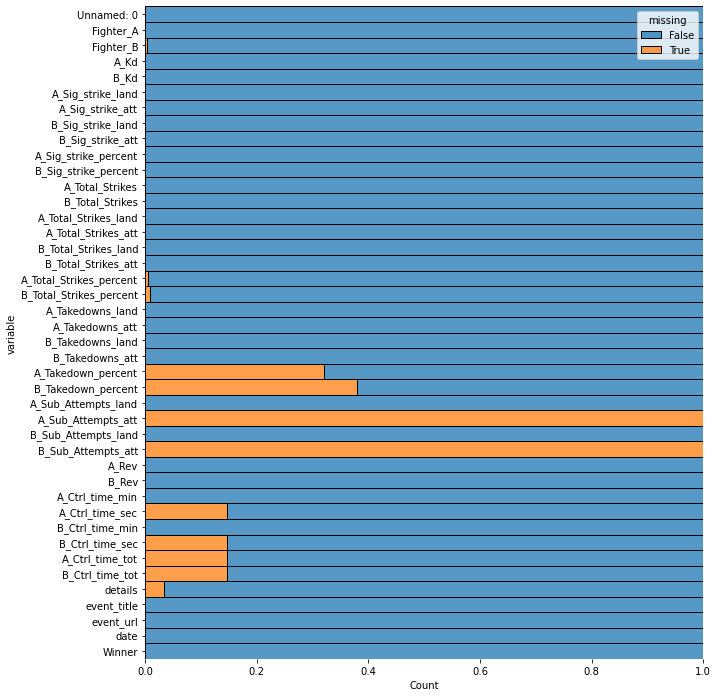

In [4]:
f, ax = plt.subplots(figsize = (10,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = all_fight_totals.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [9]:
# need a DF that includes all fights, regardless of whether they have all stats or not
all_fights_no_drops = all_fight_totals.copy()

In [10]:
# drop sub attempts_att
all_fight_totals.drop(columns = ['A_Sub_Attempts_att', 'B_Sub_Attempts_att'], inplace=True)

In [11]:
# drop if no fighter name
all_fight_totals.dropna(subset=['Fighter_A', 'Fighter_B'], inplace=True)
# replace na with 0 for rest
all_fight_totals.fillna(0, inplace=True)
all_fight_totals

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,A_Ctrl_time_sec,B_Ctrl_time_min,B_Ctrl_time_sec,A_Ctrl_time_tot,B_Ctrl_time_tot,details,event_title,event_url,date,Winner
0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,...,16.0,0,3.0,316.0,3.0,Mike Bell ...,UFC Fight Night: Holm vs. Aldana,http://www.ufcstats.com/event-details/805ad180...,"October 03, 2020",Holly Holm
1,0,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,...,45.0,3,10.0,405.0,190.0,Abe Belardo ...,UFC 61: Bitter Rivals,http://www.ufcstats.com/event-details/f70144ca...,"July 08, 2006",Joshua Burkman
2,0,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,...,53.0,2,43.0,53.0,163.0,Rear Naked Choke,UFC Fight Night: Volkov vs. Aspinall,http://www.ufcstats.com/event-details/1d007568...,"March 19, 2022",Paddy Pimblett
3,0,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,...,0.0,0,0.0,0.0,0.0,Illegal Inhaler Use by Hardy La...,UFC Fight Night: Reyes vs. Weidman,http://www.ufcstats.com/event-details/3ae10ac4...,"October 18, 2019",Ben Sosoli
4,0,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,...,19.0,0,0.0,319.0,0.0,Punches to Head From Side Control,UFC 185: Pettis vs Dos Anjos,http://www.ufcstats.com/event-details/f54200f1...,"March 14, 2015",Jared Rosholt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8299,0,Rodrigo Gracie,Daiju Takase,0,0,39,65,10,27,0.60,...,0.0,0,0.0,0.0,0.0,0,PRIDE Bushido 1,http://www.ufcstats.com/event-details/cb46dfac...,"October 05, 2003",Rodrigo Gracie
8300,0,Tim Sylvia,Wesley Correira,0,0,138,214,26,65,0.64,...,3.0,0,0.0,3.0,0.0,to Corner Stoppage,UFC 39: The Warriors Return,http://www.ufcstats.com/event-details/0cf93551...,"September 27, 2002",Tim Sylvia
8301,0,Kimo Leopoldo,David Abbott,0,0,1,1,0,0,1.00,...,52.0,0,1.0,112.0,1.0,Arm Triangle From Mount,UFC 43: Meltdown,http://www.ufcstats.com/event-details/108afe61...,"June 06, 2003",Kimo Leopoldo
8302,0,Tony Ferguson,Gleison Tibau,0,0,11,38,2,20,0.28,...,45.0,0,0.0,45.0,0.0,Rear Naked Choke,UFC 184: Rousey vs Zingano,http://www.ufcstats.com/event-details/ad4e9055...,"February 28, 2015",Tony Ferguson


<AxesSubplot:xlabel='Count', ylabel='variable'>

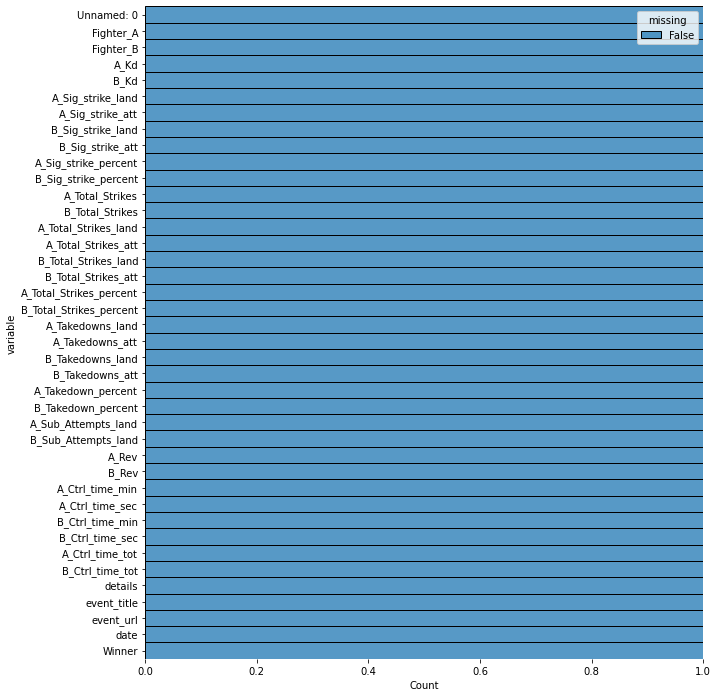

In [7]:
f, ax = plt.subplots(figsize = (10,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = all_fight_totals.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [12]:
all_sig_strikes = []
for f in sig_strikes:
    df = pd.read_csv('data/ufc_stats/sig_strikes/' + f)
    all_sig_strikes.append(df)

all_sig_strikes = pd.concat(all_sig_strikes, ignore_index=True)
all_sig_strikes

,Unnamed: 0,Fighter_A,Fighter_B,A_Head_Strikes_land,A_Head_Strikes_att,B_Head_Strikes_land,B_Head_Strikes_att,A_Head_Strikes_percent,B_Head_Strikes_percent,A_Body_Strikes_land,...,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,details,event_title,event_url
0,0,Holly Holm,Irene Aldana,81,214,38,128,0.378505,0.296875,56,...,1.000000,13,28,0,0,0.464286,NaN,Mike Bell ...,UFC Fight Night: Holm vs. Aldana,http://www.ufcstats.com/event-details/805ad180...
1,0,Joshua Burkman,Josh Neer,22,72,17,36,0.305556,0.472222,9,...,0.555556,5,10,7,9,0.500000,0.777778,Abe Belardo ...,UFC 61: Bitter Rivals,http://www.ufcstats.com/event-details/f70144ca...
2,0,Paddy Pimblett,Kazula Vargas,1,4,5,7,0.250000,0.714286,0,...,1.000000,1,1,3,3,1.000000,1.000000,Rear Naked Choke,UFC Fight Night: Volkov vs. Aspinall,http://www.ufcstats.com/event-details/1d007568...
3,0,Greg Hardy,Ben Sosoli,22,72,15,78,0.305556,0.192308,5,...,0.000000,0,0,0,0,NaN,NaN,Illegal Inhaler Use by Hardy La...,UFC Fight Night: Reyes vs. Weidman,http://www.ufcstats.com/event-details/3ae10ac4...
4,0,Jared Rosholt,Josh Copeland,19,41,7,34,0.463415,0.205882,3,...,0.375000,10,17,0,0,0.588235,NaN,Punches to Head From Side Control,UFC 185: Pettis vs Dos Anjos,http://www.ufcstats.com/event-details/f54200f1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8299,0,Rodrigo Gracie,Daiju Takase,25,50,6,17,0.500000,0.352941,12,...,0.428571,23,37,3,3,0.621622,1.000000,NaN,PRIDE Bushido 1,http://www.ufcstats.com/event-details/cb46dfac...
8300,0,Tim Sylvia,Wesley Correira,115,186,21,60,0.618280,0.350000,13,...,0.666667,0,0,0,0,NaN,NaN,to Corner Stoppage,UFC 39: The Warriors Return,http://www.ufcstats.com/event-details/0cf93551...
8301,0,Kimo Leopoldo,David Abbott,0,0,0,0,NaN,NaN,1,...,NaN,0,0,0,0,NaN,NaN,Arm Triangle From Mount,UFC 43: Meltdown,http://www.ufcstats.com/event-details/108afe61...
8302,0,Tony Ferguson,Gleison Tibau,5,27,2,18,0.185185,0.111111,3,...,NaN,3,8,0,0,0.375000,NaN,Rear Naked Choke,UFC 184: Rousey vs Zingano,http://www.ufcstats.com/event-details/ad4e9055...


In [13]:
all_sig_strikes_no_drops = all_sig_strikes.copy()

In [15]:
# save no_drops versions
all_sig_strikes_no_drops.to_csv('data/final/all_sig_strikes_no_drops.csv')
all_fights_no_drops.to_csv('data/final/all_fight_totals_no_drops.csv')

In [7]:
# load no_drops versions
all_sig_strikes_no_drops = pd.read_csv('data/final/all_sig_strikes_no_drops.csv')
all_fights_no_drops = pd.read_csv('data/final/all_fight_totals_no_drops.csv')

In [2]:
all_fight_totals = pd.read_csv('data/ufc_stats/agg2/all_fight_totals.csv')
all_sig_strikes = pd.read_csv('data/ufc_stats/agg2/all_significant_strikes.csv')

In [3]:
all_sig_strikes.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Fighter_A', 'Fighter_B',
       'A_Head_Strikes_land', 'A_Head_Strikes_att', 'B_Head_Strikes_land',
       'B_Head_Strikes_att', 'A_Head_Strikes_percent',
       'B_Head_Strikes_percent', 'A_Body_Strikes_land', 'A_Body_Strikes_att',
       'B_Body_Strikes_land', 'B_Body_Strikes_att', 'A_Body_Strikes_percent',
       'B_Body_Strikes_percent', 'A_Leg_Strikes_land', 'A_Leg_Strikes_att',
       'B_Leg_Strikes_land', 'B_Leg_Strikes_att', 'A_Leg_Strikes_percent',
       'B_Leg_Strikes_percent', 'A_Distance_Strikes_land',
       'A_Distance_Strikes_att', 'B_Distance_Strikes_land',
       'B_Distance_Strikes_att', 'A_Distance_Strikes_percent',
       'B_Distance_Strikes_percent', 'A_Clinch_Strikes_land',
       'A_Clinch_Strikes_att', 'B_Clinch_Strikes_land', 'B_Clinch_Strikes_att',
       'A_Clinch_Strikes_percent', 'B_Clinch_Strikes_percent',
       'A_Ground_Strikes_land', 'A_Ground_Strikes_att',
       'B_Ground_Strikes_land', 'B_Ground_Strikes_att',
 

In [ ]:
# drop details from all_sig_strikes
all_sig_strikes.drop(columns = ['details', 'Unnamed: 0'], inplace=True)
all_sig_strikes_no_drops.drop(columns = ['details', 'Unnamed: 0'], inplace=True)

In [18]:
# get columns in both dfs
cols = [n for n in all_sig_strikes.columns if n in all_fight_totals.columns]
cols

['Fighter_A', 'Fighter_B', 'event_title', 'event_url']

In [10]:
# drop Unnamed cols in no_drop
all_sig_strikes_no_drops.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'details'], inplace=True)
all_fights_no_drops.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [11]:
# for no_drop version
cols = [n for n in all_sig_strikes_no_drops.columns if n in all_fights_no_drops.columns]
cols

['Fighter_A', 'Fighter_B', 'event_title', 'event_url']

In [12]:
# merge no drops version
all_fights_no_drops = pd.merge(all_fights_no_drops, all_sig_strikes_no_drops, on= cols, how='left')
print(all_fights_no_drops.shape)

(8306, 77)


In [13]:
all_fights_no_drops['date'] = pd.to_datetime(all_fights_no_drops['date']).dt.date

In [7]:
# merge
print(all_sig_strikes.shape)
print(all_fight_totals.shape)
fightz = pd.merge(all_fight_totals, all_sig_strikes, on= cols, how='left')
print(fightz.shape)

(8304, 40)
(8284, 41)
(8286, 77)


In [9]:
fightz['date'] = pd.to_datetime(fightz['date']).dt.date
fightz

,Unnamed: 0.1,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,...,4.0,4.0,1.000000,1.000000,13.0,28.0,0.0,0.0,0.464286,NaN
1,1,0,Joshua Burkman,Josh Neer,1,0,35,88,19,39,...,5.0,9.0,0.571429,0.555556,5.0,10.0,7.0,9.0,0.500000,0.777778
2,2,0,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,...,2.0,2.0,0.000000,1.000000,1.0,1.0,3.0,3.0,1.000000,1.000000
3,3,0,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,...,0.0,1.0,1.000000,0.000000,0.0,0.0,0.0,0.0,NaN,NaN
4,4,0,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,...,3.0,8.0,0.750000,0.375000,10.0,17.0,0.0,0.0,0.588235,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8281,8299,0,Rodrigo Gracie,Daiju Takase,0,0,39,65,10,27,...,6.0,14.0,0.650000,0.428571,23.0,37.0,3.0,3.0,0.621622,1.000000
8282,8300,0,Tim Sylvia,Wesley Correira,0,0,138,214,26,65,...,2.0,3.0,0.796610,0.666667,0.0,0.0,0.0,0.0,NaN,NaN
8283,8301,0,Kimo Leopoldo,David Abbott,0,0,1,1,0,0,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN
8284,8302,0,Tony Ferguson,Gleison Tibau,0,0,11,38,2,20,...,0.0,0.0,NaN,NaN,3.0,8.0,0.0,0.0,0.375000,NaN


In [10]:
fightz = fightz.sort_values(by='date', ascending=False)

In [11]:
fightz = fightz.drop(columns = ['A_Total_Strikes', 'B_Total_Strikes'])

In [12]:
fightz.to_csv('data/ufc_stats/agg2/all_fights_9_27.csv')

In [14]:
fights = pd.read_csv('data/ufc_stats/agg2/all_fights_9_27.csv')

In [15]:
fights.head(3)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,6735,6751,0,Anthony Hernandez,Marc-Andre Barriault,0,0,39,60,25,...,10.0,11.0,0.666667,0.909091,13.0,13.0,0.0,0.0,1.0,NaN
1,2024,2027,0,Tanner Boser,Rodrigo Nascimento,0,0,62,115,36,...,4.0,4.0,1.000000,1.000000,2.0,2.0,2.0,2.0,1.0,1.0
2,737,739,0,Joe Pyfer,Alen Amedovski,1,0,14,45,11,...,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,NaN


# Part 2: Add Features

The features to be added include:
- Odds by fight
- Statistical Differences
- The Average, Minimum, Maximum, Median, and Standard Deviation of each of the metrics included in the original data
- Bio data that includes height, weight, reach, and leg reach

## Scraping Fighter Odds
Odds can be scraped from bestfightodds.com


In [52]:
a = pd.DataFrame(fights['Fighter_A'].unique())
b = pd.DataFrame(fights['Fighter_B'].unique())
# append together
c = a.append(b)
# drop duplicates
d = c.drop_duplicates()
d

,0
0,Jailton Almeida
1,Irene Aldana
2,Chad Anheliger
3,Johnny Walker
4,Nate Diaz
...,...
2208,Jerry Bohlander
2209,Townsend Saunders
2210,Adriano Santos
2211,Braga Jeremy


In [53]:
d['odds_search'] = 'https://www.bestfightodds.com/search?query=' + d[0]
d

,0,odds_search
0,Jailton Almeida,https://www.bestfightodds.com/search?query=Jai...
1,Irene Aldana,https://www.bestfightodds.com/search?query=Ire...
2,Chad Anheliger,https://www.bestfightodds.com/search?query=Cha...
3,Johnny Walker,https://www.bestfightodds.com/search?query=Joh...
4,Nate Diaz,https://www.bestfightodds.com/search?query=Nat...
...,...,...
2208,Jerry Bohlander,https://www.bestfightodds.com/search?query=Jer...
2209,Townsend Saunders,https://www.bestfightodds.com/search?query=Tow...
2210,Adriano Santos,https://www.bestfightodds.com/search?query=Adr...
2211,Braga Jeremy,https://www.bestfightodds.com/search?query=Bra...


In [59]:
def get_fighter_odds_page(fighter_odds_search_url):
    try:
        page = requests.get(fighter_odds_search_url)
        soup = BeautifulSoup(page.content, 'html.parser')
        event_odds_url = soup.findAll('table', class_='content-list')[0].findAll('a')[0]['href']
        return event_odds_url
    except:
        return nan

In [60]:
d['fighter_odds_url'] = d.apply(lambda row: get_fighter_odds_page(row['odds_search']), axis = 1)

In [62]:
d.to_csv('data/ufc_BestFightOdds/all_fighters_odds_urls.csv')

#### Scrape Fighter Odds

In [132]:
def get_fighter_odds_career(fighter_odds_url):
    try:
        url = 'https://www.bestfightodds.com' + str(fighter_odds_url)
        header = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest"
    }
        r = requests.get(url, headers = header)
        dfs = pd.read_html(r.text)

        data = dfs[0]
        keep_cols = ['Matchup' , 'Closing range']
        data2 = data[keep_cols]

        fighter_odds = []
        event = data2.iloc[::3, :1]
        i = 0
        for e in event['Matchup']:
            fighter_A = str(data2.iloc[1::3, :1].values[i]).replace('[', '').replace(']', '').replace("'", '').replace('"', '')
            fighter_B = str(data2.iloc[2::3, :1].values[i]).replace('[', '').replace(']', '').replace("'", '').replace('"', '')
            fighter_A_odds = str(data2.iloc[1::3, 1:2].values[i].astype(np.float64)).replace('[', '').replace(']', '').replace('.', '')
            fighter_B_odds = str(data2.iloc[2::3, 1:2].values[i].astype(np.float64)).replace('[', '').replace(']', '').replace('.', '')

            fighter_odds.append([e, fighter_A, fighter_A_odds, fighter_B, fighter_B_odds])
            i += 1

        
        f = pd.DataFrame(fighter_odds, columns = ['event', 'fighter_A', 'fighter_A_odds', 'fighter_B', 'fighter_B_odds'])
        fighterrr = f['fighter_A'].values[0]
        f.to_csv('data/ufc_BestFightOdds/odds_by_fighter/' + fighterrr + '.csv')
        return f
    except:
        return nan


In [133]:
for f in d['fighter_odds_url']:
    if f is not nan:
        get_fighter_odds_career(f)

In [134]:
odds_by_fighter_files = os.listdir('data/ufc_BestFightOdds/odds_by_fighter/')
#append them
odds_by_fighter = []
for f in odds_by_fighter_files:
    data = pd.read_csv('data/ufc_BestFightOdds/odds_by_fighter/' + f)
    odds_by_fighter.append(data)

odds_by_fighter = pd.concat(odds_by_fighter)
odds_by_fighter

,Unnamed: 0,event,fighter_A,fighter_A_odds,fighter_B,fighter_B_odds
0,0,UFC 281 Oct 22nd 2022,A.J. Dobson,176.0,Armen Petrosyan,-235.0
1,1,LFA 101: The Undefeated Mar 12th 2021,A.J. Dobson,NaN,Maika Graf,NaN
0,0,UFC 278: Usman vs. Edwards 2 Aug 20th 2022,A.J. Fletcher,-175.0,Ange Loosa,130.0
1,1,UFC Mar 12th 2022,A.J. Fletcher,145.0,Matthew Semelsberger,-200.0
2,2,DWCS Week 1 Aug 31st 2021,A.J. Fletcher,-190.0,Leonardo Damiani,120.0
...,...,...,...,...,...,...
5,5,Fight Nights Global 88: Battle on Esil Aug 31s...,Zhalgas Zhumagulov,375.0,Tagir Ulanbekov,-515.0
6,6,Fight Nights Global 86: Zhumagulov vs. Nam Apr...,Zhalgas Zhumagulov,NaN,Tyson Nam,NaN
0,0,UFC Fight Night: Costa vs. Vettori Oct 23rd 2021,Zviad Lazishvili,-125.0,Jonathan Martinez,-118.0
1,1,LFA 90: Lazishvili vs. Steele Sep 4th 2020,Zviad Lazishvili,185.0,Ricky Steele,-230.0


In [14]:
odds_by_fighter['fighters'] = odds_by_fighter['fighter_A'] + ' vs ' + odds_by_fighter['fighter_B']

In [15]:
odds_by_fighter.to_csv('data/ufc_BestFightOdds/odds_by_fighter_ALL.csv')

#### Load Point Odds_by_Fighter

To be utilized if you want to skip to this point.

In [14]:
odds_by_fighter = pd.read_csv('data/ufc_BestFightOdds/odds_by_fighter_ALL.csv')

In [130]:
odds_by_fighter.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,event,fighter_A,fighter_A_odds,fighter_B,fighter_B_odds,fighters
0,0,0,0,UFC 281 Oct 22nd 2022,A.J. Dobson,176.0,Armen Petrosyan,-235.0,A.J. Dobson vs Armen Petrosyan
1,1,1,1,LFA 101: The Undefeated Mar 12th 2021,A.J. Dobson,NaN,Maika Graf,NaN,A.J. Dobson vs Maika Graf
2,2,0,0,UFC 278: Usman vs. Edwards 2 Aug 20th 2022,A.J. Fletcher,-175.0,Ange Loosa,130.0,A.J. Fletcher vs Ange Loosa
3,3,1,1,UFC Mar 12th 2022,A.J. Fletcher,145.0,Matthew Semelsberger,-200.0,A.J. Fletcher vs Matthew Semelsberger
4,4,2,2,DWCS Week 1 Aug 31st 2021,A.J. Fletcher,-190.0,Leonardo Damiani,120.0,A.J. Fletcher vs Leonardo Damiani


In [15]:
def get_odds_from_obf(fighter_A, fighter_B):
    # Function to get odds from odds_by_fighter dataframe by fighter A and fighter B
    try:
        data = odds_by_fighter[(odds_by_fighter['fighter_A'] == fighter_A) & (odds_by_fighter['fighter_B'] == fighter_B)]
        odds = data['fighter_A_odds'].values[0]
        return odds
    except:
        return nan

In [21]:
# add odds to the fights df
fights['Fighter_A_Odds_obf'] = fights.apply(lambda row: get_odds_from_obf(row['Fighter_A'], row['Fighter_B']), axis = 1)
fights['Fighter_B_Odds_obf'] = fights.apply(lambda row: get_odds_from_obf(row['Fighter_B'], row['Fighter_A']), axis = 1)

In [16]:
# add odds to the no-drop version of fights
all_fights_no_drops['Fighter_A_Odds_obf'] = all_fights_no_drops.apply(lambda row: get_odds_from_obf(row['Fighter_A'], row['Fighter_B']), axis = 1)
all_fights_no_drops['Fighter_B_Odds_obf'] = all_fights_no_drops.apply(lambda row: get_odds_from_obf(row['Fighter_B'], row['Fighter_A']), axis = 1)

In [17]:
all_fights_no_drops.to_csv('data/final/all_fights_no_drops_V1.csv')

In [4]:
# load all_fights_no_drops
all_fights_no_drops = pd.read_csv('data/final/all_fights_no_drops_V1.csv')

In [ ]:
# drop nas
fights.dropna(subset = ['Fighter_A_Odds_obf', 'Fighter_B_Odds_obf'], inplace = True)

In [28]:
unnamed = [n for n in fights.columns if 'Unnamed' in n]
fights.drop(columns = unnamed, inplace = True)

In [29]:
fights.columns[0:40]

Index(['Fighter_A', 'Fighter_B', 'A_Kd', 'B_Kd', 'A_Sig_strike_land',
       'A_Sig_strike_att', 'B_Sig_strike_land', 'B_Sig_strike_att',
       'A_Sig_strike_percent', 'B_Sig_strike_percent', 'A_Total_Strikes_land',
       'A_Total_Strikes_att', 'B_Total_Strikes_land', 'B_Total_Strikes_att',
       'A_Total_Strikes_percent', 'B_Total_Strikes_percent',
       'A_Takedowns_land', 'A_Takedowns_att', 'B_Takedowns_land',
       'B_Takedowns_att', 'A_Takedown_percent', 'B_Takedown_percent',
       'A_Sub_Attempts_land', 'B_Sub_Attempts_land', 'A_Rev', 'B_Rev',
       'A_Ctrl_time_min', 'A_Ctrl_time_sec', 'B_Ctrl_time_min',
       'B_Ctrl_time_sec', 'A_Ctrl_time_tot', 'B_Ctrl_time_tot', 'details',
       'event_title', 'event_url', 'date', 'Winner', 'A_Head_Strikes_land',
       'A_Head_Strikes_att', 'B_Head_Strikes_land'],
      dtype='object')

In [30]:
# change NAs to 0
fights.fillna(0, inplace = True)

## Calculate In-Fight Stat Differentials

In [36]:
fights['Fighter_A_Odds_obf'] = fights['Fighter_A_Odds_obf'].astype(np.float64)
fights['Fighter_B_Odds_obf'] = fights['Fighter_B_Odds_obf'].astype(np.float64)

In [6]:
all_fights_no_drops['Fighter_A_Odds_obf'] = all_fights_no_drops['Fighter_A_Odds_obf'].astype(np.float64)
all_fights_no_drops['Fighter_B_Odds_obf'] = all_fights_no_drops['Fighter_B_Odds_obf'].astype(np.float64)

### Calculate Difference between in-match statistics

In [25]:
# calculate differences between in-match stats
def calc_diffs(row):
    for col in fights.columns:
        if 'A_' in col:
            new_col = col.replace('A_', 'Dif_')
            fights[new_col] = fights[col] - fights[col.replace('A_', 'B_')]
    return fights

#### Fix Career Stats - Winner

In [94]:
files = os.listdir('data/ufc_stats/fighters2/')

In [105]:
# this deletes the nicknames from the winner column
for file in files:
    data = pd.read_csv('data/ufc_stats/fighters2/' + file)
    data['Winner'] = data['Winner'].str.split('"').str[0]
    data['Winner'] = data['Winner'].str.strip()
    data.to_csv('data/ufc_stats/fighters2/' + file)

### Add AVG and Distribution Features

In [26]:
# for each column in all_metric_cols, get the mean, std, etc. for each fighter
def get_fighter_running_dist_stats(fighter, date, col_to_get, stat_to_calc):
    data = fights[(fights['Fighter_A'] == fighter) | (fights['Fighter_B'] == fighter)]
    # only get fights before the date
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]
    # fighter could be either fighter A or fighter B
    fighter_data = pd.DataFrame()
    # when fighter is fighter A, get all fighter A data and copy it to fighter_data
    # fighterA df
    fighterA_df = fights[fights['Fighter_A'] == fighter]
    fighterB_df = fights[fights['Fighter_B'] == fighter]
    # keep only the fighters columns date, FighterA, and the col_to_get, do same for B, change col names from B to A, and concat
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)
    # append the dataframes on fighter
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)
    # make sure the date is before the date of the fight
    # get the average
    if stat_to_calc == 'mean':
        x = fighter_data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = fighter_data[col_to_get].std()
    elif stat_to_calc == 'max':
        x = fighter_data[col_to_get].max()
    elif stat_to_calc == 'min':
        x = fighter_data[col_to_get].min()
    elif stat_to_calc == 'median':
        x = fighter_data[col_to_get].median()  
    return x

In [8]:
# for each column in all_metric_cols, get the mean, std, etc. for each fighter
def get_fighter_running_dist_stats_nodrop(fighter, date, col_to_get, stat_to_calc):
    data = all_fights_no_drops[(all_fights_no_drops['Fighter_A'] == fighter) | (all_fights_no_drops['Fighter_B'] == fighter)]
    # only get fights before the date
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]
    # fighter could be either fighter A or fighter B
    fighter_data = pd.DataFrame()
    # when fighter is fighter A, get all fighter A data and copy it to fighter_data
    # fighterA df
    fighterA_df = all_fights_no_drops[all_fights_no_drops['Fighter_A'] == fighter]
    fighterB_df = all_fights_no_drops[all_fights_no_drops['Fighter_B'] == fighter]
    # keep only the fighters columns date, FighterA, and the col_to_get, do same for B, change col names from B to A, and concat
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)
    # append the dataframes on fighter
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)
    # make sure the date is before the date of the fight
    # get the average
    if stat_to_calc == 'mean':
        x = fighter_data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = fighter_data[col_to_get].std()
    elif stat_to_calc == 'max':
        x = fighter_data[col_to_get].max()
    elif stat_to_calc == 'min':
        x = fighter_data[col_to_get].min()
    elif stat_to_calc == 'median':
        x = fighter_data[col_to_get].median()  
    return x

In [110]:
def get_career_fighter_running_dist_stats(data, col_to_get, stat_to_calc):
    if stat_to_calc == 'mean':
        x = data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = data[col_to_get].std()
    elif stat_to_calc == 'max':
        x = data[col_to_get].max()
    elif stat_to_calc == 'min':
        x = data[col_to_get].min()
    elif stat_to_calc == 'median':
        x = data[col_to_get].median()  
    return x

#### Get non-specific column names for feature creation

In [ ]:
dif_cols = [n for n in fights.columns if 'Dif_' in n]
A_cols = [n for n in fights.columns if n.startswith('A_')]
all_metric_cols = A_cols + dif_cols
A_cols2 = pd.DataFrame(A_cols)
A_cols2['nonspecific'] = A_cols2[0].str[2:]
the_cols = list(A_cols2['nonspecific'].unique())

In [52]:
for col in the_cols:
    for stat in ['mean', 'std', 'max', 'min', 'median']:
        fights['A_Rolling_' + col + '_' + stat] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, stat), axis=1)
        fights['B_Rolling_' + col + '_' + stat] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, stat), axis=1)

In [11]:
all_fights_no_drops.drop(columns=['A_Total_Strikes', 'B_Total_Strikes'], inplace=True)

In [12]:
all_fights_no_drops.to_csv('all_fights_no_drops_V2.csv', index=False)

In [7]:
# load point
all_fights_no_drops = pd.read_csv('all_fights_no_drops_V2.csv')

In [9]:
# same for all_fights_no_drops
dif_cols = [n for n in all_fights_no_drops.columns if 'Dif_' in n]
A_cols = [n for n in all_fights_no_drops.columns if n.startswith('A_')]
all_metric_cols = A_cols + dif_cols
A_cols2 = pd.DataFrame(A_cols)
A_cols2['nonspecific'] = A_cols2[0].str[2:]
the_cols = list(A_cols2['nonspecific'].unique())

In [10]:
n = 0
for col in the_cols:
    for stat in ['mean', 'std', 'max', 'min', 'median']:
        all_fights_no_drops['A_Rolling_' + col + '_' + stat] = all_fights_no_drops.apply(lambda row: get_fighter_running_dist_stats_nodrop(row['Fighter_A'], row['date'], col, stat), axis=1)
        all_fights_no_drops['B_Rolling_' + col + '_' + stat] = all_fights_no_drops.apply(lambda row: get_fighter_running_dist_stats_nodrop(row['Fighter_B'], row['date'], col, stat), axis=1)
        n = n+1
        print(f' {col} {stat} done. Number left: {169- n}')

 Kd mean done. Number left: 339
 Kd std done. Number left: 338
 Kd max done. Number left: 337
 Kd min done. Number left: 336
 Kd median done. Number left: 335
 Sig_strike_land mean done. Number left: 334
 Sig_strike_land std done. Number left: 333
 Sig_strike_land max done. Number left: 332
 Sig_strike_land min done. Number left: 331
 Sig_strike_land median done. Number left: 330
 Sig_strike_att mean done. Number left: 329
 Sig_strike_att std done. Number left: 328
 Sig_strike_att max done. Number left: 327
 Sig_strike_att min done. Number left: 326
 Sig_strike_att median done. Number left: 325
 Sig_strike_percent mean done. Number left: 324
 Sig_strike_percent std done. Number left: 323
 Sig_strike_percent max done. Number left: 322
 Sig_strike_percent min done. Number left: 321
 Sig_strike_percent median done. Number left: 320
 Total_Strikes_land mean done. Number left: 319
 Total_Strikes_land std done. Number left: 318
 Total_Strikes_land max done. Number left: 317
 Total_Strikes_la

### Copy DF and Switch stats
This is so each fighter can be both fighter A and fighter B, so we can calculate from both sides, as we solve for Fighter A.

In [ ]:
df_2 = fights.copy()

df_2['Fighter_A'] = fights['Fighter_B']
df_2['Fighter_B'] = fights['Fighter_A']

fighter_cols = [n for n in fights.columns if 'A' in n] + [n for n in fights.columns if 'B' in n]

In [58]:
fighter_cols.remove('Fighter_A')
fighter_cols.remove('Fighter_B')

# append df_2 to df
fights = fights.append(df_2, ignore_index=True)
fights.shape

In [69]:
unnamed = [n for n in fights.columns if 'Unnamed' in n]
fights.drop(columns=unnamed, inplace=True)

### Copy DF and Switch Stats for No_Drop version

In [10]:
dff2 = all_fights_no_drops.copy()

dff2['Fighter_A'] = all_fights_no_drops['Fighter_B']
dff2['Fighter_B'] = all_fights_no_drops['Fighter_A']

fighter_cols = [n for n in all_fights_no_drops.columns if 'A' in n] + [n for n in all_fights_no_drops.columns if 'B' in n]

fighter_cols.remove('Fighter_A')
fighter_cols.remove('Fighter_B')

# append df_2 to df
all_fights_no_drops = all_fights_no_drops.append(dff2, ignore_index=True)
all_fights_no_drops.shape


(16612, 419)

In [11]:
unnamed = [n for n in all_fights_no_drops.columns if 'Unnamed' in n]
all_fights_no_drops.drop(columns=unnamed, inplace=True)

### Add: Rolling Career Stats Difs

- A_avg - B_avg
- A_median - B_median 
- A_stdev - B_stdev
- Floor Stats [(A_avg - A_std) - (B_avg - B_std)]
- Min Stats [(A_min - B_min)]
- Max Stats [(A_max - B_max)]



#### Mean

In [16]:
# get columns with Rolling and Mean
rolling_mean_cols= [n for n in fights.columns if 'Rolling' in n and 'mean' in n]
rolling_mean_cols = pd.DataFrame(rolling_mean_cols)
rolling_mean_cols['nonspecific'] = rolling_mean_cols[0].str[2:]
rmc = rolling_mean_cols['nonspecific'].unique()

array(['Rolling_Sig_Strike_Percent_mean', 'Rolling_Kd_mean',
       'Rolling_Sig_strike_percent_mean', 'Rolling_Takedown_percent_mean',
       'Rolling_Sub_Attempts_mean', 'Rolling_Rev_mean',
       'Rolling_Ctrl_time_mean', 'Rolling_Sig_Strike_land_mean',
       'Rolling_Sig_Strike_att_mean', 'Rolling_Sig_Strike_percent_mean',
       'Rolling_Head_Strikes_land_mean', 'Rolling_Head_Strikes_att_mean',
       'Rolling_Head_Strikes_percent_mean',
       'Rolling_Body_Strikes_land_mean', 'Rolling_Body_Strikes_att_mean',
       'Rolling_Body_Strikes_percent_mean',
       'Rolling_Leg_Strikes_land_mean', 'Rolling_Leg_Strikes_att_mean',
       'Rolling_Leg_Strikes_percent_mean',
       'Rolling_Distance_Strikes_land_mean',
       'Rolling_Distance_Strikes_att_mean',
       'Rolling_Distance_Strikes_percent_mean',
       'Rolling_Clintch_Strikes_land_mean',
       'Rolling_Clintch_Strikes_att_mean',
       'Rolling_Clintch_Strikes_percent_mean',
       'Rolling_Ground_Strikes_land_mean',
     

In [17]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,details,event_title,event_url,date,event_id,A_Kd,B_Kd,...,Dif_Rolling_Distance_Strikes_percent_mean,Dif_Rolling_Clintch_Strikes_land_mean,Dif_Rolling_Clintch_Strikes_att_mean,Dif_Rolling_Clintch_Strikes_percent_mean,Dif_Rolling_Ground_Strikes_land_mean,Dif_Rolling_Ground_Strikes_att_mean,Dif_Rolling_Ground_Strikes_percent_mean,Dif_Rolling_Total_Strikes_land_mean,Dif_Rolling_Total_Strikes_att_mean,Dif_Rolling_Total_Strikes_percent_mean
0,0,Jailton Almeida,Anton Turkalj,Rear Naked Choke,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,301f230c90c4bd7d,0,0,...,-50.000000,0.000000,0.000000,0.000000,17.000000,27.000000,66.235000,10.500000,22.500000,-18.230000
1,1,Irene Aldana,Macy Chiasson,Kick to Body From Bottom,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,989b8d362742f40b,1,0,...,1.433889,-6.822222,-9.622222,16.706333,-3.333333,-8.800000,-11.443111,7.455556,61.944444,-12.948333
2,2,Nate Diaz,Tony Ferguson,Guillotine Choke From Bottom Guard,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,7e8fd03e070d0c25,0,0,...,-3.358739,8.004202,10.613445,24.092899,-0.138655,0.710084,-11.567269,24.638655,21.100840,10.673866
3,3,Khamzat Chimaev,Kevin Holland,D'Arce Choke On Ground,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,0111e6a64b5184c6,0,0,...,-4.713143,-1.228571,-2.614286,-33.161000,12.157143,18.571429,-3.038143,-15.085714,-15.785714,-2.014429
4,4,Jake Collier,Chris Barnett,Punches to Head From Mount,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,bf334cb4e63f3430,1,0,...,-7.702667,3.666667,4.766667,-1.216667,-10.033333,-16.566667,-7.383000,11.033333,43.800000,-6.777333


#### Mean - No Drops Version

In [13]:
# get cols with rolling and mean
rolling_mean_cols= [n for n in all_fights_no_drops.columns if 'Rolling' in n and 'mean' in n]
rolling_mean_cols = pd.DataFrame(rolling_mean_cols)
rolling_mean_cols['nonspecific'] = rolling_mean_cols[0].str[2:]
rmc = rolling_mean_cols['nonspecific'].unique()

In [14]:
for col in rmc:
    all_fights_no_drops['Dif_' + col] = all_fights_no_drops['A_' + col] - all_fights_no_drops['B_' + col]

#### Median

In [ ]:
rolling_median_cols= [n for n in fights.columns if 'Rolling' in n and 'median' in n]
rolling_median_cols = pd.DataFrame(rolling_median_cols)
rolling_median_cols['nonspecific'] = rolling_median_cols[0].str[2:]
rmc = rolling_median_cols['nonspecific'].unique()

In [19]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,details,event_title,event_url,date,event_id,A_Kd,B_Kd,...,Dif_Rolling_Distance_Strikes_percent_median,Dif_Rolling_Clintch_Strikes_land_median,Dif_Rolling_Clintch_Strikes_att_median,Dif_Rolling_Clintch_Strikes_percent_median,Dif_Rolling_Ground_Strikes_land_median,Dif_Rolling_Ground_Strikes_att_median,Dif_Rolling_Ground_Strikes_percent_median,Dif_Rolling_Total_Strikes_land_median,Dif_Rolling_Total_Strikes_att_median,Dif_Rolling_Total_Strikes_percent_median
0,0,Jailton Almeida,Anton Turkalj,Rear Naked Choke,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,301f230c90c4bd7d,0,0,...,-50.000,0.0,0.0,0.000,17.0,27.0,66.235,10.5,22.5,-18.230
1,1,Irene Aldana,Macy Chiasson,Kick to Body From Bottom,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,989b8d362742f40b,1,0,...,3.930,-2.0,-2.0,9.085,-1.5,-2.5,-33.335,16.0,93.0,-14.810
2,2,Nate Diaz,Tony Ferguson,Guillotine Choke From Bottom Guard,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,7e8fd03e070d0c25,0,0,...,-2.965,5.0,6.0,23.075,0.0,0.0,-18.755,4.5,8.5,8.380
3,3,Khamzat Chimaev,Kevin Holland,D'Arce Choke On Ground,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,0111e6a64b5184c6,0,0,...,-3.840,-2.0,-3.0,-65.715,6.0,14.5,-6.170,3.5,-5.5,-4.620
4,4,Jake Collier,Chris Barnett,Punches to Head From Mount,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,bf334cb4e63f3430,1,0,...,-10.600,1.0,-0.5,19.050,-9.0,-17.0,-52.940,10.5,13.0,-12.015


#### Median: No drops Version

In [15]:
rolling_median_cols = [n for n in all_fights_no_drops.columns if 'Rolling' in n and 'median' in n]
rolling_median_cols = pd.DataFrame(rolling_median_cols)
rolling_median_cols['nonspecific'] = rolling_median_cols[0].str[2:]
rmc = rolling_median_cols['nonspecific'].unique()

In [16]:
for col in rmc:
    all_fights_no_drops['Dif_' + col] = all_fights_no_drops['A_' + col] - all_fights_no_drops['B_' + col]

#### Standard Deviations

In [22]:
rolling_std_cols= [n for n in fights.columns if 'Rolling' in n and 'std' in n]
rolling_std_cols = pd.DataFrame(rolling_std_cols)
rolling_std_cols['nonspecific'] = rolling_std_cols[0].str[2:]
rsc = rolling_std_cols['nonspecific'].unique()
rsc

array(['Rolling_Sig_Strike_Percent_std', 'Rolling_Kd_std',
       'Rolling_Sig_strike_percent_std', 'Rolling_Takedown_percent_std',
       'Rolling_Sub_Attempts_std', 'Rolling_Rev_std',
       'Rolling_Ctrl_time_std', 'Rolling_Sig_Strike_land_std',
       'Rolling_Sig_Strike_att_std', 'Rolling_Sig_Strike_percent_std',
       'Rolling_Head_Strikes_land_std', 'Rolling_Head_Strikes_att_std',
       'Rolling_Head_Strikes_percent_std',
       'Rolling_Body_Strikes_land_std', 'Rolling_Body_Strikes_att_std',
       'Rolling_Body_Strikes_percent_std', 'Rolling_Leg_Strikes_land_std',
       'Rolling_Leg_Strikes_att_std', 'Rolling_Leg_Strikes_percent_std',
       'Rolling_Distance_Strikes_land_std',
       'Rolling_Distance_Strikes_att_std',
       'Rolling_Distance_Strikes_percent_std',
       'Rolling_Clintch_Strikes_land_std',
       'Rolling_Clintch_Strikes_att_std',
       'Rolling_Clintch_Strikes_percent_std',
       'Rolling_Ground_Strikes_land_std',
       'Rolling_Ground_Strikes_att_std

In [23]:
for col in rsc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,details,event_title,event_url,date,event_id,A_Kd,B_Kd,...,Dif_Rolling_Distance_Strikes_percent_std,Dif_Rolling_Clintch_Strikes_land_std,Dif_Rolling_Clintch_Strikes_att_std,Dif_Rolling_Clintch_Strikes_percent_std,Dif_Rolling_Ground_Strikes_land_std,Dif_Rolling_Ground_Strikes_att_std,Dif_Rolling_Ground_Strikes_percent_std,Dif_Rolling_Total_Strikes_land_std,Dif_Rolling_Total_Strikes_att_std,Dif_Rolling_Total_Strikes_percent_std
0,0,Jailton Almeida,Anton Turkalj,Rear Naked Choke,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,301f230c90c4bd7d,0,0,...,57.735027,0.000000,0.000000,0.000000,0.000000,6.928203,16.991418,7.505553,15.588457,6.997485
1,1,Irene Aldana,Macy Chiasson,Kick to Body From Bottom,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,989b8d362742f40b,1,0,...,-1.945730,-10.413896,-13.728798,-7.150206,-5.220085,-12.254081,9.144191,-1.219200,25.255628,0.859815
2,2,Nate Diaz,Tony Ferguson,Guillotine Choke From Bottom Guard,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,7e8fd03e070d0c25,0,0,...,13.272202,8.770123,11.806081,-11.053075,0.443161,2.232962,-6.539368,31.199259,40.885180,4.289896
3,3,Khamzat Chimaev,Kevin Holland,D'Arce Choke On Ground,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,0111e6a64b5184c6,0,0,...,23.969263,0.794508,-0.383599,-6.111518,12.745507,17.183689,-8.578106,-2.911571,10.248434,-7.429416
4,4,Jake Collier,Chris Barnett,Punches to Head From Mount,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,bf334cb4e63f3430,1,0,...,-0.625215,5.808158,7.467737,0.616286,-9.113323,-13.839685,10.284918,23.896960,82.269371,-2.465225


#### STDev: No Drops Version

In [17]:
rolling_std_cols = [n for n in all_fights_no_drops.columns if 'Rolling' in n and 'std' in n]
rolling_std_cols = pd.DataFrame(rolling_std_cols)
rolling_std_cols['nonspecific'] = rolling_std_cols[0].str[2:]
rsc = rolling_std_cols['nonspecific'].unique()

In [18]:
for col in rsc:
    all_fights_no_drops['Dif_' + col] = all_fights_no_drops['A_' + col] - all_fights_no_drops['B_' + col]

#### Max Dif

In [27]:
rolling_max_cols= [n for n in fights.columns if 'Rolling' in n and 'max' in n]
rolling_max_cols = pd.DataFrame(rolling_max_cols)
rolling_max_cols['nonspecific'] = rolling_max_cols[0].str[2:]
rmc = rolling_max_cols['nonspecific'].unique()
rmc

array(['Rolling_Sig_Strike_Percent_max', 'Rolling_Kd_max',
       'Rolling_Sig_strike_percent_max', 'Rolling_Takedown_percent_max',
       'Rolling_Sub_Attempts_max', 'Rolling_Rev_max',
       'Rolling_Ctrl_time_max', 'Rolling_Sig_Strike_land_max',
       'Rolling_Sig_Strike_att_max', 'Rolling_Sig_Strike_percent_max',
       'Rolling_Head_Strikes_land_max', 'Rolling_Head_Strikes_att_max',
       'Rolling_Head_Strikes_percent_max',
       'Rolling_Body_Strikes_land_max', 'Rolling_Body_Strikes_att_max',
       'Rolling_Body_Strikes_percent_max', 'Rolling_Leg_Strikes_land_max',
       'Rolling_Leg_Strikes_att_max', 'Rolling_Leg_Strikes_percent_max',
       'Rolling_Distance_Strikes_land_max',
       'Rolling_Distance_Strikes_att_max',
       'Rolling_Distance_Strikes_percent_max',
       'Rolling_Clintch_Strikes_land_max',
       'Rolling_Clintch_Strikes_att_max',
       'Rolling_Clintch_Strikes_percent_max',
       'Rolling_Ground_Strikes_land_max',
       'Rolling_Ground_Strikes_att_max

In [28]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,details,event_title,event_url,date,event_id,A_Kd,B_Kd,...,Dif_Rolling_Distance_Strikes_percent_max,Dif_Rolling_Clintch_Strikes_land_max,Dif_Rolling_Clintch_Strikes_att_max,Dif_Rolling_Clintch_Strikes_percent_max,Dif_Rolling_Ground_Strikes_land_max,Dif_Rolling_Ground_Strikes_att_max,Dif_Rolling_Ground_Strikes_percent_max,Dif_Rolling_Total_Strikes_land_max,Dif_Rolling_Total_Strikes_att_max,Dif_Rolling_Total_Strikes_percent_max
0,0,Jailton Almeida,Anton Turkalj,Rear Naked Choke,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,301f230c90c4bd7d,0,0,...,0.00,0,0,0.00,17,33,80.95,17,36,-12.17
1,1,Irene Aldana,Macy Chiasson,Kick to Body From Bottom,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,989b8d362742f40b,1,0,...,1.39,-32,-42,0.00,-21,-31,0.00,-6,82,-16.64
2,2,Nate Diaz,Tony Ferguson,Guillotine Choke From Bottom Guard,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,7e8fd03e070d0c25,0,0,...,41.44,36,50,0.00,-1,5,0.00,124,95,26.25
3,3,Khamzat Chimaev,Kevin Holland,D'Arce Choke On Ground,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,0111e6a64b5184c6,0,0,...,33.33,0,-5,-15.38,25,38,-17.65,-66,3,-8.49
4,4,Jake Collier,Chris Barnett,Punches to Head From Mount,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,bf334cb4e63f3430,1,0,...,-1.22,18,23,0.00,-18,-29,33.33,47,149,-2.46


#### Max Dif: No Drops version

In [19]:
rolling_max_cols = [n for n in all_fights_no_drops.columns if 'Rolling' in n and 'max' in n]
rolling_max_cols = pd.DataFrame(rolling_max_cols)
rolling_max_cols['nonspecific'] = rolling_max_cols[0].str[2:]
rmc = rolling_max_cols['nonspecific'].unique()

In [20]:
for col in rmc:
    all_fights_no_drops['Dif_' + col] = all_fights_no_drops['A_' + col] - all_fights_no_drops['B_' + col]

#### Min

In [ ]:
rolling_min_cols= [n for n in fights.columns if 'Rolling' in n and 'min' in n]
rolling_min_cols = pd.DataFrame(rolling_min_cols)
rolling_min_cols['nonspecific'] = rolling_min_cols[0].str[2:]
rmc = rolling_min_cols['nonspecific'].unique()

In [30]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

,Unnamed: 0,Fighter_A,Fighter_B,details,event_title,event_url,date,event_id,A_Kd,B_Kd,...,Dif_Rolling_Distance_Strikes_percent_min,Dif_Rolling_Clintch_Strikes_land_min,Dif_Rolling_Clintch_Strikes_att_min,Dif_Rolling_Clintch_Strikes_percent_min,Dif_Rolling_Ground_Strikes_land_min,Dif_Rolling_Ground_Strikes_att_min,Dif_Rolling_Ground_Strikes_percent_min,Dif_Rolling_Total_Strikes_land_min,Dif_Rolling_Total_Strikes_att_min,Dif_Rolling_Total_Strikes_percent_min
0,0,Jailton Almeida,Anton Turkalj,Rear Naked Choke,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,301f230c90c4bd7d,0,0,...,-100.00,0,0,0.0,17,21,51.52,4,9,-24.29
1,1,Irene Aldana,Macy Chiasson,Kick to Body From Bottom,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,989b8d362742f40b,1,0,...,3.77,0,0,0.0,0,0,0.00,1,17,-16.13
2,2,Nate Diaz,Tony Ferguson,Guillotine Choke From Bottom Guard,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,7e8fd03e070d0c25,0,0,...,-24.66,0,0,0.0,0,0,0.00,-1,-18,8.51
3,3,Khamzat Chimaev,Kevin Holland,D'Arce Choke On Ground,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,0111e6a64b5184c6,0,0,...,0.00,0,0,0.0,0,1,0.00,1,2,50.00
4,4,Jake Collier,Chris Barnett,Punches to Head From Mount,UFC 279: Diaz vs. Ferguson,http://www.ufcstats.com/event-details/93bf96be...,2022-09-10,bf334cb4e63f3430,1,0,...,-6.50,-1,-1,-20.0,0,0,0.00,-31,-67,-6.20


#### Min: No Drops Version

In [25]:
rolling_min_cols = [n for n in all_fights_no_drops.columns if 'Rolling' in n and 'min' in n]
rolling_min_cols = pd.DataFrame(rolling_min_cols)
rolling_min_cols['nonspecific'] = rolling_min_cols[0].str[2:]
# drop all that start with f
rolling_min_cols = rolling_min_cols[~rolling_min_cols['nonspecific'].str.startswith('f')]
rmc = rolling_min_cols['nonspecific'].unique()

In [26]:
rmc

array(['Rolling_Kd_min', 'Rolling_Sig_strike_land_min',
       'Rolling_Sig_strike_att_min', 'Rolling_Sig_strike_percent_min',
       'Rolling_Total_Strikes_land_min', 'Rolling_Total_Strikes_att_min',
       'Rolling_Total_Strikes_percent_min', 'Rolling_Takedowns_land_min',
       'Rolling_Takedowns_att_min', 'Rolling_Takedown_percent_min',
       'Rolling_Sub_Attempts_land_min', 'Rolling_Sub_Attempts_att_min',
       'Rolling_Rev_min', 'Rolling_Ctrl_time_min_mean',
       'Rolling_Ctrl_time_min_std', 'Rolling_Ctrl_time_min_max',
       'Rolling_Ctrl_time_min_min', 'Rolling_Ctrl_time_min_median',
       'Rolling_Ctrl_time_sec_min', 'Rolling_Ctrl_time_tot_min',
       'Rolling_Head_Strikes_land_min', 'Rolling_Head_Strikes_att_min',
       'Rolling_Head_Strikes_percent_min',
       'Rolling_Body_Strikes_land_min', 'Rolling_Body_Strikes_att_min',
       'Rolling_Body_Strikes_percent_min', 'Rolling_Leg_Strikes_land_min',
       'Rolling_Leg_Strikes_att_min', 'Rolling_Leg_Strikes_percent_mi

In [27]:
for col in rmc:
    all_fights_no_drops['Dif_' + col] = all_fights_no_drops['A_' + col] - all_fights_no_drops['B_' + col]

## Add: Ufc.com Bio Data

In [30]:
fighter_bios = pd.read_csv('data/final/all_ufc_bios.csv')

In [31]:
fighter_bios = fighter_bios.drop(columns=['Trains_At'])

In [134]:
fighter_bios.head(4)

,Unnamed: 0.1,Unnamed: 0,Fighter_Name,SigStrike_Standing,SigStrike_Standing_Percent,SigStrike_Clinch,SigStrike_Clinch_Percent,SigStrike_Ground,SigStrike_Ground_Percent,Fighting_Style,Height,Weight,Octagon_Debut,Reach,Leg_Reach
0,0,0,Aalon Cruz,132.0,99,1.0,1.0,1.0,1.0,NaN,72.0,155.0,"Jul. 30, 2019",78.0,42.0
1,1,0,Aaron Brink,0.0,0 %,0.0,0.0,0.0,0.0,NaN,75.0,231.0,NaN,NaN,NaN
2,2,0,Aaron Phillips,28.0,45%,21.0,34.0,13.0,21.0,Muay Thai,69.0,135.0,"May. 24, 2014",71.0,40.0
3,3,0,Aaron Riley,220.0,63,106.0,3.0,24.0,7.0,NaN,68.0,156.0,NaN,NaN,NaN


#### Check NaN

<AxesSubplot:xlabel='Count', ylabel='variable'>

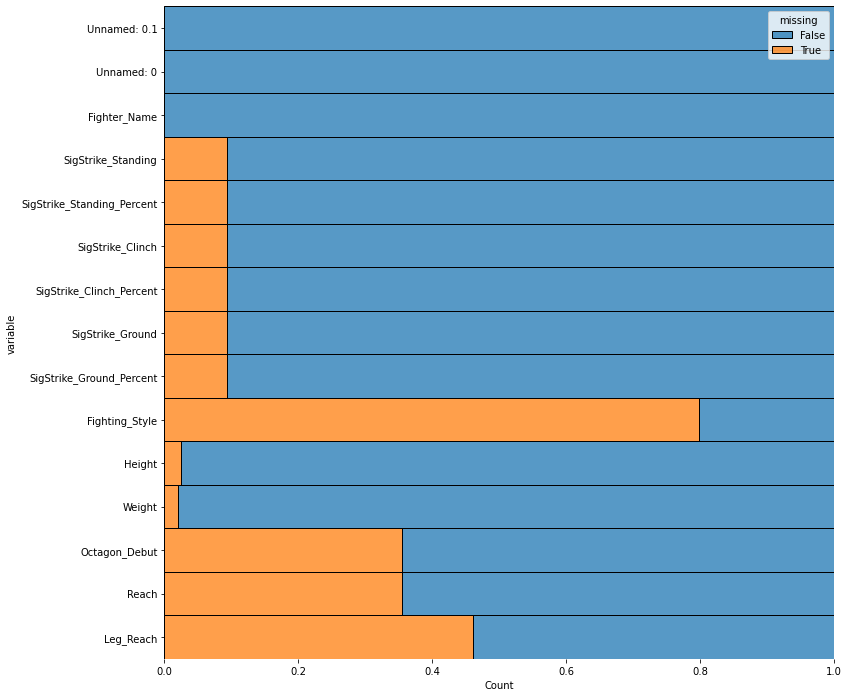

In [135]:
f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fighter_bios.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [32]:
unnamed = [n for n in fighter_bios.columns if 'Unnamed' in n]
fighter_bios = fighter_bios.drop(columns=unnamed)

In [33]:

def get_bio_data(fighter, stat):
    try:
        data = fighter_bios[fighter_bios['Fighter_Name'] == fighter]
        d = data[stat].values[0]
        d = pd.to_numeric(d)
        return d
    except:
        return nan


In [34]:
# test
weight = get_bio_data('Khabib Nurmagomedov', 'Height')
weight

70.0

In [139]:
fights['A_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Height'), axis=1)
fights['B_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Height'), axis=1)
fights['Dif_Height'] = fights['A_Height'] - fights['B_Height']

In [140]:
fights['A_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Reach'), axis=1)
fights['B_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Reach'), axis=1)
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [35]:
# all_fights_no_drops version
all_fights_no_drops['A_Height'] = all_fights_no_drops.apply(lambda row: get_bio_data(row['Fighter_A'], 'Height'), axis=1)
all_fights_no_drops['B_Height'] = all_fights_no_drops.apply(lambda row: get_bio_data(row['Fighter_B'], 'Height'), axis=1)
all_fights_no_drops['Dif_Height'] = all_fights_no_drops['A_Height'] - all_fights_no_drops['B_Height']

all_fights_no_drops['A_Reach'] = all_fights_no_drops.apply(lambda row: get_bio_data(row['Fighter_A'], 'Reach'), axis=1)
all_fights_no_drops['B_Reach'] = all_fights_no_drops.apply(lambda row: get_bio_data(row['Fighter_B'], 'Reach'), axis=1)
all_fights_no_drops['Dif_Reach'] = all_fights_no_drops['A_Reach'] - all_fights_no_drops['B_Reach']

In [36]:
# leg reach
all_fights_no_drops['A_Leg_Reach'] = all_fights_no_drops.apply(lambda row: get_bio_data(row['Fighter_A'], 'Leg_Reach'), axis=1)
all_fights_no_drops['B_Leg_Reach'] = all_fights_no_drops.apply(lambda row: get_bio_data(row['Fighter_B'], 'Leg_Reach'), axis=1)
all_fights_no_drops['Dif_Leg_Reach'] = all_fights_no_drops['A_Leg_Reach'] - all_fights_no_drops['B_Leg_Reach']

<AxesSubplot:xlabel='Count', ylabel='variable'>

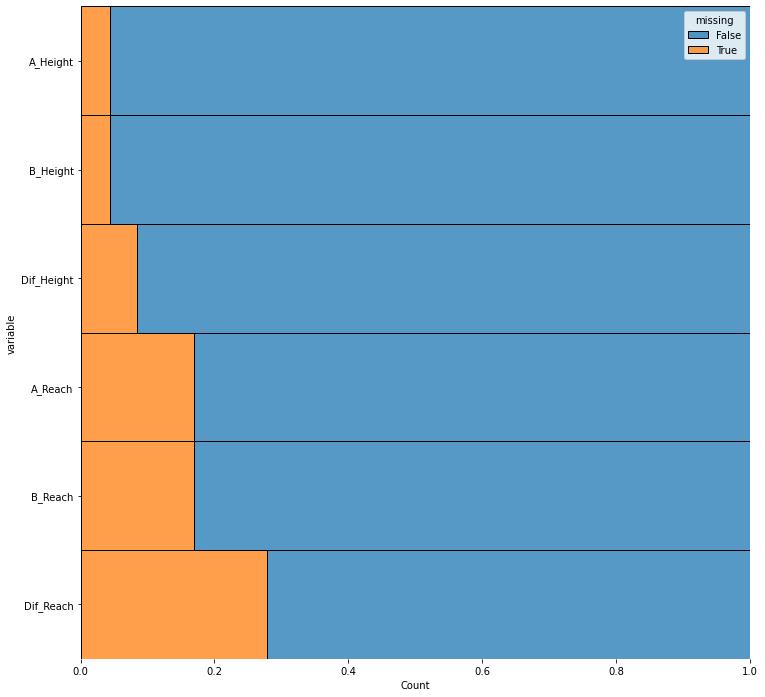

In [141]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
cols = nothere.index

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fights[cols].isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [142]:
fights['A_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Leg_Reach'), axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Leg_Reach'), axis=1)
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']

<AxesSubplot:xlabel='Count', ylabel='variable'>

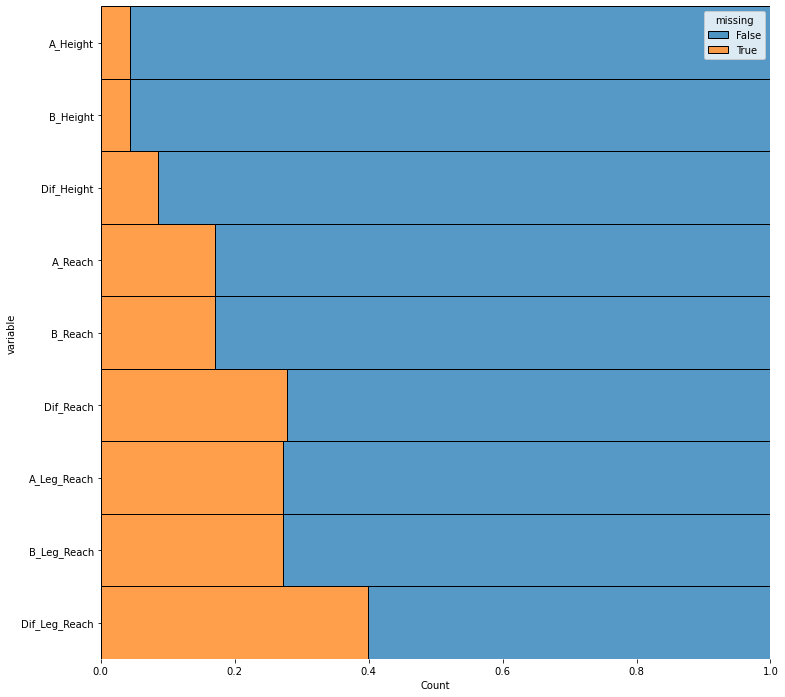

In [143]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
cols = nothere.index

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fights[cols].isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [144]:
check_leg = fights[fights['A_Leg_Reach'].isna()]
check_leg

,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,...,B_Rolling_Ground_Strikes_percent_median,A_Height,B_Height,Dif_Height,A_Reach,B_Reach,Dif_Reach,A_Leg_Reach,B_Leg_Reach,Dif_Leg_Reach
22,22,Jose Aldo,Merab Dvalishvili,0,0,38,67,57,147,0.56,...,0.713339,NaN,66.0,NaN,NaN,68.0,NaN,NaN,38.0,NaN
47,47,Julianna Pena,Amanda Nunes,0,3,60,154,85,152,0.38,...,0.750000,NaN,68.0,NaN,NaN,69.0,NaN,NaN,41.0,NaN
77,77,Ian Garry,Gabe Green,1,0,116,193,90,195,0.60,...,0.394737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,109,Jeff Molina,Zhalgas Zhumagulov,0,0,56,148,37,112,0.37,...,0.000000,NaN,64.0,NaN,NaN,66.5,NaN,NaN,36.0,NaN
122,122,Jan Blachowicz,Aleksandar Rakic,0,0,31,71,27,85,0.43,...,0.312500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8811,8811,Quinton Jackson,Wanderlei Silva,1,1,39,68,56,104,0.57,...,0.458333,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8813,8813,Tito Ortiz,Chuck Liddell,0,1,13,32,23,65,0.40,...,0.000000,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8815,8815,Quinton Jackson,Wanderlei Silva,0,0,14,23,29,34,0.60,...,0.458333,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8818,8818,Royce Gracie,Ken Shamrock,0,0,3,12,10,22,0.25,...,0.236842,73.0,73.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# drop rows with no height data
fights = fights.dropna(subset=['A_Height', 'B_Height'])

In [146]:
def get_assumed_reach(fighter, height):
    data = fights[fights['A_Height'] == height]
    data = data['A_Reach'].dropna()
    return data.median()

def get_assumed_leg_reach(fighter, height):
    data = fights[fights['A_Height'] == height]
    data = data['A_Leg_Reach'].dropna()
    return data.median()

In [147]:
# replace nan reach values with assumed reach
fights['A_Reach'] = fights['A_Reach'].fillna(fights.apply(lambda row: get_assumed_reach(row['Fighter_A'], row['A_Height']), axis=1))

In [148]:
fights['B_Reach'] = fights['B_Reach'].fillna(fights.apply(lambda row: get_assumed_reach(row['Fighter_B'], row['B_Height']), axis=1))
fights['A_Leg_Reach'] = fights['A_Leg_Reach'].fillna(fights.apply(lambda row: get_assumed_leg_reach(row['Fighter_A'], row['A_Height']), axis=1))
fights['B_Leg_Reach'] = fights['B_Leg_Reach'].fillna(fights.apply(lambda row: get_assumed_leg_reach(row['Fighter_B'], row['B_Height']), axis=1))

In [149]:
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']

<AxesSubplot:xlabel='Count', ylabel='variable'>

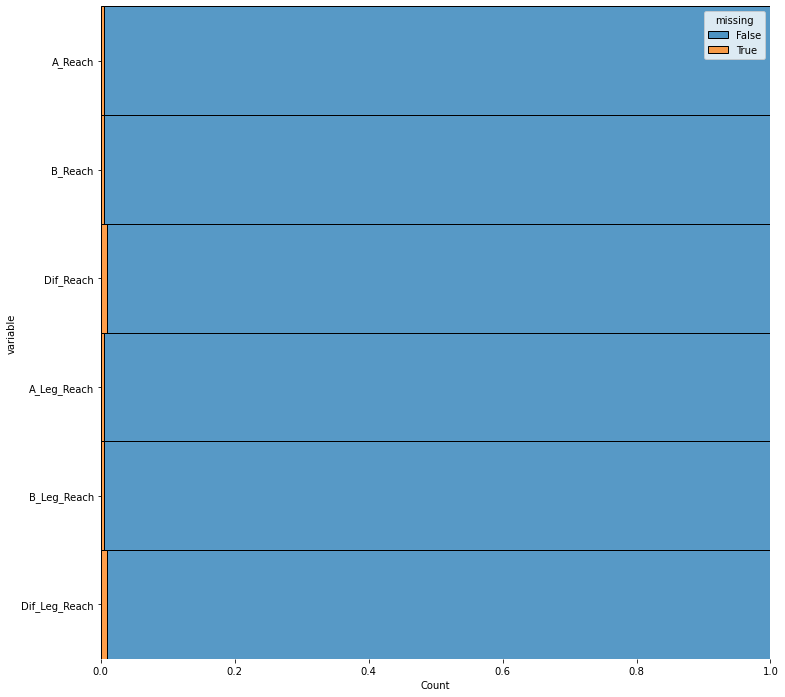

In [151]:

#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
cols = nothere.index

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fights[cols].isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [152]:
fights.dropna(inplace = True)

## Add: Who Won?

This data is in the data/ufc_stats/fighters folder. 

First, I want to append it all together. 

In [7]:
fights['win?'] = np.where(fights['Winner'] == fights['Fighter_A'], 1, 0)

In [37]:
# no_drops version
all_fights_no_drops['win?'] = np.where(all_fights_no_drops['Winner'] == all_fights_no_drops['Fighter_A'], 1, 0)

In [9]:
# drop what didnt work
fights = fights.dropna(subset=['win?'])

In [11]:
list(fights.columns)

['Unnamed: 0.1',
 'Unnamed: 0',
 'Fighter_A',
 'Fighter_B',
 'A_Kd',
 'B_Kd',
 'A_Sig_strike_land',
 'A_Sig_strike_att',
 'B_Sig_strike_land',
 'B_Sig_strike_att',
 'A_Sig_strike_percent',
 'B_Sig_strike_percent',
 'A_Total_Strikes_land',
 'A_Total_Strikes_att',
 'B_Total_Strikes_land',
 'B_Total_Strikes_att',
 'A_Total_Strikes_percent',
 'B_Total_Strikes_percent',
 'A_Takedowns_land',
 'A_Takedowns_att',
 'B_Takedowns_land',
 'B_Takedowns_att',
 'A_Takedown_percent',
 'B_Takedown_percent',
 'A_Sub_Attempts_land',
 'B_Sub_Attempts_land',
 'A_Rev',
 'B_Rev',
 'A_Ctrl_time_min',
 'A_Ctrl_time_sec',
 'B_Ctrl_time_min',
 'B_Ctrl_time_sec',
 'A_Ctrl_time_tot',
 'B_Ctrl_time_tot',
 'details',
 'event_title',
 'event_url',
 'date',
 'Winner',
 'A_Head_Strikes_land',
 'A_Head_Strikes_att',
 'B_Head_Strikes_land',
 'B_Head_Strikes_att',
 'A_Head_Strikes_percent',
 'B_Head_Strikes_percent',
 'A_Body_Strikes_land',
 'A_Body_Strikes_att',
 'B_Body_Strikes_land',
 'B_Body_Strikes_att',
 'A_Body_Str

In [158]:
# save point for safety
fights.to_csv('data/ufc_stats/agg2/all_fights_9_27_V9.csv')

In [38]:
# save point for safety
all_fights_no_drops.to_csv('data/final/all_fights_no_drops_V6.csv')

## Summary
- Now have Stats, fighter info, rolling stats, differences, and who won. 


# Streamlit Functionality

We also need it to work in streamlit, without taking forever. So, there should be an updated fights_df with the NEXT fights added, which can then update the calculations on a consistant basis. 

In [33]:
# load point
fights = pd.read_csv('data/ufc_stats/agg2/all_fights_9_27_V9.csv')
all_fights_no_drops = pd.read_csv('data/final/all_fights_no_drops_V6.csv')

In [34]:
next_event = get_next_event_ufcstats()
next_event

,event_title,event_url,event_date
0,UFC Fight Night: Rodriguez vs. Lemos,http://www.ufcstats.com/event-details/756f4590...,"November 05, 2022"


In [15]:
fighter_urls = get_fighter_urls(next_event['event_url'].values[0])
fighter_urls

,fighter1,fighter2:,fighter1_url,fighter2_url,fight#
0,Marina Rodriguez,Amanda Lemos,http://www.ufcstats.com/fighter-details/cd2c4d...,http://www.ufcstats.com/fighter-details/3df549...,1
1,Neil Magny,Daniel Rodriguez,http://www.ufcstats.com/fighter-details/84b3e7...,http://www.ufcstats.com/fighter-details/8a1f3b...,2
2,Chase Sherman,Josh Parisian,http://www.ufcstats.com/fighter-details/01b352...,http://www.ufcstats.com/fighter-details/b5da8f...,3
3,Tagir Ulanbekov,Nate Maness,http://www.ufcstats.com/fighter-details/f00ac0...,http://www.ufcstats.com/fighter-details/6e9f40...,4
4,Grant Dawson,Mark Madsen,http://www.ufcstats.com/fighter-details/99bd51...,http://www.ufcstats.com/fighter-details/da0995...,5
5,Jailton Almeida,Maxim Grishin,http://www.ufcstats.com/fighter-details/41e83a...,http://www.ufcstats.com/fighter-details/950d0e...,6
6,Darrick Minner,Shayilan Nuerdanbieke,http://www.ufcstats.com/fighter-details/34e516...,http://www.ufcstats.com/fighter-details/0a73ac...,7
7,Miranda Maverick,Shanna Young,http://www.ufcstats.com/fighter-details/f29a63...,http://www.ufcstats.com/fighter-details/568bba...,8
8,Mario Bautista,Benito Lopez,http://www.ufcstats.com/fighter-details/bc711b...,http://www.ufcstats.com/fighter-details/773f7f...,9
9,Polyana Viana,Jinh Yu Frey,http://www.ufcstats.com/fighter-details/9673a4...,http://www.ufcstats.com/fighter-details/d05cb1...,10


In [16]:
# turn event_date to actual date
next_event['event_date'] = pd.to_datetime(next_event['event_date']).dt.date
event_date = next_event['event_date'].values[0]
event_date

datetime.date(2022, 11, 5)

In [17]:
next_fight_df = fighter_urls[['fighter1', 'fighter2:']]
next_fight_df.columns = ['Fighter_A', 'Fighter_B']
next_fight_df['date'] = event_date
next_fight_df

,Fighter_A,Fighter_B,date
0,Marina Rodriguez,Amanda Lemos,2022-11-05
1,Neil Magny,Daniel Rodriguez,2022-11-05
2,Chase Sherman,Josh Parisian,2022-11-05
3,Tagir Ulanbekov,Nate Maness,2022-11-05
4,Grant Dawson,Mark Madsen,2022-11-05
5,Jailton Almeida,Maxim Grishin,2022-11-05
6,Darrick Minner,Shayilan Nuerdanbieke,2022-11-05
7,Miranda Maverick,Shanna Young,2022-11-05
8,Mario Bautista,Benito Lopez,2022-11-05
9,Polyana Viana,Jinh Yu Frey,2022-11-05


In [18]:
all_fights_no_drops.head(2)

,Unnamed: 0.1,Unnamed: 0,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,...,A_Height,B_Height,Dif_Height,A_Reach,B_Reach,Dif_Reach,A_Leg_Reach,B_Leg_Reach,Dif_Leg_Reach,win?
0,0,0,Holly Holm,Irene Aldana,0,0,154,301,69,185,...,68.0,69.0,-1.0,69.0,68.5,0.5,38.0,38.5,-0.5,1
1,1,1,Joshua Burkman,Josh Neer,1,0,35,88,19,39,...,70.0,71.0,-1.0,72.0,NaN,NaN,39.0,NaN,NaN,1


In [19]:
# replace all NANs with calculations
# First, ROLLING data

in_fight_cols = [n for n in list(all_fights_no_drops.columns) if n.startswith('A_') or n.startswith('B_')]
rolling_cols = [n for n in in_fight_cols if 'Rolling' in n]
in_fight_only_cols = [n for n in in_fight_cols if n not in rolling_cols]
in_fight_only_cols.remove('A_Height')
in_fight_only_cols.remove('B_Height')
in_fight_only_cols.remove('A_Reach')
in_fight_only_cols.remove('B_Reach')
in_fight_only_cols.remove('A_Leg_Reach')
in_fight_only_cols.remove('B_Leg_Reach')


In [20]:
A_cols = [n for n in in_fight_only_cols if n.startswith('A_')]
A_cols2 = pd.DataFrame(A_cols)
A_cols2['nonspecific'] = A_cols2[0].str[2:]
the_cols = list(A_cols2['nonspecific'].unique())
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

In [21]:
# for each column in all_metric_cols, get the mean, std, etc. for each fighter
def get_em(fighter, date, col_to_get, stat_to_calc):
    data = all_fights_no_drops[(all_fights_no_drops['Fighter_A'] == fighter) | (all_fights_no_drops['Fighter_B'] == fighter)]
    # only get fights before the date
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]
    # fighter could be either fighter A or fighter B
    fighter_data = pd.DataFrame()
    # when fighter is fighter A, get all fighter A data and copy it to fighter_data
    # fighterA df
    fighterA_df = all_fights_no_drops[all_fights_no_drops['Fighter_A'] == fighter]
    fighterB_df = all_fights_no_drops[all_fights_no_drops['Fighter_B'] == fighter]
    # keep only the fighters columns date, FighterA, and the col_to_get, do same for B, change col names from B to A, and concat
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)
    # append the dataframes on fighter
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)
    # make sure the date is before the date of the fight
    # get the average
    if stat_to_calc == 'mean':
        x = fighter_data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = fighter_data[col_to_get].std()
    elif stat_to_calc == 'max':
        x = fighter_data[col_to_get].max()
    elif stat_to_calc == 'min':
        x = fighter_data[col_to_get].min()
    elif stat_to_calc == 'median':
        x = fighter_data[col_to_get].median()  
    return x

In [22]:
next_event_date = next_fight_df['date'].values[0]
str(next_event_date)

'2022-11-05'

In [23]:
for col in the_cols:
    for stat in ['mean', 'std', 'max', 'min', 'median']:
        next_fight_df['A_Rolling_' + col + '_' + stat] = next_fight_df.apply(lambda x: get_em(fighter=x['Fighter_A'], date=next_event_date, col_to_get=col, stat_to_calc=stat), axis=1)
        next_fight_df['B_Rolling_' + col + '_' + stat] = next_fight_df.apply(lambda x: get_em(fighter=x['Fighter_B'], date=next_event_date, col_to_get=col, stat_to_calc=stat), axis=1)


In [24]:
next_fight_df.to_csv('data/final/next_fights/' + str(next_event_date) + '.csv')

In [25]:
next_fight_df

,Fighter_A,Fighter_B,date,A_Rolling_Kd_mean,B_Rolling_Kd_mean,A_Rolling_Kd_std,B_Rolling_Kd_std,A_Rolling_Kd_max,B_Rolling_Kd_max,A_Rolling_Kd_min,...,A_Rolling_Ground_Strikes_percent_mean,B_Rolling_Ground_Strikes_percent_mean,A_Rolling_Ground_Strikes_percent_std,B_Rolling_Ground_Strikes_percent_std,A_Rolling_Ground_Strikes_percent_max,B_Rolling_Ground_Strikes_percent_max,A_Rolling_Ground_Strikes_percent_min,B_Rolling_Ground_Strikes_percent_min,A_Rolling_Ground_Strikes_percent_median,B_Rolling_Ground_Strikes_percent_median
0,Marina Rodriguez,Amanda Lemos,2022-11-05,0.100000,0.312500,0.303822,0.592289,1.0,2.0,0.0,...,0.811282,0.727041,0.163376,0.198559,1.000000,1.000000,0.500000,0.500000,0.848214,0.708333
1,Neil Magny,Daniel Rodriguez,2022-11-05,0.192308,0.277778,0.522818,0.741085,2.0,3.0,0.0,...,0.677959,0.580587,0.238562,0.322875,1.000000,1.000000,0.000000,0.000000,0.713636,0.625000
2,Chase Sherman,Josh Parisian,2022-11-05,0.230769,0.250000,0.425436,0.442326,1.0,1.0,0.0,...,0.765220,0.727473,0.308387,0.215316,1.000000,1.000000,0.000000,0.333333,0.886538,0.728421
3,Tagir Ulanbekov,Nate Maness,2022-11-05,0.166667,0.375000,0.389249,0.500000,1.0,1.0,0.0,...,0.904762,0.834202,0.147542,0.118931,1.000000,1.000000,0.714286,0.666667,1.000000,0.850746
4,Grant Dawson,Mark Madsen,2022-11-05,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.780580,0.819347,0.190461,0.137789,1.000000,1.000000,0.333333,0.636364,0.800000,0.820513
5,Jailton Almeida,Maxim Grishin,2022-11-05,0.000000,0.250000,0.000000,0.683130,0.0,2.0,0.0,...,0.731169,0.814857,0.201621,0.266601,1.000000,1.000000,0.515152,0.360000,0.704762,1.000000
6,Darrick Minner,Shayilan Nuerdanbieke,2022-11-05,0.083333,0.166667,0.282330,0.389249,1.0,1.0,0.0,...,0.742194,0.819196,0.174012,0.117752,1.000000,1.000000,0.444444,0.714286,0.700000,0.781250
7,Miranda Maverick,Shanna Young,2022-11-05,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.564153,0.734984,0.385883,0.225608,0.904762,1.000000,0.000000,0.446429,0.675926,0.746753
8,Mario Bautista,Benito Lopez,2022-11-05,0.250000,0.250000,0.442326,0.447214,1.0,1.0,0.0,...,0.760952,0.781439,0.170083,0.093809,1.000000,0.909091,0.571429,0.666667,0.666667,0.775000
9,Polyana Viana,Jinh Yu Frey,2022-11-05,0.071429,NaN,0.262265,NaN,1.0,NaN,0.0,...,0.853819,NaN,0.179706,NaN,1.000000,NaN,0.555556,NaN,0.937500,NaN


#### Impute NAN with median

In [26]:
# impute NANs with median values - stdev

next_fight_df.fillna(all_fights_no_drops.median(), inplace=True)

In [27]:
next_fight_df.to_csv('data/final/next_fights/' + str(next_event_date) + '_imputed.csv')

In [28]:
next_fight_df

,Fighter_A,Fighter_B,date,A_Rolling_Kd_mean,B_Rolling_Kd_mean,A_Rolling_Kd_std,B_Rolling_Kd_std,A_Rolling_Kd_max,B_Rolling_Kd_max,A_Rolling_Kd_min,...,A_Rolling_Ground_Strikes_percent_mean,B_Rolling_Ground_Strikes_percent_mean,A_Rolling_Ground_Strikes_percent_std,B_Rolling_Ground_Strikes_percent_std,A_Rolling_Ground_Strikes_percent_max,B_Rolling_Ground_Strikes_percent_max,A_Rolling_Ground_Strikes_percent_min,B_Rolling_Ground_Strikes_percent_min,A_Rolling_Ground_Strikes_percent_median,B_Rolling_Ground_Strikes_percent_median
0,Marina Rodriguez,Amanda Lemos,2022-11-05,0.100000,0.312500,0.303822,0.592289,1.0,2.0,0.0,...,0.811282,0.727041,0.163376,0.198559,1.000000,1.000000,0.500000,0.500000,0.848214,0.708333
1,Neil Magny,Daniel Rodriguez,2022-11-05,0.192308,0.277778,0.522818,0.741085,2.0,3.0,0.0,...,0.677959,0.580587,0.238562,0.322875,1.000000,1.000000,0.000000,0.000000,0.713636,0.625000
2,Chase Sherman,Josh Parisian,2022-11-05,0.230769,0.250000,0.425436,0.442326,1.0,1.0,0.0,...,0.765220,0.727473,0.308387,0.215316,1.000000,1.000000,0.000000,0.333333,0.886538,0.728421
3,Tagir Ulanbekov,Nate Maness,2022-11-05,0.166667,0.375000,0.389249,0.500000,1.0,1.0,0.0,...,0.904762,0.834202,0.147542,0.118931,1.000000,1.000000,0.714286,0.666667,1.000000,0.850746
4,Grant Dawson,Mark Madsen,2022-11-05,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.780580,0.819347,0.190461,0.137789,1.000000,1.000000,0.333333,0.636364,0.800000,0.820513
5,Jailton Almeida,Maxim Grishin,2022-11-05,0.000000,0.250000,0.000000,0.683130,0.0,2.0,0.0,...,0.731169,0.814857,0.201621,0.266601,1.000000,1.000000,0.515152,0.360000,0.704762,1.000000
6,Darrick Minner,Shayilan Nuerdanbieke,2022-11-05,0.083333,0.166667,0.282330,0.389249,1.0,1.0,0.0,...,0.742194,0.819196,0.174012,0.117752,1.000000,1.000000,0.444444,0.714286,0.700000,0.781250
7,Miranda Maverick,Shanna Young,2022-11-05,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.564153,0.734984,0.385883,0.225608,0.904762,1.000000,0.000000,0.446429,0.675926,0.746753
8,Mario Bautista,Benito Lopez,2022-11-05,0.250000,0.250000,0.442326,0.447214,1.0,1.0,0.0,...,0.760952,0.781439,0.170083,0.093809,1.000000,0.909091,0.571429,0.666667,0.666667,0.775000
9,Polyana Viana,Jinh Yu Frey,2022-11-05,0.071429,0.130435,0.262265,0.341565,1.0,1.0,0.0,...,0.853819,0.693651,0.179706,0.208795,1.000000,1.000000,0.555556,0.357143,0.937500,0.708333


## Updated Rolling Statistics

### Grabbing UFC Event Number

In order to scrape UFC.com statistics, we need the "secret" code for each event, which is hidden in the innerhtml of the event page. We can find it like so:

In [29]:
url = 'https://www.ufc.com/event/ufc-fight-night-november-05-2022'

#use selenium to get the html
driver = webdriver.Chrome()
driver.get(url)
# get iframe src
a = driver.find_element_by_xpath("/html/body/div[1]/div/main/div[1]/div[1]/div/div[4]/div/div/div[1]/div/div[1]/div/section/ul/li[1]/div/div/div/div[3]/div[3]")
# get source of a
a_src = a.get_attribute('innerHTML')
a_src
# get iframe src from a_src
iframe_src = a_src.split('src="')[1].split('"')[0]
secret_event_number = iframe_src.split('/')[-3]
secret_event_number


WebDriverException: Message: 'chromedriver' executable needs to be in PATH. Please see https://chromedriver.chromium.org/home


In [30]:
# make function
def get_secret_event_number(event_matchup_url):
    #use selenium to get the html
    driver = webdriver.Chrome()
    driver.get(event_matchup_url)
    # get iframe src
    a = driver.find_element_by_xpath("/html/body/div[1]/div/main/div[1]/div[1]/div/div[4]/div/div/div[1]/div/div[1]/div/section/ul/li[1]/div/div/div/div[3]/div[3]")
    # get source of a
    a_src = a.get_attribute('innerHTML')
    a_src
    # get iframe src from a_src
    iframe_src = a_src.split('src="')[1].split('"')[0]
    secret_event_number = iframe_src.split('/')[-3]
    return secret_event_number

# Part 3: EDA

In [2]:
# Load point to skip here
fights = pd.read_csv('data/ufc_stats/agg2/all_fights_9_27_V9.csv') 

In [3]:
fights_columns = fights.columns.to_list()

In [4]:
# get all numeric
fights_num = fights.select_dtypes(include=['float64', 'int64'])

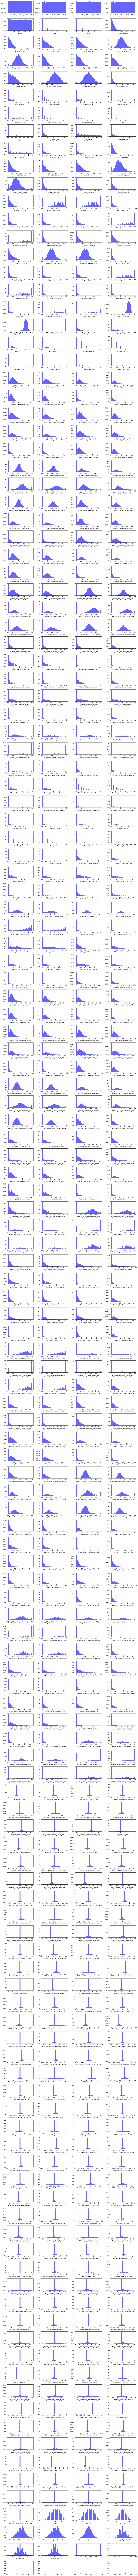

In [10]:
data = fights_num
df_size = len(data.columns)
nrw = round((df_size / 4)+4,0)
nrw = int(nrw)

fig, axes = plt.subplots(ncols=4, nrows= (nrw-3), figsize=(16, (2*nrw)))
fig.set_tight_layout(True)

for index, col in enumerate(data.columns):
    ax = axes[index//4][index%4]
    ax.hist(data[col], bins=25, density=True, alpha=0.6, color='b')
    ax.set_xlabel(col)

In [5]:
grouped = fights.groupby('Dif_Leg_Reach')['win?'].agg(['mean', 'count'])
grouped= grouped.reset_index()

Text(0.5, 1.0, 'Win? vs Dif_Leg_Reach')

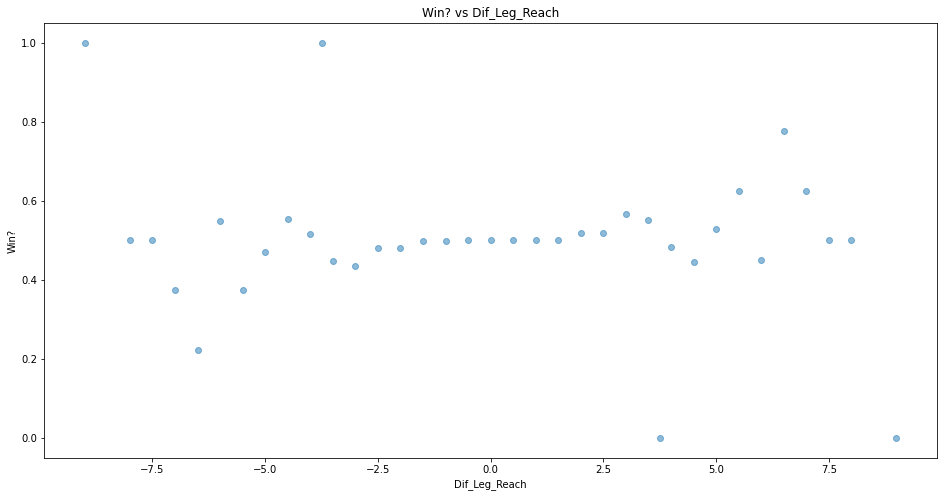

In [30]:
# plot win? vs Dif_Leg_Reach\
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(grouped['Dif_Leg_Reach'], grouped['mean'], alpha=0.5)
ax.set_xlabel('Dif_Leg_Reach')
ax.set_ylabel('Win?')
ax.set_title('Win? vs Dif_Leg_Reach')


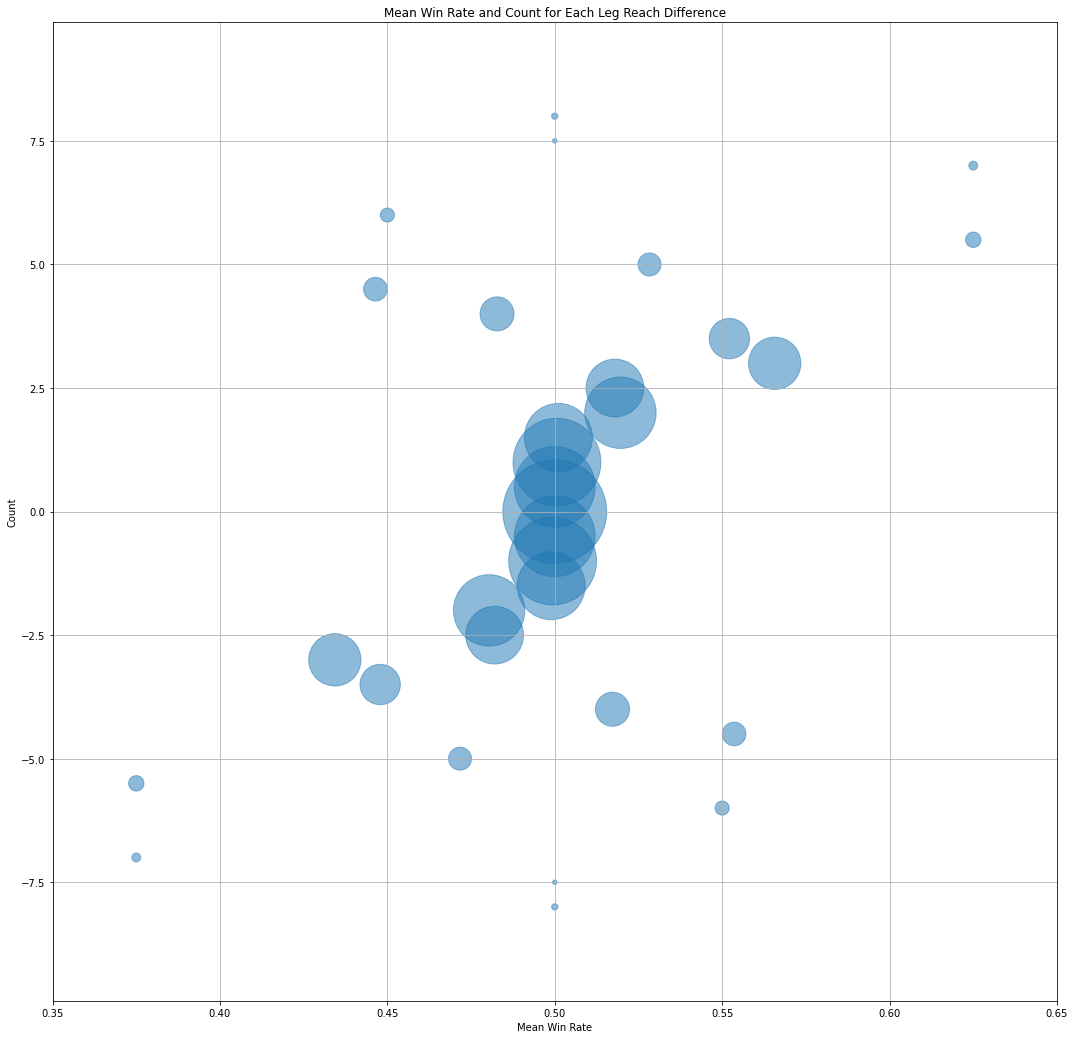

In [35]:
# plot the mean win rate and count for each leg reach difference in a bubble plot
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(grouped['mean'], grouped['Dif_Leg_Reach'], s=grouped['count']*10, alpha=0.5)
ax.set_xlabel('Mean Win Rate')
ax.set_ylabel('Count')
ax.set_title('Mean Win Rate and Count for Each Leg Reach Difference')
ax.grid(True)
# set plot limits at .25 and .75
ax.set_xlim(.35, .65)
plt.show()




<AxesSubplot:title={'center':'Win? vs Dif_Leg_Reach'}, xlabel='Dif_Leg_Reach', ylabel='win?'>

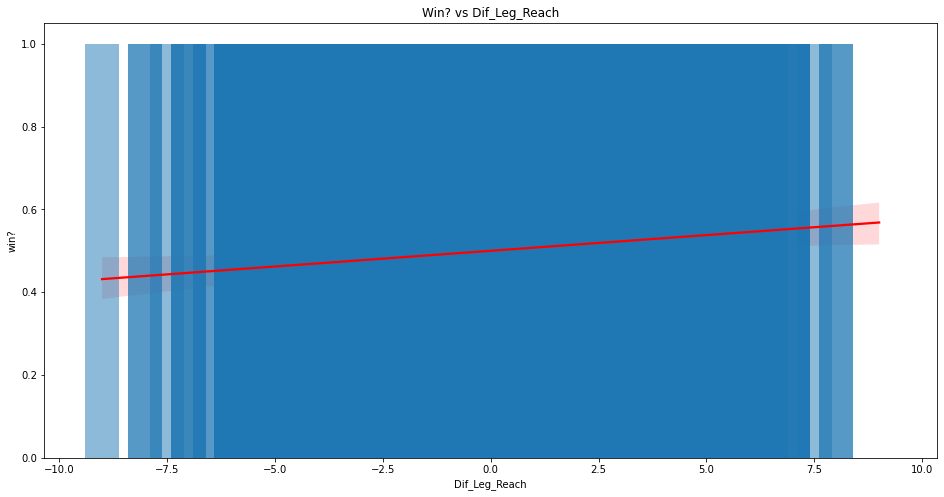

In [40]:
# scatterplot with regression line of win? vs Dif_Leg_Reach
fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(fights['Dif_Leg_Reach'], fights['win?'], alpha=0.5)
ax.set_xlabel('Dif_Leg_Reach')
ax.set_ylabel('Win?')
ax.set_title('Win? vs Dif_Leg_Reach')
# add regression line
sns.regplot(x='Dif_Leg_Reach', y='win?', data=fights, ax=ax, scatter=False, color='red')




### Correlations

In [17]:
unnamed = [n for n in fights_num.columns if 'Unnamed' in n]
fights_num.drop(unnamed, axis=1, inplace=True)

In [18]:
# get correlations with win? in fights_num
corred = fights_num.corr()['win?'].sort_values(ascending=False)
corred = corred.reset_index()
# only keep correlations above .2 or below -.2
corred = corred[(corred['win?'] > .20)]
corred = corred.reset_index(drop=True)


In [19]:
# drop win? row and Unnamed: 0.1 row
corred = corred.drop([0, 1])
corred

,index,win?
2,Fighter_B_Odds_obf,0.357384
3,A_Ground_Strikes_land,0.333253
4,A_Ground_Strikes_att,0.327192
5,A_Ground_Strikes_percent,0.321526
6,A_Kd,0.314124
7,A_Sig_strike_percent,0.310211
8,favorite?,0.307500
9,A_Ctrl_time_tot,0.285323
10,A_Ctrl_time_min,0.282194
11,A_Total_Strikes_percent,0.277626


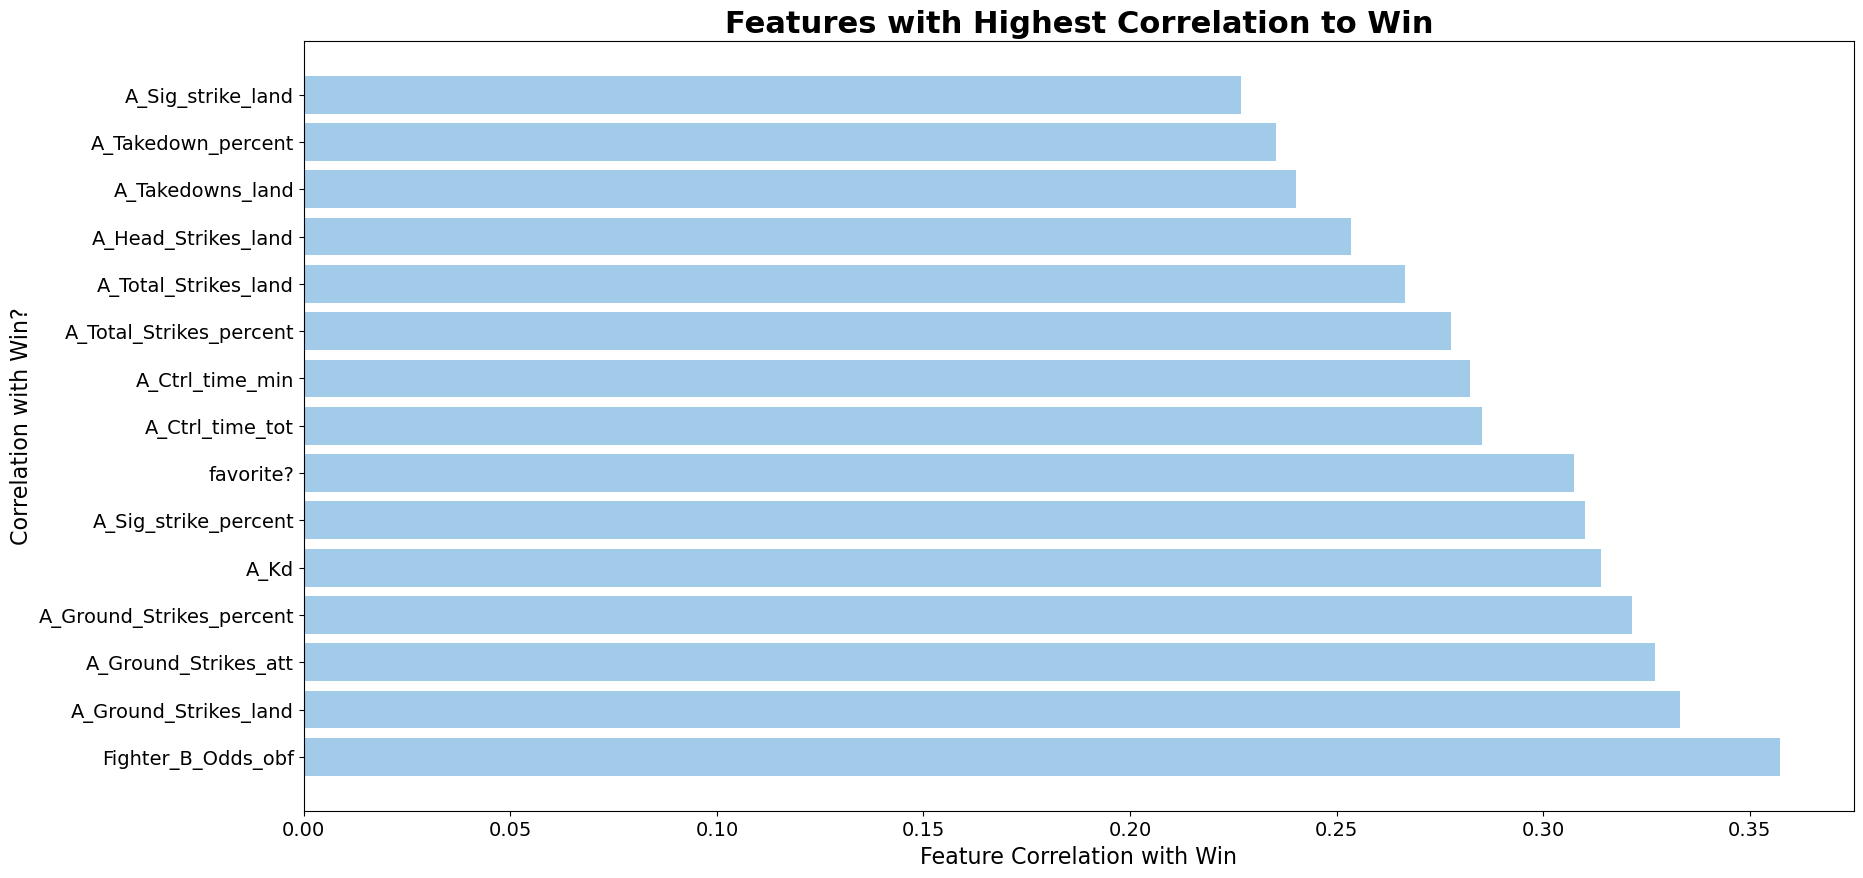

In [27]:
# plot corred
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(corred['index'], corred['win?'], alpha=0.5, color='#4498d4')
ax.set_xlabel('Feature Correlation with Win', fontsize=16)
ax.set_ylabel('Correlation with Win?', fontsize=16)
ax.set_title('Features with Highest Correlation to Win', fontsize=22, fontweight='bold')
plt.yticks(fontsize=14)
plt.xticks(fontsize = 14)
plt.show()


In [10]:
# get rows of corred
corred_rows = corred['index'].to_list()
# get fights with only corred rows
fights_corred = fights[corred_rows]

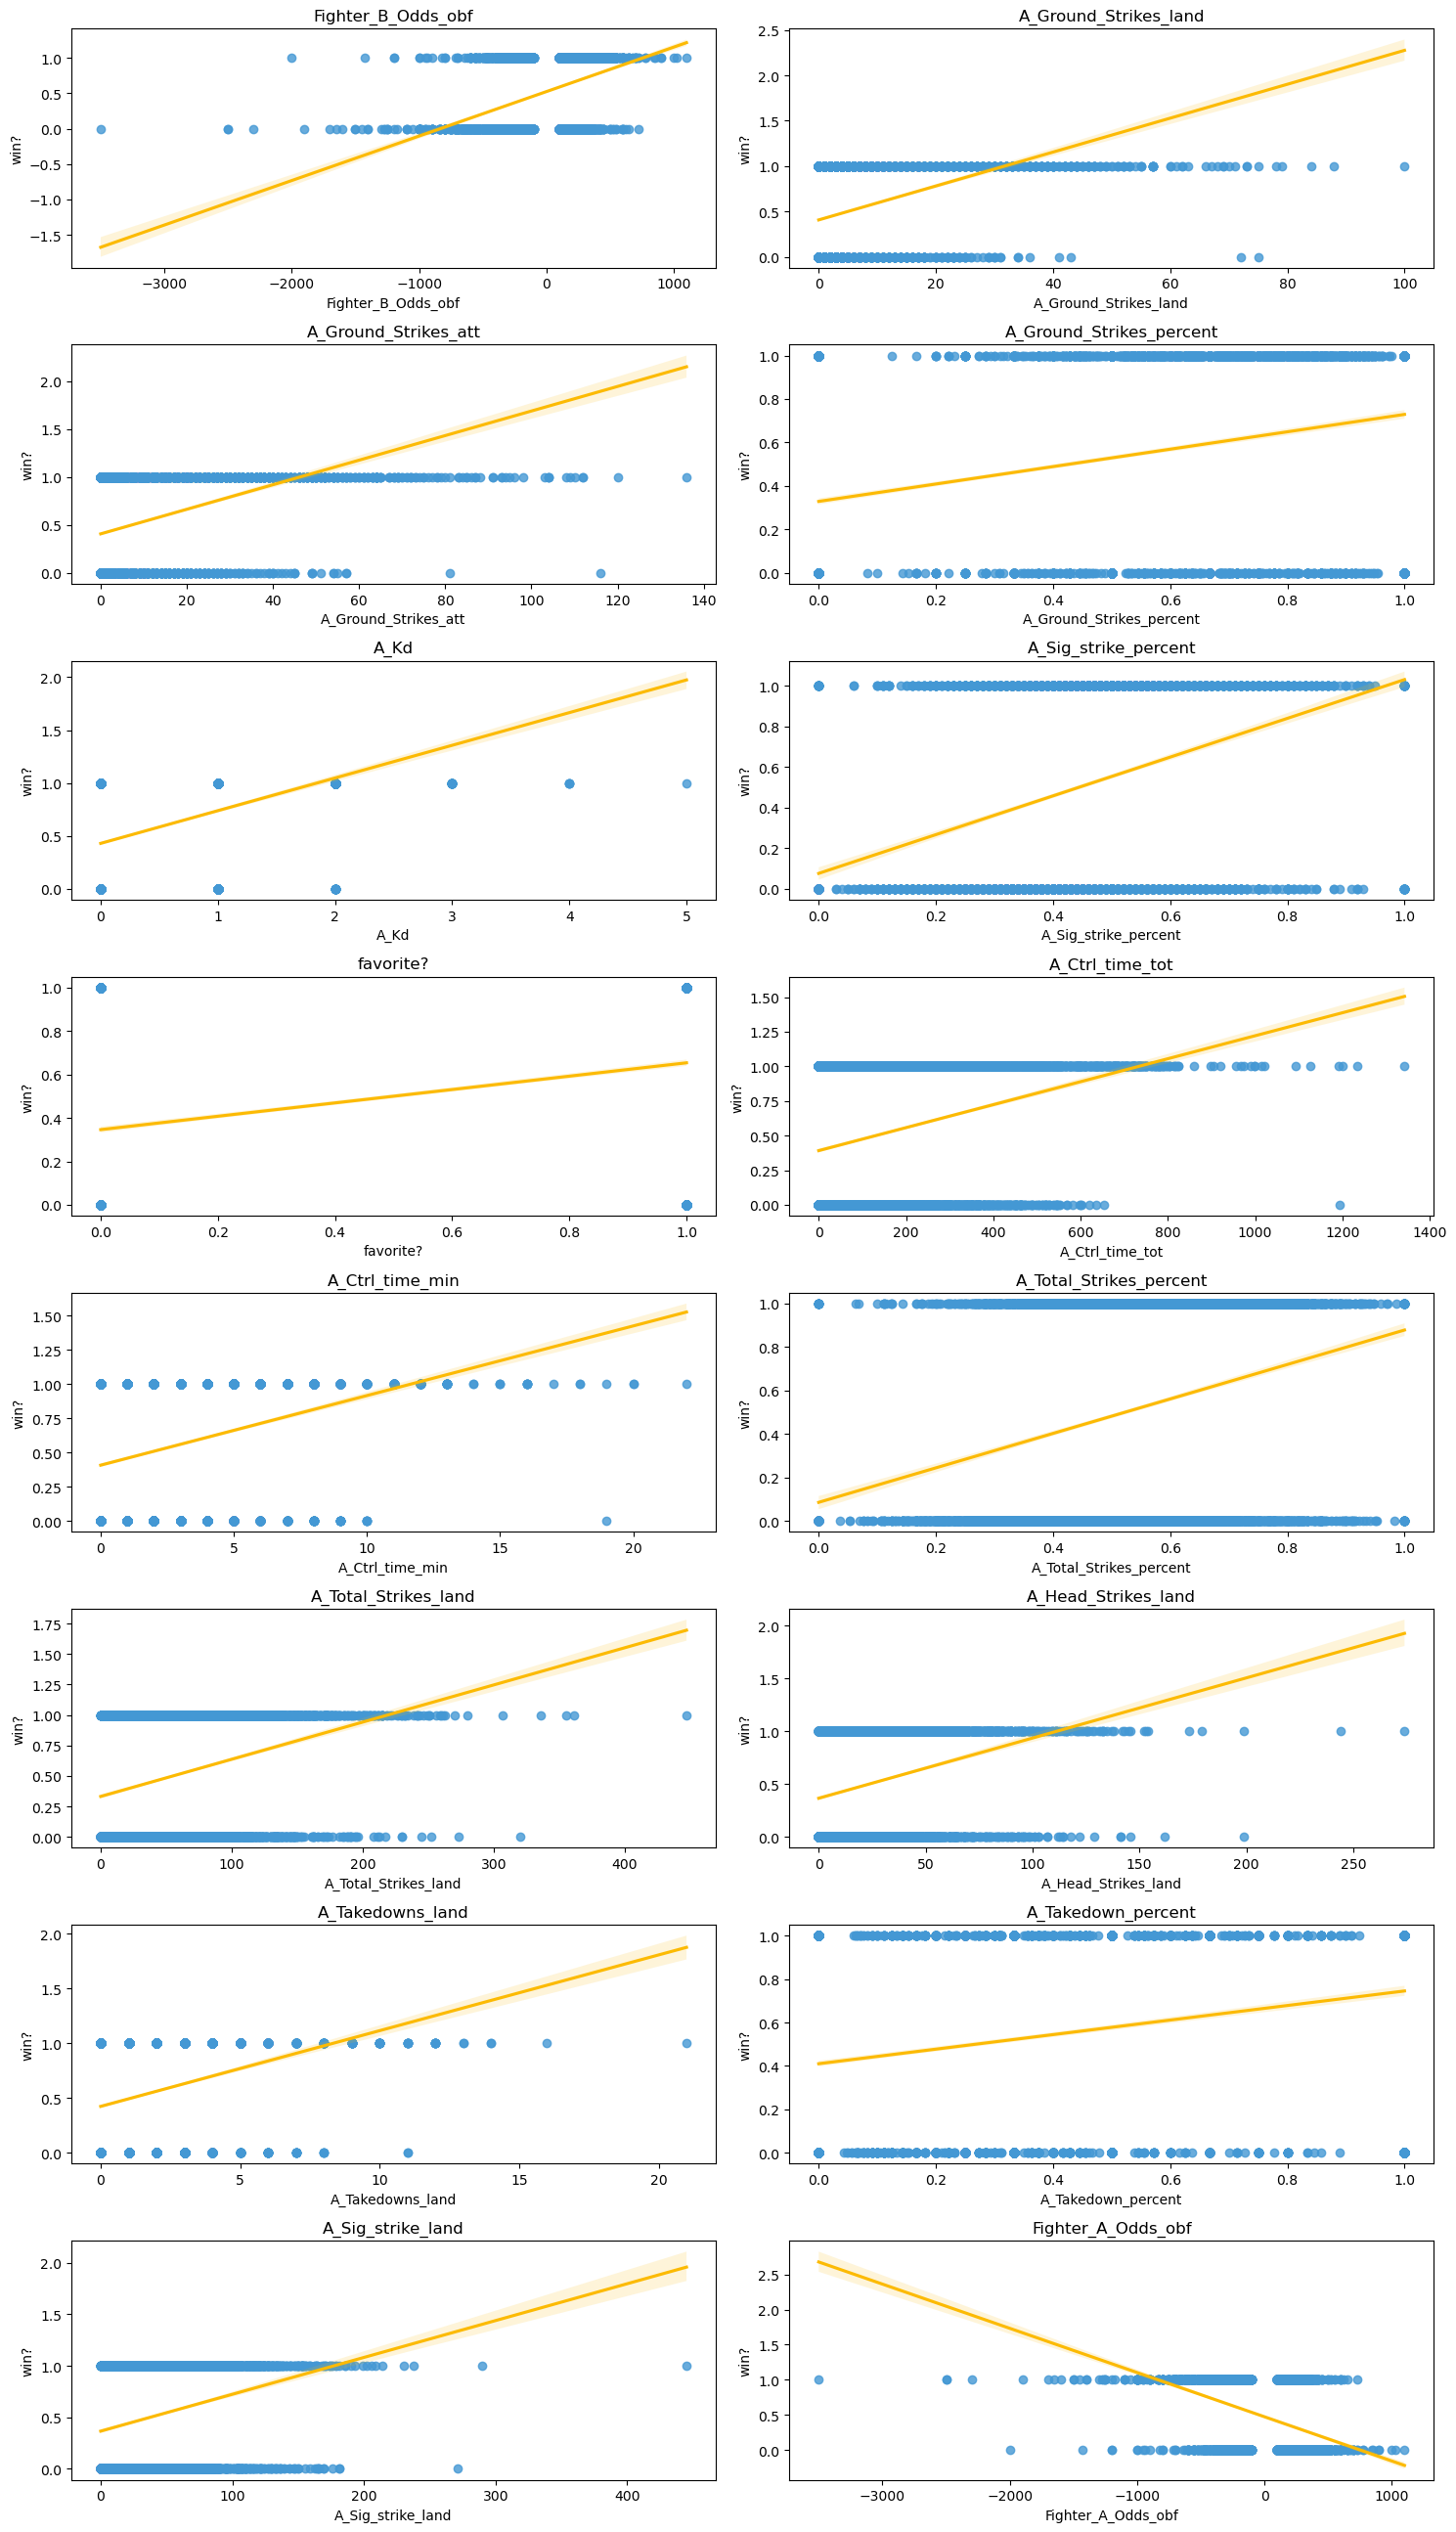

In [16]:

fig = plt.figure(figsize=(15,26))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.9,
                    wspace=0.1,
                    hspace=0.1)
for i, col in enumerate(fights_corred.columns):
        plt.subplot(round(len(fights_corred.columns)/2),2,i+1)
        sns.regplot(x=col, y= "win?", data=fights, scatter_kws={"color": '#4498d4'}, line_kws={"color": '#fcba03'})
        plt.title(col)
        plt.tight_layout()

# Part 4: Prediction

In [ ]:

df  = pd.read_csv('data/ufc_stats/agg2/all_fights_9_27_V9_CLEAN.csv') # .650
print(df.shape)
df.head(3)

(8000, 350)


,Fighter_A,Fighter_B,details,event_title,event_url,date,Winner,Fighter_A_Odds_obf,Fighter_B_Odds_obf,A_Rolling_Kd_mean,...,B_Height,Dif_Height,A_Reach,B_Reach,Dif_Reach,A_Leg_Reach,B_Leg_Reach,Dif_Leg_Reach,win?,favorite?
0,Anthony Hernandez,Marc-Andre Barriault,Arm Triangle From Mount,UFC Fight Night: Sandhagen vs. Song,http://www.ufcstats.com/event-details/8d477c3f...,2022-09-17,Anthony Hernandez,-225.0,163.0,0.166667,...,73.0,-1.0,75.0,74.0,1.0,40.0,42.5,-2.5,1,1
1,Tanner Boser,Rodrigo Nascimento,Junichiro Kamijo ...,UFC Fight Night: Sandhagen vs. Song,http://www.ufcstats.com/event-details/8d477c3f...,2022-09-17,Rodrigo Nascimento,-180.0,140.0,0.142857,...,74.0,0.0,75.5,80.0,-4.5,43.0,43.0,0.0,0,1
2,Tony Gravely,Javid Basharat,Chris Lee ...,UFC Fight Night: Sandhagen vs. Song,http://www.ufcstats.com/event-details/8d477c3f...,2022-09-17,Javid Basharat,136.0,-188.0,0.600000,...,69.0,-4.0,69.0,69.0,0.0,38.0,39.5,-1.5,0,0


In [ ]:
unnamed = [n for n in df.columns if 'Unnamed' in n]
df.drop(columns=unnamed, inplace=True)
#Identify columns with missing values
nothere = df.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
nothere

,0


In [ ]:
all_cols = df.columns.to_list()
all_cols

['Fighter_A',
 'Fighter_B',
 'details',
 'event_title',
 'event_url',
 'date',
 'Winner',
 'Fighter_A_Odds_obf',
 'Fighter_B_Odds_obf',
 'A_Rolling_Kd_mean',
 'B_Rolling_Kd_mean',
 'A_Rolling_Kd_std',
 'B_Rolling_Kd_std',
 'A_Rolling_Kd_max',
 'B_Rolling_Kd_max',
 'A_Rolling_Kd_min',
 'B_Rolling_Kd_min',
 'A_Rolling_Kd_median',
 'B_Rolling_Kd_median',
 'A_Rolling_Sig_strike_land_mean',
 'B_Rolling_Sig_strike_land_mean',
 'A_Rolling_Sig_strike_land_std',
 'B_Rolling_Sig_strike_land_std',
 'A_Rolling_Sig_strike_land_max',
 'B_Rolling_Sig_strike_land_max',
 'A_Rolling_Sig_strike_land_min',
 'B_Rolling_Sig_strike_land_min',
 'A_Rolling_Sig_strike_land_median',
 'B_Rolling_Sig_strike_land_median',
 'A_Rolling_Sig_strike_att_mean',
 'B_Rolling_Sig_strike_att_mean',
 'A_Rolling_Sig_strike_att_std',
 'B_Rolling_Sig_strike_att_std',
 'A_Rolling_Sig_strike_att_max',
 'B_Rolling_Sig_strike_att_max',
 'A_Rolling_Sig_strike_att_min',
 'B_Rolling_Sig_strike_att_min',
 'A_Rolling_Sig_strike_att_media

In [ ]:
#df.drop(columns=in_fight_cols, inplace=True)
#df.drop(columns=in_fight_difs, inplace=True)
colz = list(df.columns)
# get favorite
#df['favorite?'] = np.where(df['Fighter_A_Odds_obf'] < 0, 1, 0)

In [ ]:
#df['win?']  = np.where(df['Winner'] == df['Fighter_A'], 1, 0)

In [ ]:
# check value counts
df['win?'].value_counts()

1    4000
0    4000
Name: win?, dtype: int64

In [ ]:
fav_check = df.groupby('favorite?')['win?'].value_counts()
fav_check

favorite?  win?
0          0       2460
           1       1244
1          1       2756
           0       1540
Name: win?, dtype: int64

In [ ]:
# Check how often winner is favorite
fav = df.loc[df['favorite?'] == 1]
fav['win?'].value_counts()

1    2756
0    1540
Name: win?, dtype: int64

In [ ]:
2756/(2756+ 1540)

0.6387516254876463

#### Assign Target and Split

In [ ]:
target_name = "win?"
y = df[target_name]
X = df.drop(columns=[target_name])

# drop columns you dont want to use
to_drop = ['event_title','event_url','date', 'details', 'Fighter_A', 'Fighter_B', 'Winner' ]  # sometimes 'event_id' needed
X = X.drop(columns=to_drop)

# Scoring Metric
class_metric = 'accuracy'

In [ ]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

categorical_columns

[]

In [ ]:
numerical_columns

['Fighter_A_Odds_obf',
 'Fighter_B_Odds_obf',
 'A_Rolling_Kd_mean',
 'B_Rolling_Kd_mean',
 'A_Rolling_Kd_std',
 'B_Rolling_Kd_std',
 'A_Rolling_Kd_max',
 'B_Rolling_Kd_max',
 'A_Rolling_Kd_min',
 'B_Rolling_Kd_min',
 'A_Rolling_Kd_median',
 'B_Rolling_Kd_median',
 'A_Rolling_Sig_strike_land_mean',
 'B_Rolling_Sig_strike_land_mean',
 'A_Rolling_Sig_strike_land_std',
 'B_Rolling_Sig_strike_land_std',
 'A_Rolling_Sig_strike_land_max',
 'B_Rolling_Sig_strike_land_max',
 'A_Rolling_Sig_strike_land_min',
 'B_Rolling_Sig_strike_land_min',
 'A_Rolling_Sig_strike_land_median',
 'B_Rolling_Sig_strike_land_median',
 'A_Rolling_Sig_strike_att_mean',
 'B_Rolling_Sig_strike_att_mean',
 'A_Rolling_Sig_strike_att_std',
 'B_Rolling_Sig_strike_att_std',
 'A_Rolling_Sig_strike_att_max',
 'B_Rolling_Sig_strike_att_max',
 'A_Rolling_Sig_strike_att_min',
 'B_Rolling_Sig_strike_att_min',
 'A_Rolling_Sig_strike_att_median',
 'B_Rolling_Sig_strike_att_median',
 'A_Rolling_Sig_strike_percent_mean',
 'B_Rolling_

In [ ]:
numerical_columns.remove('favorite?')
categorical_columns.append('favorite?')

In [ ]:
col_list = X.columns.to_list()

#### Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
catcols = []

for col in categorical_columns:
    ind = col_list.index(col)
    catcols.append(ind)

catcols

[341]

In [ ]:
cont_cols_index = [n for n in range(len(X_train.columns)) if n not in catcols]

In [ ]:
# To get the column names from onehotencoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
checker = ohe.fit_transform(X_train[categorical_columns])

In [ ]:
feature_names_categorical = ohe.get_feature_names(categorical_columns)

### Preprocessing

In [ ]:
# pipeline for categorical data
cat_preprocessing = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)
# pipeline for numerical data
num_preprocessing = make_pipeline(StandardScaler())

# combine both pipeline using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, cont_cols_index), ("cat", cat_preprocessing, catcols)]
)

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                  14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                  25, 26, 27, 28, 29, ...]),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 [341])])

### Function Additions

In [ ]:
# SOURCE: The origin of this confusion matrix code was found on medium, '
# from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            a = cf[0,0]
            b = cf[0,1]
            c = cf[1,0]
            d = cf[1,1]
            tn = ((a / (a+b))*100).round(2).astype(str) + '%'
            fp = ((b / (a+b))*100).round(2).astype(str) + '%'
            fn = ((c / (c+d))*100).round(2).astype(str) + '%'
            tp = ((d / (c+d))*100).round(2).astype(str) + '%'
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = (1+(2**2)) * ((precision * recall) / (((2**2) * precision) + recall))
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\n\nRecall-Weighted F Score={:0.3f}".format(
                accuracy,precision,recall,f1_score, rwf_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages =  [tn,fp,fn,tp]
        # old = group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label', weight = 'bold')
        plt.xlabel('Predicted label' + stats_text, weight = 'bold')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title,size = 20, weight = 'bold')

In [ ]:
dfcols = ['Model', 'RWF Score', 'F1',  'Recall',  'Precision',  'Accuracy']
model_summary = pd.DataFrame(columns=dfcols)
model_summary

,Model,RWF Score,F1,Recall,Precision,Accuracy


In [ ]:
# Define Result Saving Initial Function
def save_result_w_matrix(cf,cv_mean_accuracy, cv_std_accuracy, model_name):
            global model_summary
            accuracy  = np.trace(cf) / float(np.sum(cf))
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            f_beta = (1+(.5**2)) * ((precision * recall) / (((.5**2) * precision) + recall))
            row = [(model_name, f_beta, f1_score, recall, precision, accuracy, cv_mean_accuracy, cv_std_accuracy)]
            res = pd.DataFrame(columns = dfcols, data = row)
            yeep = [model_summary, res]
            model_summary = pd.concat(yeep)
            model_summary = model_summary.sort_values('Accuracy', ascending = False)
            model_summary = model_summary.drop_duplicates()
            return model_summary.round(3)

In [ ]:
def save_result(cv_mean_accuracy, cv_std_accuracy, model_name):
            global model_summary2
            row = [(model_name, cv_mean_accuracy, cv_std_accuracy)]
            res = pd.DataFrame(columns = dfcols2, data = row)
            yeep = [model_summary2, res]
            model_summary2 = pd.concat(yeep)
            model_summary2 = model_summary2.sort_values('Cv_Mean_Accuracy', ascending = False)
            model_summary2 = model_summary2.drop_duplicates()
            return model_summary2.round(3)

In [ ]:
# Function runs model, fits it, and saves the results
def run_model(model, model_name):
    model.fit(X_train, y_train)
    model_prediction = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, model_prediction)
    save_result(cf_matrix, model_name)
    cf = make_confusion_matrix(cf_matrix)
    return model_summary

In [ ]:
dfcols2 = ['Model', 'Cv_Mean_Accuracy', 'Cv_Std']
model_summary2 = pd.DataFrame(columns=dfcols2)
model_summary2

,Model,Cv_Mean_Accuracy,Cv_Std


In [ ]:
def make_cf(model):
    #load pickle file
    with open(model, 'rb') as f:
        model = pickle.load(f)
    #get predictions
    y_pred = model.predict(X_test)
    cf = plot_confusion_matrix(model, y_test, y_pred)
    return cf

In [ ]:
# Function creates a pipeline, runs it, saves the result, and saves a pickle file

def create_fullpipe(preprocessing, model, model_name):
    fullpipe = Pipeline(steps=[('preprocess', preprocessing), ('model', model)])
    fullpipe.fit(X_train, y_train)
    # cross validation
    cv = cross_val_score(fullpipe, X_test, y_test, cv=3, scoring='accuracy')
    cv_mean = cv.mean()
    cv_std = cv.std()
    res = save_result(cv_mean, cv_std, model_name)
    # pickle model
    pickle.dump(fullpipe, open(f'{model_name}.pkl', 'wb'))
    return res

### Run Vanilla Models

In [ ]:
create_fullpipe(preprocessing, LogisticRegression(), 'Logistic_Regression')
create_fullpipe(preprocessing, RandomForestClassifier(), 'Random_Forest')
create_fullpipe(preprocessing, DecisionTreeClassifier(), 'Decision_Tree')
create_fullpipe(preprocessing, BaggingClassifier(), 'Bagged_Trees')
create_fullpipe(preprocessing, ExtraTreesClassifier(), 'Extra_Trees')
create_fullpipe(preprocessing, KNeighborsClassifier(), 'K_Neighbors')
create_fullpipe(preprocessing, SVC(), 'SVC')
create_fullpipe(preprocessing, XGBClassifier(eval_metric = 'logloss'), 'XGBoost')

,Model,Cv_Mean_Accuracy,Cv_Std
0,SVC,0.696,0.008
0,XGBoost,0.679,0.008
0,Random_Forest,0.677,0.001
0,Extra_Trees,0.673,0.011
0,Logistic_Regression,0.668,0.015
0,Bagged_Trees,0.653,0.014
0,Decision_Tree,0.617,0.006
0,K_Neighbors,0.616,0.008


In [ ]:
# Function cross validates a model and saves the result and a pickle file
def gridsearched_model(model, model_name):
    cv = cross_val_score(model, X_test, y_test, cv=3, scoring='accuracy')
    cv_mean = cv.mean()
    cv_std = cv.std()
    res = save_result(cv_mean, cv_std, model_name)
    # pickle model
    pickle.dump(model, open(f'{model_name}.pkl', 'wb'))
    # make confusion matrix
    return res

In [ ]:
# This function is an edited (to fit my purposes) version of a function found on medium.com
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=False,
                          graph=True,
                          display_all_params=True):

    from matplotlib      import pyplot as plt
    from IPython.display import display

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    new_param = 'param_' + param_name
    best_row = scores_df.iloc[0, :]
    best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row[new_param]

    # display the top 'num_results' results
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # PLOT
    scores_df = scores_df.sort_values(by=new_param)

    means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df[new_param]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        try:
            plt.errorbar(params, means, yerr=stds)
            plt.axhline(y=best_mean + best_stdev, color='red')
            plt.axhline(y=best_mean - best_stdev, color='red')
            plt.plot(best_param, best_mean, 'or')
            plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
            plt.xlabel(param_name)
            plt.ylabel('Score')
            plt.show()
        except:
            plt.plot(best_param, best_mean, 'or')
            plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
            plt.xlabel(param_name)
            plt.ylabel('Score')
            plt.show()

In [ ]:
def random_forest_gridsearch(model):
    init_grid = {'model__n_estimators' : [50, 100, 150, 200, 350, 500, 750, 1000],
                    'model__max_depth' : [None],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}

    # grid search #1  - n_estimators
    gridsearch_1 = GridSearchCV(model, init_grid, cv = 4, scoring = 'accuracy', n_jobs = 16, verbose = 10)
    gridsearch_1.fit(X_train, y_train)
    gridsearched_model(gridsearch_1.best_estimator_, 'Random_Forest_Gridsearched_1')
    bp = gridsearch_1.best_params_
    bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

    # get param values
    n_est = bp2[bp2['index'] == 'model__n_estimators']
    n_est = n_est[0].values[0]

    # if estimators or depth is min or max, keep pushing boundaries

    if n_est == 1000:
        # go higher!
        grid2 = {'model__n_estimators' : [500, 650, 800, 1000, 1500, 2000],
                    'model__max_depth' : [None],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini', 'entropy'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}
        gridsearch_2 = GridSearchCV(model, grid2, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gridsearched_model(gridsearch_2.best_estimator_, 'Random_Forest_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

    if n_est == 50:
        # go lower
        grid2 = {'model__n_estimators' : [20, 30, 40, 50, 60, 75, 100],
                    'model__max_depth' : [None],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}
        gridsearch_2 = GridSearchCV(model, grid2, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gridsearched_model(gridsearch_2.best_estimator_, 'Random_Forest_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

    else:
        print(f'Best n_estimators: {n_est}')
        maxdepth_grid = {'model__n_estimators' : [n_est],
                    'model__max_depth' : [None, 2,3,4,5,6,7,8,9,10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}

        ##### GRID SEARCH 2 -- MAX DEPTH #####
        gridsearch_2 = GridSearchCV(model, maxdepth_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gridsearched_model(gridsearch_2.best_estimator_, 'Random_Forest_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        max_depth = bp2[bp2['index'] == 'model__max_depth']
        max_depth = max_depth[0].values[0]
        print(f'Best max_depth: {max_depth}')

        ##### GRID SEARCH 3 -- MAX FEATURES #####
        max_features_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : ['auto', 'sqrt', 'log2', .4, .5, .6, .7, .8, .9, 1.0],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [2],
                                'model__min_samples_leaf' : [1],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}
        gridsearch_3 = GridSearchCV(model, max_features_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)

        gridsearch_3.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_3.best_estimator_, 'Random_Forest_Gridsearched_3')
        bp = gridsearch_3.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        max_features = bp2[bp2['index'] == 'model__max_features']
        max_features = max_features[0].values[0]
        print(f'Best max_features: {max_features}')

        ##### GRID SEARCH 4 -- MIN SAMPLES SPLIT #####
        min_samples_split_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__min_samples_leaf' : [1],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}

        gridsearch_4 = GridSearchCV(model, min_samples_split_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_4.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_4.best_estimator_, 'Random_Forest_Gridsearched_4')
        bp = gridsearch_4.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        min_samples_split = bp2[bp2['index'] == 'model__min_samples_split']
        min_samples_split = min_samples_split[0].values[0]
        print(f'Best min_samples_split: {min_samples_split}')

        ##### GRID SEARCH 5 -- MIN SAMPLES LEAF #####
        min_samples_leaf_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}

        gridsearch_5 = GridSearchCV(model, min_samples_leaf_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_5.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_5.best_estimator_, 'Random_Forest_Gridsearched_5')
        bp = gridsearch_5.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        min_samples_leaf = bp2[bp2['index'] == 'model__min_samples_leaf']
        min_samples_leaf = min_samples_leaf[0].values[0]
        print(f'Best min_samples_leaf: {min_samples_leaf}')

        ##### GRID SEARCH 6 -- MAX LEAF NODES #####
        max_leaf_nodes_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [min_samples_leaf],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}
        gridsearch_6 = GridSearchCV(model, max_leaf_nodes_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_6.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_6.best_estimator_, 'Random_Forest_Gridsearched_6')
        bp = gridsearch_6.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        max_leaf_nodes = bp2[bp2['index'] == 'model__max_leaf_nodes']
        max_leaf_nodes = max_leaf_nodes[0].values[0]
        print(f'Best max_leaf_nodes: {max_leaf_nodes}')

        ##### GRID SEARCH 7 -- MIN IMPURITY DECREASE #####
        min_impurity_decrease_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [min_samples_leaf],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [max_leaf_nodes],
                                'model__min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                'model__ccp_alpha' : [0.0]}
        gridsearch_7 = GridSearchCV(model, min_impurity_decrease_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_7.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_7.best_estimator_, 'Random_Forest_Gridsearched_7')
        bp = gridsearch_7.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        min_impurity_decrease = bp2[bp2['index'] == 'model__min_impurity_decrease']
        min_impurity_decrease = min_impurity_decrease[0].values[0]
        print(f'Best min_impurity_decrease: {min_impurity_decrease}')

        ##### GRID SEARCH 8 -- CCP ALPHA #####
        ccp_alpha_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [min_samples_leaf],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [max_leaf_nodes],
                                'model__min_impurity_decrease' : [min_impurity_decrease],
                                'model__ccp_alpha' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}
                                
        gridsearch_8 = GridSearchCV(model, ccp_alpha_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_8.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_8.best_estimator_, 'Random_Forest_Gridsearched_8')
        bp = gridsearch_8.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        ccp_alpha = bp2[bp2['index'] == 'model__ccp_alpha']
        ccp_alpha = ccp_alpha[0].values[0]
        print(f'Best ccp_alpha: {ccp_alpha}')

        return gm, gridsearch_1.best_params_, gridsearch_2.best_params_, gridsearch_3.best_params_, gridsearch_4.best_params_, gridsearch_5.best_params_, gridsearch_6.best_params_, gridsearch_7.best_params_, gridsearch_8.best_params_

In [ ]:
random_forest = pickle.load(open('random_forest.pkl', 'rb'))
random_forest_gridsearch(random_forest)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best n_estimators: 200
Fitting 4 folds for each of 26 candidates, totalling 104 fits
Best max_depth: 6
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best max_features: 0.6
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best min_samples_split: 7
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best min_samples_leaf: 3
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best max_leaf_nodes: None
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best min_impurity_decrease: 0.0
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best ccp_alpha: 0.0


(                          Model  Cv_Mean_Accuracy  Cv_Std
 0                           SVC             0.696   0.008
 0  Random_Forest_Gridsearched_5             0.695   0.011
 0  Random_Forest_Gridsearched_2             0.693   0.005
 0  Random_Forest_Gridsearched_3             0.693   0.010
 0  Random_Forest_Gridsearched_8             0.692   0.007
 0  Random_Forest_Gridsearched_4             0.688   0.004
 0  Random_Forest_Gridsearched_7             0.686   0.011
 0  Random_Forest_Gridsearched_6             0.686   0.004
 0  Random_Forest_Gridsearched_1             0.685   0.005
 0                       XGBoost             0.679   0.008
 0                 Random_Forest             0.677   0.001
 0                   Extra_Trees             0.673   0.011
 0           Logistic_Regression             0.668   0.015
 0                  Bagged_Trees             0.653   0.014
 0                 Decision_Tree             0.617   0.006
 0                   K_Neighbors             0.616   0.0

### Model 1: XGBoost

In [ ]:
xg_boost = pickle.load(open('XGBoost.pkl', 'rb'))
keys = xg_boost.get_params().keys()
model_keys = [key for key in keys if 'model' in key]
xg_boost[1].get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

In [ ]:
def xgboost_gridsearch(model):
        ##### GRID SEARCH 1 -- N ESTIMATORS #####
        n_est_grid = {'model__n_estimators' : [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                                'model__max_depth' : [None],
                                'model__learning_rate' : [0.1],
                                'model__min_child_weight' : [1],
                                'model__gamma' : [0],
                                'model__subsample' : [1],
                                'model__colsample_bytree' : [1],
                                'model__colsample_bylevel' : [1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}


        gridsearch_1 = GridSearchCV(model, n_est_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_1.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_1.best_estimator_, 'XGBoost_Gridsearched_1')
        bp = gridsearch_1.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        n_est = bp2[bp2['index'] == 'model__n_estimators']
        n_est = n_est[0].values[0]
        print(f'Best n_estimators: {n_est}')

        ##### GRID SEARCH 2 -- MAX DEPTH #####
        max_depth_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None],
                                'model__learning_rate' : [0.1],
                                'model__min_child_weight' : [1],
                                'model__gamma' : [0],
                                'model__subsample' : [1],
                                'model__colsample_bytree' : [1],
                                'model__colsample_bylevel' : [1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}


        gridsearch_2 = GridSearchCV(model, max_depth_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_2.best_estimator_, 'XGBoost_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        max_depth = bp2[bp2['index'] == 'model__max_depth']
        max_depth = max_depth[0].values[0]
        print(f'Best max_depth: {max_depth}')

        ##### GRID SEARCH 3 -- LEARNING RATE #####
        learning_rate_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
                                'model__min_child_weight' : [1],
                                'model__gamma' : [0],
                                'model__subsample' : [1],
                                'model__colsample_bytree' : [1],
                                'model__colsample_bylevel' : [1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_3 = GridSearchCV(model, learning_rate_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_3.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_3.best_estimator_, 'XGBoost_Gridsearched_3')
        bp = gridsearch_3.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        learning_rate = bp2[bp2['index'] == 'model__learning_rate']
        learning_rate = learning_rate[0].values[0]
        print(f'Best learning_rate: {learning_rate}')

        ##### GRID SEARCH 4 -- MIN CHILD WEIGHT #####
        min_child_weight_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__gamma' : [0],
                                'model__subsample' : [1],
                                'model__colsample_bytree' : [1],
                                'model__colsample_bylevel' : [1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_4 = GridSearchCV(model, min_child_weight_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_4.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_4.best_estimator_, 'XGBoost_Gridsearched_4')
        bp = gridsearch_4.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        min_child_weight = bp2[bp2['index'] == 'model__min_child_weight']
        min_child_weight = min_child_weight[0].values[0]
        print(f'Best min_child_weight: {min_child_weight}')

        ##### GRID SEARCH 5 -- GAMMA #####
        gamma_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                'model__subsample' : [1],
                                'model__colsample_bytree' : [1],
                                'model__colsample_bylevel' : [1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_5 = GridSearchCV(model, gamma_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_5.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_5.best_estimator_, 'XGBoost_Gridsearched_5')
        bp = gridsearch_5.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        gamma = bp2[bp2['index'] == 'model__gamma']
        gamma = gamma[0].values[0]
        print(f'Best gamma: {gamma}')

        ##### GRID SEARCH 6 -- SUBSAMPLE #####
        subsample_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                'model__colsample_bytree' : [1],
                                'model__colsample_bylevel' : [1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_6 = GridSearchCV(model, subsample_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_6.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_6.best_estimator_, 'XGBoost_Gridsearched_6')
        bp = gridsearch_6.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        subsample = bp2[bp2['index'] == 'model__subsample']
        subsample = subsample[0].values[0]
        print(f'Best subsample: {subsample}')

        ##### GRID SEARCH 7 -- COLSAMPLE BYTREE #####
        colsample_bytree_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                'model__colsample_bylevel' : [1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_7 = GridSearchCV(model, colsample_bytree_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_7.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_7.best_estimator_, 'XGBoost_Gridsearched_7')
        bp = gridsearch_7.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        colsample_bytree = bp2[bp2['index'] == 'model__colsample_bytree']
        colsample_bytree = colsample_bytree[0].values[0]
        print(f'Best colsample_bytree: {colsample_bytree}')

        ##### GRID SEARCH 8 -- COLSAMPLE BYLEVEL #####
        colsample_bylevel_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [colsample_bytree],
                                'model__colsample_bylevel' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                'model__colsample_bynode' : [1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_8 = GridSearchCV(model, colsample_bylevel_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_8.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_8.best_estimator_, 'XGBoost_Gridsearched_8')
        bp = gridsearch_8.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        colsample_bylevel = bp2[bp2['index'] == 'model__colsample_bylevel']
        colsample_bylevel = colsample_bylevel[0].values[0]

        print(f'Best colsample_bylevel: {colsample_bylevel}')

        ##### GRID SEARCH 9 -- COLSAMPLE BYNODE #####
        colsample_bynode_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [colsample_bytree],
                                'model__colsample_bylevel' : [colsample_bylevel],
                                'model__colsample_bynode' : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
                                'model__reg_alpha' : [0],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_9 = GridSearchCV(model, colsample_bynode_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_9.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_9.best_estimator_, 'XGBoost_Gridsearched_9')
        bp = gridsearch_9.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        colsample_bynode = bp2[bp2['index'] == 'model__colsample_bynode']
        colsample_bynode = colsample_bynode[0].values[0]
        print(f'Best colsample_bynode: {colsample_bynode}')

        ##### GRID SEARCH 10 -- REG ALPHA #####
        reg_alpha_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [colsample_bytree],
                                'model__colsample_bylevel' : [colsample_bylevel],
                                'model__colsample_bynode' : [colsample_bynode],
                                'model__reg_alpha' : [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                                'model__reg_lambda' : [1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_10 = GridSearchCV(model, reg_alpha_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_10.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_10.best_estimator_, 'XGBoost_Gridsearched_10')
        bp = gridsearch_10.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        reg_alpha = bp2[bp2['index'] == 'model__reg_alpha']
        reg_alpha = reg_alpha[0].values[0]
        print(f'Best reg_alpha: {reg_alpha}')

        ##### GRID SEARCH 11 -- REG LAMBDA #####
        reg_lambda_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [colsample_bytree],
                                'model__colsample_bylevel' : [colsample_bylevel],
                                'model__colsample_bynode' : [colsample_bynode],
                                'model__reg_alpha' : [reg_alpha],
                                'model__reg_lambda' : [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                                'model__scale_pos_weight' : [1],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}
                                

        gridsearch_11 = GridSearchCV(model, reg_lambda_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_11.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_11.best_estimator_, 'XGBoost_Gridsearched_11')
        bp = gridsearch_11.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        reg_lambda = bp2[bp2['index'] == 'model__reg_lambda']
        reg_lambda = reg_lambda[0].values[0]
        print(f'Best reg_lambda: {reg_lambda}')

        ##### GRID SEARCH 12 -- SCALE POS WEIGHT #####
        scale_pos_weight_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [colsample_bytree],
                                'model__colsample_bylevel' : [colsample_bylevel],
                                'model__colsample_bynode' : [colsample_bynode],
                                'model__reg_alpha' : [reg_alpha],
                                'model__reg_lambda' : [reg_lambda],
                                'model__scale_pos_weight' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__base_score' : [0.5],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_12 = GridSearchCV(model, scale_pos_weight_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_12.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_12.best_estimator_, 'XGBoost_Gridsearched_12')
        bp = gridsearch_12.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        scale_pos_weight = bp2[bp2['index'] == 'model__scale_pos_weight']
        scale_pos_weight = scale_pos_weight[0].values[0]

        print(f'Best scale_pos_weight: {scale_pos_weight}')

        ##### GRID SEARCH 13 -- BASE SCORE #####
        base_score_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [colsample_bytree],
                                'model__colsample_bylevel' : [colsample_bylevel],
                                'model__colsample_bynode' : [colsample_bynode],
                                'model__reg_alpha' : [reg_alpha],
                                'model__reg_lambda' : [reg_lambda],
                                'model__scale_pos_weight' : [scale_pos_weight],
                                'model__base_score' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_13 = GridSearchCV(model, base_score_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_13.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_13.best_estimator_, 'XGBoost_Gridsearched_13')
        bp = gridsearch_13.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        base_score = bp2[bp2['index'] == 'model__base_score']
        base_score = base_score[0].values[0]

        print(f'Best base_score: {base_score}')

        ##### GRID SEARCH 14 -- MAX DELTA STEP #####
        max_delta_step_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__learning_rate' : [learning_rate],
                                'model__min_child_weight' : [min_child_weight],
                                'model__gamma' : [gamma],
                                'model__subsample' : [subsample],
                                'model__colsample_bytree' : [colsample_bytree],
                                'model__colsample_bylevel' : [colsample_bylevel],
                                'model__colsample_bynode' : [colsample_bynode],
                                'model__reg_alpha' : [reg_alpha],
                                'model__reg_lambda' : [reg_lambda],
                                'model__scale_pos_weight' : [scale_pos_weight],
                                'model__base_score' : [base_score],
                                'model__n_jobs' : [20],
                                'model__tree_method' : ['exact']}

        gridsearch_14 = GridSearchCV(model, max_delta_step_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_14.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_14.best_estimator_, 'XGBoost_Gridsearched_14')

        ## RETURN

        return gm, gridsearch_1.best_params_, gridsearch_2.best_params_, gridsearch_3.best_params_, gridsearch_4.best_params_, gridsearch_5.best_params_, gridsearch_6.best_params_, gridsearch_7.best_params_, gridsearch_8.best_params_, gridsearch_9.best_params_, gridsearch_10.best_params_, gridsearch_11.best_params_, gridsearch_12.best_params_, gridsearch_13.best_params_, gridsearch_14.best_params_




In [ ]:
xgboost_gridsearch(xg_boost)

Fitting 4 folds for each of 11 candidates, totalling 44 fits
Best n_estimators: 50
Fitting 4 folds for each of 14 candidates, totalling 56 fits
Best max_depth: 4
Fitting 4 folds for each of 11 candidates, totalling 44 fits
Best learning_rate: 0.1
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best min_child_weight: 9
Fitting 4 folds for each of 11 candidates, totalling 44 fits
Best gamma: 0
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best subsample: 1
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best colsample_bytree: 0.5
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best colsample_bylevel: 1
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best colsample_bynode: 1
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best reg_alpha: 0
Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best reg_lambda: 1
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best scale_pos_weight: 1
Fitting 4 fol

(                          Model  Cv_Mean_Accuracy  Cv_Std
 0                           SVC             0.696   0.008
 0       XGBoost_Gridsearched_12             0.695   0.004
 0       XGBoost_Gridsearched_11             0.695   0.004
 0        XGBoost_Gridsearched_9             0.695   0.004
 0        XGBoost_Gridsearched_7             0.695   0.004
 0       XGBoost_Gridsearched_14             0.695   0.004
 0       XGBoost_Gridsearched_13             0.695   0.004
 0        XGBoost_Gridsearched_8             0.695   0.004
 0       XGBoost_Gridsearched_10             0.695   0.004
 0  Random_Forest_Gridsearched_5             0.695   0.011
 0        XGBoost_Gridsearched_4             0.694   0.010
 0        XGBoost_Gridsearched_6             0.694   0.010
 0        XGBoost_Gridsearched_5             0.694   0.010
 0  Random_Forest_Gridsearched_2             0.693   0.005
 0  Random_Forest_Gridsearched_3             0.693   0.010
 0  Random_Forest_Gridsearched_8             0.692   0.0

### Extra Trees

In [ ]:
extra_trees = pickle.load(open('Extra_Trees.pkl', 'rb'))

In [ ]:
keys = extra_trees.get_params().keys()
model_keys = [key for key in keys if 'model' in key]
model_keys

['model',
 'model__bootstrap',
 'model__ccp_alpha',
 'model__class_weight',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__max_samples',
 'model__min_impurity_decrease',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fraction_leaf',
 'model__n_estimators',
 'model__n_jobs',
 'model__oob_score',
 'model__random_state',
 'model__verbose',
 'model__warm_start']

In [ ]:
def extra_trees_gridsearch(model):
        """
        Gridsearches the Extra Trees model
        """
        # GRID SEARCH 1 -- N ESTIMATORS
        n_estimators_grid = {'model__n_estimators' : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                             'model__criterion' : ['gini'],
                             'model__max_depth' : [None,],
                             'model__min_samples_split' : [2 ],
                             'model__min_samples_leaf' : [1, ],
                             'model__min_weight_fraction_leaf' : [0.0],
                             'model__max_features' : ['auto'],
                             'model__max_leaf_nodes' : [None],
                             'model__min_impurity_decrease' : [0.0],
                             'model__bootstrap' : [False],
                             'model__oob_score' : [False],
                             'model__n_jobs' : [20],
                             'model__ccp_alpha' : [0.0]}

        gridsearch_1 = GridSearchCV(model, n_estimators_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_1.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_1.best_estimator_, 'Extra_Trees_Gridsearched_1')
        bp = gridsearch_1.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        n_est = bp2[bp2['index'] == 'model__n_estimators']
        n_est = n_est[0].values[0]

        print(f'Best n_estimators: {n_est}')

        # GRID SEARCH 2 -- CRITERION
        criterion_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : ['gini', 'entropy'],
                            'model__max_depth' : [None],
                            'model__min_samples_split' : [2 ],
                            'model__min_samples_leaf' : [1 ],
                            'model__min_weight_fraction_leaf' : [0.0],
                            'model__max_features' : ['auto'],
                            'model__max_leaf_nodes' : [None],
                            'model__min_impurity_decrease' : [0.0],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}
        gridsearch_2 = GridSearchCV(model, criterion_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_2.best_estimator_, 'Extra_Trees_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        criterion = bp2[bp2['index'] == 'model__criterion']
        criterion = criterion[0].values[0]

        print(f'Best criterion: {criterion}')

        # GRID SEARCH 3 -- MAX DEPTH
        max_depth_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 150],
                            'model__min_samples_split' : [2 ],
                            'model__min_samples_leaf' : [1 ],
                            'model__min_weight_fraction_leaf' : [0.0],
                            'model__max_features' : ['auto'],
                            'model__max_leaf_nodes' : [None],
                            'model__min_impurity_decrease' : [0.0],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}
        gridsearch_3 = GridSearchCV(model, max_depth_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_3.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_3.best_estimator_, 'Extra_Trees_Gridsearched_3')
        bp = gridsearch_3.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        max_depth = bp2[bp2['index'] == 'model__max_depth']
        max_depth = max_depth[0].values[0]

        print(f'Best max_depth: {max_depth}')

        # GRID SEARCH 4 -- MIN SAMPLES SPLIT
        min_samples_split_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [2,3,4,5,6,7,8,9,10],
                            'model__min_samples_leaf' : [1 ],
                            'model__min_weight_fraction_leaf' : [0.0],
                            'model__max_features' : ['auto'],
                            'model__max_leaf_nodes' : [None],
                            'model__min_impurity_decrease' : [0.0],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}
        gridsearch_4 = GridSearchCV(model, min_samples_split_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_4.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_4.best_estimator_, 'Extra_Trees_Gridsearched_4')
        bp = gridsearch_4.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        min_samples_split = bp2[bp2['index'] == 'model__min_samples_split']
        min_samples_split = min_samples_split[0].values[0]

        print(f'Best min_samples_split: {min_samples_split}')

        # GRID SEARCH 5 -- MIN SAMPLES LEAF
        min_samples_leaf_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10],
                            'model__min_weight_fraction_leaf' : [0.0],
                            'model__max_features' : ['auto'],
                            'model__max_leaf_nodes' : [None],
                            'model__min_impurity_decrease' : [0.0],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}

        gridsearch_5 = GridSearchCV(model, min_samples_leaf_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_5.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_5.best_estimator_, 'Extra_Trees_Gridsearched_5')
        bp = gridsearch_5.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        min_samples_leaf = bp2[bp2['index'] == 'model__min_samples_leaf']
        min_samples_leaf = min_samples_leaf[0].values[0]

        print(f'Best min_samples_leaf: {min_samples_leaf}')

        # GRID SEARCH 6 -- MIN WEIGHT FRACTION LEAF
        min_weight_fraction_leaf_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [min_samples_leaf],
                            'model__min_weight_fraction_leaf' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                            'model__max_features' : ['auto'],
                            'model__max_leaf_nodes' : [None],
                            'model__min_impurity_decrease' : [0.0],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}

        gridsearch_6 = GridSearchCV(model, min_weight_fraction_leaf_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_6.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_6.best_estimator_, 'Extra_Trees_Gridsearched_6')
        bp = gridsearch_6.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        min_weight_fraction_leaf = bp2[bp2['index'] == 'model__min_weight_fraction_leaf']
        min_weight_fraction_leaf = min_weight_fraction_leaf[0].values[0]

        print(f'Best min_weight_fraction_leaf: {min_weight_fraction_leaf}')

        # GRID SEARCH 7 -- MAX FEATURES
        max_features_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [min_samples_leaf],
                            'model__min_weight_fraction_leaf' : [min_weight_fraction_leaf],
                            'model__max_features' : ['auto', 'sqrt', 'log2'],
                            'model__max_leaf_nodes' : [None],
                            'model__min_impurity_decrease' : [0.0],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}
        gridsearch_7 = GridSearchCV(model, max_features_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_7.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_7.best_estimator_, 'Extra_Trees_Gridsearched_7')
        bp = gridsearch_7.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        max_features = bp2[bp2['index'] == 'model__max_features']
        max_features = max_features[0].values[0]

        print(f'Best max_features: {max_features}')

        # GRID SEARCH 8 -- MAX LEAF NODES
        max_leaf_nodes_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [min_samples_leaf],
                            'model__min_weight_fraction_leaf' : [min_weight_fraction_leaf],
                            'model__max_features' : [max_features],
                            'model__max_leaf_nodes' : [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                            'model__min_impurity_decrease' : [0.0],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}
        gridsearch_8 = GridSearchCV(model, max_leaf_nodes_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_8.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_8.best_estimator_, 'Extra_Trees_Gridsearched_8')
        bp = gridsearch_8.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        max_leaf_nodes = bp2[bp2['index'] == 'model__max_leaf_nodes']
        max_leaf_nodes = max_leaf_nodes[0].values[0]

        print(f'Best max_leaf_nodes: {max_leaf_nodes}')

        # GRID SEARCH 9 -- MIN IMPURITY DECREASE
        min_impurity_decrease_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [min_samples_leaf],
                            'model__min_weight_fraction_leaf' : [min_weight_fraction_leaf],
                            'model__max_features' : [max_features],
                            'model__max_leaf_nodes' : [max_leaf_nodes],
                            'model__min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                            'model__bootstrap' : [False],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}

        gridsearch_9 = GridSearchCV(model, min_impurity_decrease_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_9.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_9.best_estimator_, 'Extra_Trees_Gridsearched_9')
        bp = gridsearch_9.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        min_impurity_decrease = bp2[bp2['index'] == 'model__min_impurity_decrease']
        min_impurity_decrease = min_impurity_decrease[0].values[0]

        print(f'Best min_impurity_decrease: {min_impurity_decrease}')

        # GRID SEARCH 10 -- BOOTSTRAP
        bootstrap_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [min_samples_leaf],
                            'model__min_weight_fraction_leaf' : [min_weight_fraction_leaf],
                            'model__max_features' : [max_features],
                            'model__max_leaf_nodes' : [max_leaf_nodes],
                            'model__min_impurity_decrease' : [min_impurity_decrease],
                            'model__bootstrap' : [False, True],
                            'model__oob_score' : [False],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}
        gridsearch_10 = GridSearchCV(model, bootstrap_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_10.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_10.best_estimator_, 'Extra_Trees_Gridsearched_10')
        bp = gridsearch_10.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        bootstrap = bp2[bp2['index'] == 'model__bootstrap']
        bootstrap = bootstrap[0].values[0]

        print(f'Best bootstrap: {bootstrap}')

        # GRID SEARCH 11 -- OOB SCORE
        oob_score_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [min_samples_leaf],
                            'model__min_weight_fraction_leaf' : [min_weight_fraction_leaf],
                            'model__max_features' : [max_features],
                            'model__max_leaf_nodes' : [max_leaf_nodes],
                            'model__min_impurity_decrease' : [min_impurity_decrease],
                            'model__bootstrap' : [bootstrap],
                            'model__oob_score' : [False, True],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0]}
        gridsearch_11 = GridSearchCV(model, oob_score_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_11.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_11.best_estimator_, 'Extra_Trees_Gridsearched_11')
        bp = gridsearch_11.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        oob_score = bp2[bp2['index'] == 'model__oob_score']
        oob_score = oob_score[0].values[0]

        print(f'Best oob_score: {oob_score}')

        # GRID SEARCH 12 -- CCP ALPHA
        ccp_alpha_grid = {'model__n_estimators' : [n_est],
                            'model__criterion' : [criterion],
                            'model__max_depth' : [max_depth],
                            'model__min_samples_split' : [min_samples_split],
                            'model__min_samples_leaf' : [min_samples_leaf],
                            'model__min_weight_fraction_leaf' : [min_weight_fraction_leaf],
                            'model__max_features' : [max_features],
                            'model__max_leaf_nodes' : [max_leaf_nodes],
                            'model__min_impurity_decrease' : [min_impurity_decrease],
                            'model__bootstrap' : [bootstrap],
                            'model__oob_score' : [oob_score],
                            'model__n_jobs' : [20],
                            'model__ccp_alpha' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}
        gridsearch_12 = GridSearchCV(model, ccp_alpha_grid, cv = 4, scoring = 'accuracy',  verbose = 10)
        gridsearch_12.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_12.best_estimator_, 'Extra_Trees_Gridsearched_12')
        bp = gridsearch_12.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

        ccp_alpha = bp2[bp2['index'] == 'model__ccp_alpha']
        ccp_alpha = ccp_alpha[0].values[0]

        print(f'Best ccp_alpha: {ccp_alpha}')

        return gm, gridsearch_1.best_params_, gridsearch_2.best_params_, gridsearch_3.best_params_, gridsearch_4.best_params_, gridsearch_5.best_params_, gridsearch_6.best_params_, gridsearch_7.best_params_, gridsearch_8.best_params_, gridsearch_9.best_params_, gridsearch_10.best_params_, gridsearch_11.best_params_, gridsearch_12.best_params_

In [ ]:
extra_trees_gridsearch(extra_trees)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START model__bootstrap=False, model__ccp_alpha=0.0, model__criterion=gini, model__max_depth=None, model__max_features=auto, model__max_leaf_nodes=None, model__min_impurity_decrease=0.0, model__min_samples_leaf=1, model__min_samples_split=2, model__min_weight_fraction_leaf=0.0, model__n_estimators=100, model__n_jobs=20, model__oob_score=False
[CV 1/4; 1/10] END model__bootstrap=False, model__ccp_alpha=0.0, model__criterion=gini, model__max_depth=None, model__max_features=auto, model__max_leaf_nodes=None, model__min_impurity_decrease=0.0, model__min_samples_leaf=1, model__min_samples_split=2, model__min_weight_fraction_leaf=0.0, model__n_estimators=100, model__n_jobs=20, model__oob_score=False;, score=0.668 total time=   0.3s
[CV 2/4; 1/10] START model__bootstrap=False, model__ccp_alpha=0.0, model__criterion=gini, model__max_depth=None, model__max_features=auto, model__max_leaf_nodes=None, model__min_impurity_dec

(                          Model  Cv_Mean_Accuracy  Cv_Std
 0    Extra_Trees_Gridsearched_7             0.698   0.003
 0   Extra_Trees_Gridsearched_10             0.697   0.008
 0    Extra_Trees_Gridsearched_9             0.696   0.011
 0                           SVC             0.696   0.008
 0       XGBoost_Gridsearched_12             0.695   0.004
 0        XGBoost_Gridsearched_9             0.695   0.004
 0       XGBoost_Gridsearched_10             0.695   0.004
 0       XGBoost_Gridsearched_13             0.695   0.004
 0       XGBoost_Gridsearched_14             0.695   0.004
 0       XGBoost_Gridsearched_11             0.695   0.004
 0        XGBoost_Gridsearched_8             0.695   0.004
 0        XGBoost_Gridsearched_7             0.695   0.004
 0  Random_Forest_Gridsearched_5             0.695   0.011
 0        XGBoost_Gridsearched_4             0.694   0.010
 0        XGBoost_Gridsearched_6             0.694   0.010
 0        XGBoost_Gridsearched_5             0.694   0.0

In [ ]:
def random_forest_gridsearch(model):
    init_grid = {'model__n_estimators' : [50, 100, 150, 200, 350, 500, 750, 1000],
                    'model__max_depth' : [None],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}

    # grid search #1  - n_estimators
    gridsearch_1 = GridSearchCV(model, init_grid, cv = 4, scoring = 'accuracy', n_jobs = 16, verbose = 10)
    gridsearch_1.fit(X_train, y_train)
    gridsearched_model(gridsearch_1.best_estimator_, 'Random_Forest_Gridsearched_1')
    bp = gridsearch_1.best_params_
    bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

    # get param values
    n_est = bp2[bp2['index'] == 'model__n_estimators']
    n_est = n_est[0].values[0]

    # if estimators or depth is min or max, keep pushing boundaries

    if n_est == 1000:
        # go higher!
        grid2 = {'model__n_estimators' : [500, 650, 800, 1000, 1500, 2000],
                    'model__max_depth' : [None],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini', 'entropy'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}
        gridsearch_2 = GridSearchCV(model, grid2, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gridsearched_model(gridsearch_2.best_estimator_, 'Random_Forest_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

    if n_est == 50:
        # go lower
        grid2 = {'model__n_estimators' : [20, 30, 40, 50, 60, 75, 100],
                    'model__max_depth' : [None],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}
        gridsearch_2 = GridSearchCV(model, grid2, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gridsearched_model(gridsearch_2.best_estimator_, 'Random_Forest_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()

    else:
        print(f'Best n_estimators: {n_est}')
        maxdepth_grid = {'model__n_estimators' : [n_est],
                    'model__max_depth' : [None, 2,3,4,5,6,7,8,9,10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 100],
                    'model__max_features' : ['auto'],
                    'model__criterion' : ['gini'],
                    'model__min_samples_split' : [2],
                    'model__min_samples_leaf' : [1],
                    'model__bootstrap' :  [True],
                    'model__max_leaf_nodes' : [None],
                    'model__min_impurity_decrease' : [0.0],
                    'model__ccp_alpha' : [0.0]}

        ##### GRID SEARCH 2 -- MAX DEPTH #####
        gridsearch_2 = GridSearchCV(model, maxdepth_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_2.fit(X_train, y_train)
        gridsearched_model(gridsearch_2.best_estimator_, 'Random_Forest_Gridsearched_2')
        bp = gridsearch_2.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        max_depth = bp2[bp2['index'] == 'model__max_depth']
        max_depth = max_depth[0].values[0]
        print(f'Best max_depth: {max_depth}')

        ##### GRID SEARCH 3 -- MAX FEATURES #####
        max_features_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : ['auto', 'sqrt', 'log2', .4, .5, .6, .7, .8, .9, 1.0],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [2],
                                'model__min_samples_leaf' : [1],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}
        gridsearch_3 = GridSearchCV(model, max_features_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)

        gridsearch_3.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_3.best_estimator_, 'Random_Forest_Gridsearched_3')
        bp = gridsearch_3.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        max_features = bp2[bp2['index'] == 'model__max_features']
        max_features = max_features[0].values[0]
        print(f'Best max_features: {max_features}')

        ##### GRID SEARCH 4 -- MIN SAMPLES SPLIT #####
        min_samples_split_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__min_samples_leaf' : [1],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}

        gridsearch_4 = GridSearchCV(model, min_samples_split_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_4.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_4.best_estimator_, 'Random_Forest_Gridsearched_4')
        bp = gridsearch_4.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        min_samples_split = bp2[bp2['index'] == 'model__min_samples_split']
        min_samples_split = min_samples_split[0].values[0]
        print(f'Best min_samples_split: {min_samples_split}')

        ##### GRID SEARCH 5 -- MIN SAMPLES LEAF #####
        min_samples_leaf_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}

        gridsearch_5 = GridSearchCV(model, min_samples_leaf_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_5.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_5.best_estimator_, 'Random_Forest_Gridsearched_5')
        bp = gridsearch_5.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        min_samples_leaf = bp2[bp2['index'] == 'model__min_samples_leaf']
        min_samples_leaf = min_samples_leaf[0].values[0]
        print(f'Best min_samples_leaf: {min_samples_leaf}')

        ##### GRID SEARCH 6 -- MAX LEAF NODES #####
        max_leaf_nodes_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [min_samples_leaf],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [None, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                'model__min_impurity_decrease' : [0.0],
                                'model__ccp_alpha' : [0.0]}
        gridsearch_6 = GridSearchCV(model, max_leaf_nodes_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_6.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_6.best_estimator_, 'Random_Forest_Gridsearched_6')
        bp = gridsearch_6.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        max_leaf_nodes = bp2[bp2['index'] == 'model__max_leaf_nodes']
        max_leaf_nodes = max_leaf_nodes[0].values[0]
        print(f'Best max_leaf_nodes: {max_leaf_nodes}')

        ##### GRID SEARCH 7 -- MIN IMPURITY DECREASE #####
        min_impurity_decrease_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [min_samples_leaf],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [max_leaf_nodes],
                                'model__min_impurity_decrease' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                'model__ccp_alpha' : [0.0]}
        gridsearch_7 = GridSearchCV(model, min_impurity_decrease_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_7.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_7.best_estimator_, 'Random_Forest_Gridsearched_7')
        bp = gridsearch_7.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        min_impurity_decrease = bp2[bp2['index'] == 'model__min_impurity_decrease']
        min_impurity_decrease = min_impurity_decrease[0].values[0]
        print(f'Best min_impurity_decrease: {min_impurity_decrease}')

        ##### GRID SEARCH 8 -- CCP ALPHA #####
        ccp_alpha_grid = {'model__n_estimators' : [n_est],
                                'model__max_depth' : [max_depth],
                                'model__max_features' : [max_features],
                                'model__criterion' : ['gini'],
                                'model__min_samples_split' : [min_samples_split],
                                'model__min_samples_leaf' : [min_samples_leaf],
                                'model__bootstrap' :  [True],
                                'model__max_leaf_nodes' : [max_leaf_nodes],
                                'model__min_impurity_decrease' : [min_impurity_decrease],
                                'model__ccp_alpha' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}
                                
        gridsearch_8 = GridSearchCV(model, ccp_alpha_grid, cv = 4, scoring = 'accuracy', n_jobs = 20, verbose = 10)
        gridsearch_8.fit(X_train, y_train)
        gm = gridsearched_model(gridsearch_8.best_estimator_, 'Random_Forest_Gridsearched_8')
        bp = gridsearch_8.best_params_
        bp2 = pd.DataFrame.from_dict(bp, orient='index').reset_index()
        ccp_alpha = bp2[bp2['index'] == 'model__ccp_alpha']
        ccp_alpha = ccp_alpha[0].values[0]
        print(f'Best ccp_alpha: {ccp_alpha}')

        return gm, gridsearch_1.best_params_, gridsearch_2.best_params_, gridsearch_3.best_params_, gridsearch_4.best_params_, gridsearch_5.best_params_, gridsearch_6.best_params_, gridsearch_7.best_params_, gridsearch_8.best_params_

In [ ]:
random_forest_gridsearch(random_forest)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best n_estimators: 200
Fitting 4 folds for each of 26 candidates, totalling 104 fits
Best max_depth: 6
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best max_features: 0.9
Fitting 4 folds for each of 9 candidates, totalling 36 fits
Best min_samples_split: 3
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best min_samples_leaf: 3
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best max_leaf_nodes: None
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best min_impurity_decrease: 0.0
Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best ccp_alpha: 0.0


(                          Model  Cv_Mean_Accuracy  Cv_Std
 0    Extra_Trees_Gridsearched_7             0.698   0.003
 0   Extra_Trees_Gridsearched_10             0.697   0.008
 0    Extra_Trees_Gridsearched_9             0.696   0.011
 0  Random_Forest_Gridsearched_6             0.696   0.008
 0                           SVC             0.696   0.008
 0        XGBoost_Gridsearched_7             0.695   0.004
 0       XGBoost_Gridsearched_12             0.695   0.004
 0       XGBoost_Gridsearched_11             0.695   0.004
 0        XGBoost_Gridsearched_8             0.695   0.004
 0       XGBoost_Gridsearched_13             0.695   0.004
 0       XGBoost_Gridsearched_14             0.695   0.004
 0        XGBoost_Gridsearched_9             0.695   0.004
 0       XGBoost_Gridsearched_10             0.695   0.004
 0  Random_Forest_Gridsearched_5             0.695   0.011
 0        XGBoost_Gridsearched_4             0.694   0.010
 0        XGBoost_Gridsearched_5             0.694   0.0

#### Best Model


In [ ]:
best_model = pickle.load(open('extra_trees_Gridsearched_7.pkl', 'rb'))

In [ ]:
cat_list= list(feature_names_categorical)

In [ ]:
all_cats = cat_list + numerical_columns

In [ ]:
f_imp = best_model.steps[1][1].feature_importances_
f_imp_df = pd.DataFrame(f_imp, index = all_cats, columns = ['Importance'])
f_imp_df = f_imp_df.sort_values('Importance', ascending = False)
f_imp_df = f_imp_df.round(3)
f_imp_df

,Importance
Dif_Leg_Reach,0.056
B_Leg_Reach,0.053
favorite?_0,0.016
favorite?_1,0.014
B_Rolling_Ground_Strikes_percent_std,0.012
...,...
B_Rolling_Kd_max,0.000
B_Rolling_Rev_max,0.000
A_Rolling_Rev_max,0.000
B_Rolling_Sub_Attempts_land_max,0.000


In [ ]:
f_imp_df[:50]

,Importance
Dif_Leg_Reach,0.056
B_Leg_Reach,0.053
favorite?_0,0.016
favorite?_1,0.014
B_Rolling_Ground_Strikes_percent_std,0.012
A_Rolling_Ground_Strikes_percent_std,0.010
B_Rolling_Takedown_percent_std,0.009
A_Rolling_Head_Strikes_percent_std,0.009
B_Rolling_Head_Strikes_percent_std,0.008
A_Rolling_Takedown_percent_std,0.008


# Conclusion

The final model achieved a 70% (rounded) accuracy. 

The model's most important features included:
    - Leg Reach
    - Betting Favorite
    - Ground Strikes (Standard Deviation)
    - Takedown Percentage (Standard Deviation)
    - Head Strikes 
    - Significant Strikes Percentage

Upon looking into these features, we find that leg reach, while being the most important feature in the algorithm, is not necessarily a consistant advantage or disadvantage, so its importance must be coupled with other features. 

The betting favorite wins approximately 62 percent of the time, indicating the lack of "market" (as in, the betting market) knowledge about what makes a winning fighter. That being said, it is our most accurate single statistical metric for predicting a fight. 

Ground strikes are strikes thrown from a ground position, meaning the martial artists are likely utilizing wrestling, sambo, or jujitsu. The ability to utilize these is indoubtedly important. 

Takedown percentage is the percentage of successful takedowns a martial artist has divided by the number attempted. A takedown typically involves utilizing wrestling skills, although variations with sambo, jujitsu, and judo also occur. It may be important to note that utilizing ground strikes is typically only possible after a successful takedown. 

The number of head strikes is also important, albeit less so than the factors above. Head strikes - or the number of strikes to an opponents head, using boxing, muay thai, kickboxing, etc. - is often thought of as the most valuable technique for success, but we find it just to be among them. 

Finally, significant strikes percentage. This can be thought of as the accuracy of the striker, but does not reflect total output. 


### Future Improvements

There are many improvements that I could think to make, the first being the historical basis of a martial artists' skills. For instance, it seems that those with a Sambo background fare increasingly well against those with a Jujitsu background, but I was unable to find enough data to quantify this. 

One idea that I am leaning towards would be creating a model to identify martial artist's backgrounds through scraping their wikipedia pages. Getting the coaches, trainers, locations, and some methods may help improve the general model. 


### Final Product

The final product can predict the winner of a UFC match with 70% accuracy. The product could be a web or phone application. Further, the product can show the viewer WHY one martial artist may win over another martial artist, by reviewing the respective fighter's most important features. A version of this final product is available and working on streamlit. 

